In [5]:
library(ggplot2)
library(gridExtra)
library(grid)
library(scales)
library(dplyr)
library(glue)
library(stringr)
library(comprehenr)
library(purrr)
library(tibble)


Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘purrr’


The following object is masked from ‘package:scales’:

    discard




A. What is the probability distribution of, the number of times the new method fails to detect the disease?

The probability distribution of y is a Binomial distribution because given a patient who has the disease, only two outcome are possible and mutually escluive: the test will detect or not the desease. The "success" outcome is seen as "the test fails to detect the disease".

B.\
In the frequentist approach, in one single experiment, the unbasiased estimator of the failure probability is given by the number of success divided by the total number of trials: $p_{fail} = \frac{fails}{trials}$

For the Bayesian approach.
\begin{equation}
\begin{cases}
\alpha = (\frac{1-\mu}{\sigma^2} - \frac{1}{\mu}) \mu^2 \\
\beta = \alpha(\frac{1}{\mu}-1)
\end{cases}
\end{equation}

For the posterior, the Beta distribution is the conjugate prior of the Binomial distribution, so the posterior is a Beta distribution with the following parameters:
\begin{equation}
\begin{cases}
\alpha' = \alpha + y \\
\beta' = \beta + n -y
\end{cases}
\end{equation}

In [1]:
n   <- 75
y   <- 6

freq_prob <- y/n

mu  <- 0.15
std <- 0.14
alpha <- - mu * (std^2 + mu^2 - mu) / std^2
beta  <- (std^2 + mu^2 - mu)*(mu - 1) / std^2

#posterior is a Beta distribution but with the following alpha and beta values
alpha_post <- alpha + y
beta_post  <- beta + n - y

n_sample <- 200
p     <- seq(0,1, length.out=n_sample)
beta_distr <- dbeta(p, alpha_post, beta_post) #/ (sum(dbeta(p, alpha_post, beta_post)) / n_sample )

mu_post  <- alpha_post / (alpha_post + beta_post)
std_post <- sqrt((alpha_post*beta_post)/((alpha_post+beta_post)^2*(alpha_post+beta_post+1)))

In [2]:
cat("alpha prior", alpha,"\n")
cat("beta prior", beta,"\n")
cat("alpha posterior", alpha_post,"\n")
cat("beta posterior", beta_post,"\n")
cat("beta posterior mean", mu_post,"\n")
cat("beta posterior std", std_post,"\n")


alpha prior 0.8257653 
beta prior 4.679337 
alpha posterior 6.825765 
beta posterior 73.67934 
beta posterior mean 0.08478674 
beta posterior std 0.03085551 


In [3]:
cat("the frequentist estimator of the failure probability of the new method", freq_prob,"\n")
cat("The estimator in the Bayesian case is",round(mu_post,3),"with a standard daviation",round(std_post,3),"\n")

the frequentist estimator of the failure probability of the new method 0.08 
The estimator in the Bayesian case is 0.085 with a standard daviation 0.031 


It looks clear, the frequentist approach estimator differs noticeably from the Bayesian one. Anyway, the two values remain compatible within one sigma.

Let's plot now the posterior 

Warning message:
“Removed 120 row(s) containing missing values (geom_path).”
Warning message:
“Removed 120 row(s) containing missing values (geom_path).”


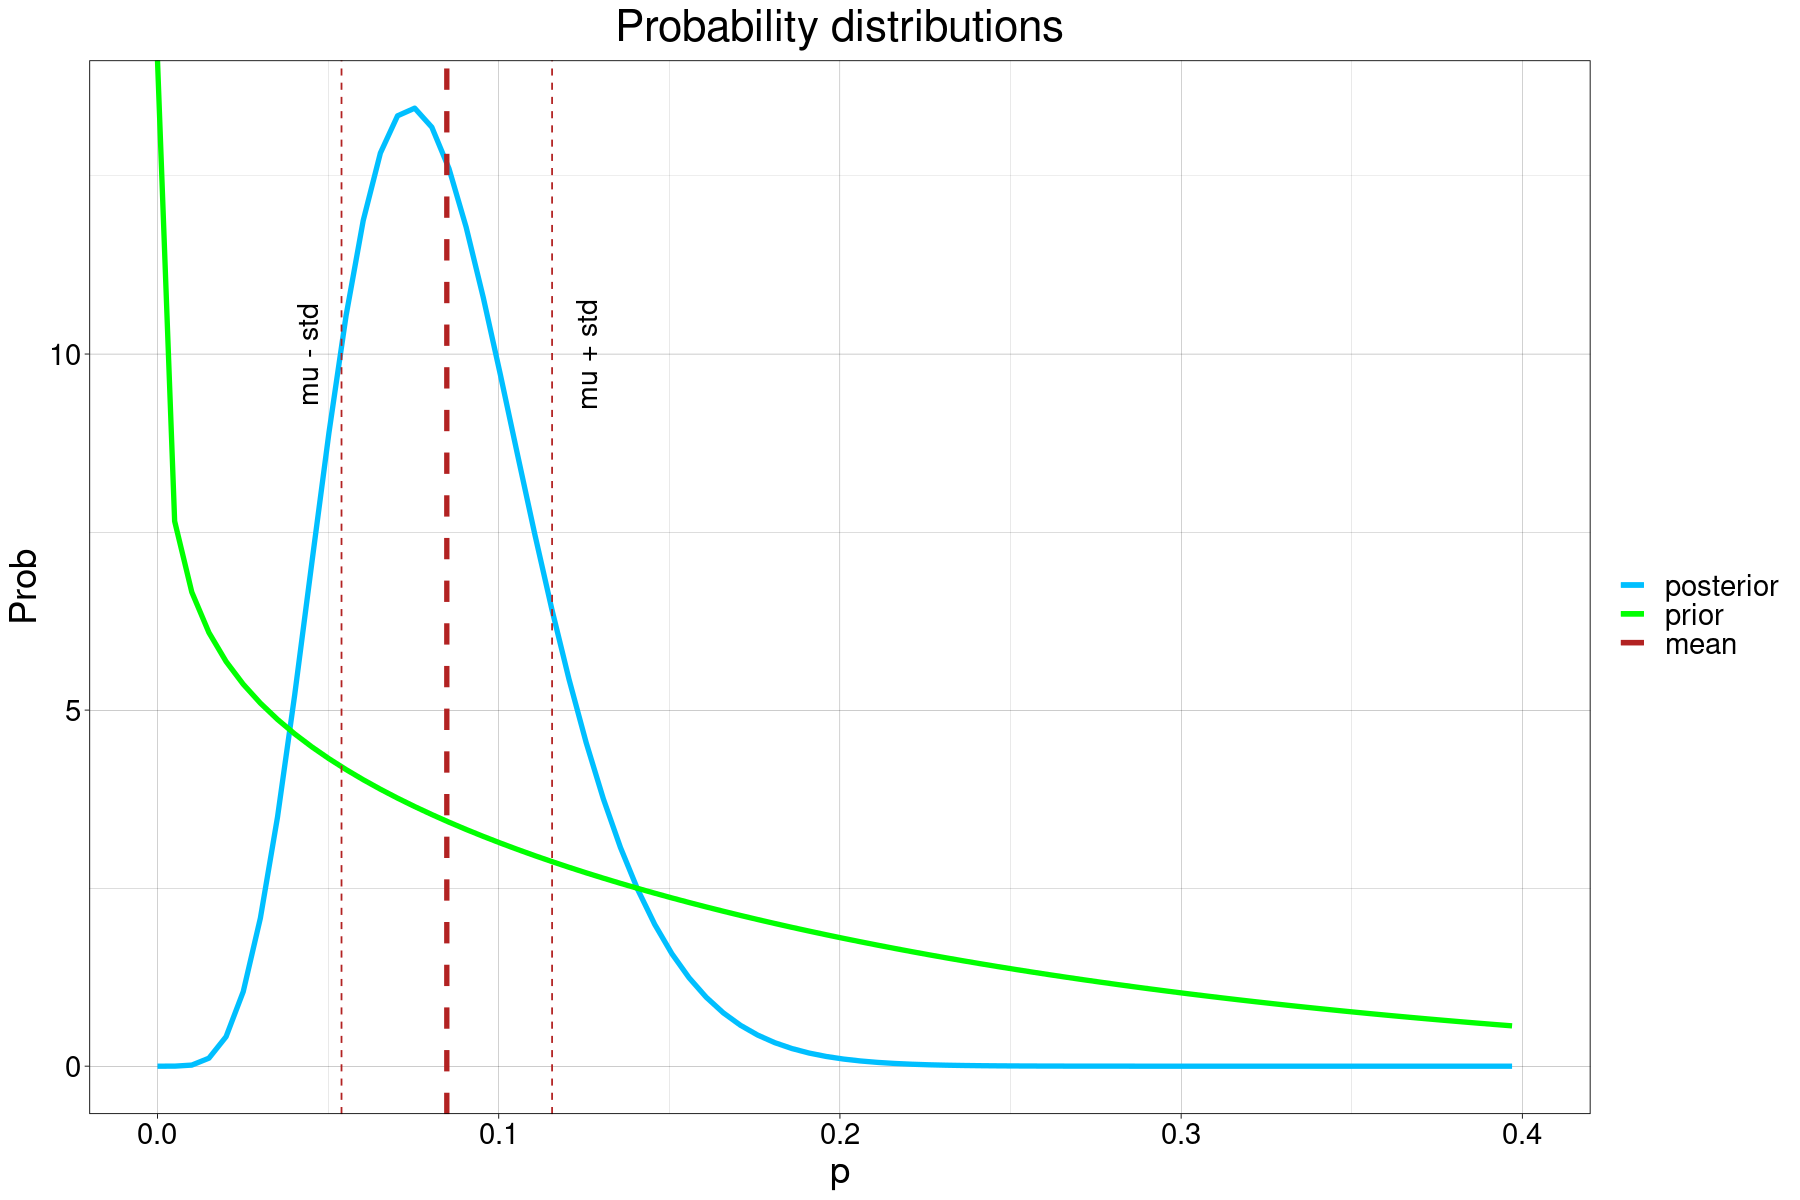

In [6]:
options(repr.plot.width=15, repr.plot.height=10)

plot <- ggplot() +
        geom_line(aes(x=p, y=beta_distr, color="posterior"),lwd=1.5) + 
        geom_line(aes(x=p, y=dbeta(p, alpha, beta), color="prior"),lwd=1.5) + 
        geom_vline(xintercept = mu_post, linetype="dashed", color="firebrick", lwd=1.5) +
        geom_vline(xintercept = (mu_post + std_post), linetype="dashed", color="firebrick") +
        geom_vline(xintercept = (mu_post - std_post), linetype="dashed", color="firebrick") +
        theme_linedraw() +
        xlim(0,0.4)+
        scale_color_manual(name = "", values = c("posterior" = "deepskyblue","prior"="green", "mean" = "firebrick" ))+
        labs(title=glue("Probability distributions"), x="p",y="Prob")+
        theme(text = element_text(size=22), plot.title = element_text( hjust = 0.5))+
        annotate("text", x=(mu_post + std_post)+0.01, y=10, label= "mu + std",angle=90, size=6) + 
        annotate("text", x=(mu_post - std_post)-0.01, y=10, label= "mu - std",angle=90, size=6)

plot

### HT
First of all let's define the Null hypotesis: $ \text{H}_0$ is that $H_0 : p \geq p_0$ where $p_0 = 15$% which correspond to "the new method is no better than the previous one"\
Then it follow the alternative hypothesis: $ \text{H}_1$ is that $H_1 : p < p_0$


### Bayesian:
We need to calculate the posterior of the null hypothesis as the integral of the posterior:
\begin{equation}
P(H_0| y) = \int _{p_0} ^1 g(p|y) \> dp = 1 - \text{cdf}(p_0)
\end{equation}
We set the level of significance at $\alpha = 5$%

In [8]:
p_0 <- 0.15 #15%
a <- 0.05
p_alpha  <- qbeta(1-a, alpha_post, beta_post)
p_h0 <- 1 - pbeta(p, alpha_post, beta_post)


Warning message:
“Removed 150 row(s) containing missing values (geom_path).”


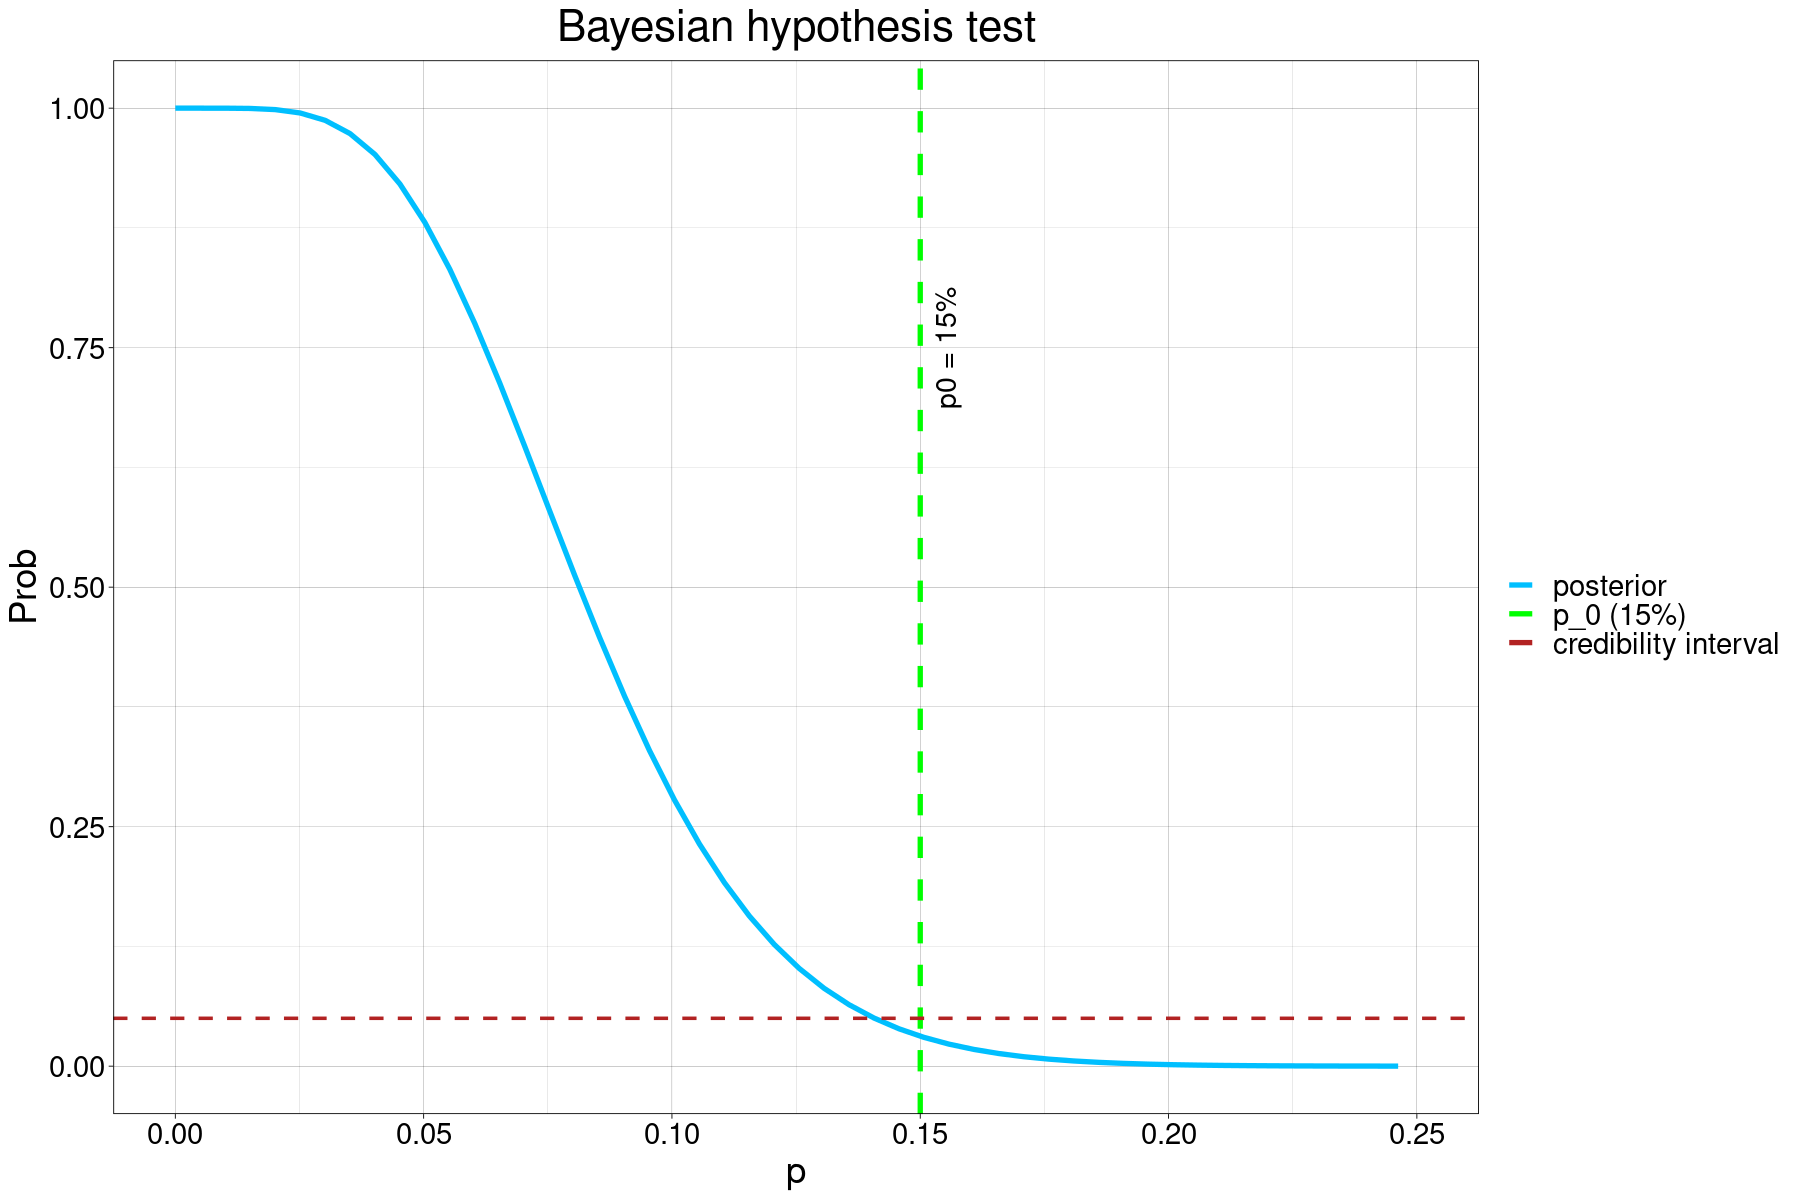

In [9]:
options(repr.plot.width=15, repr.plot.height=10)

plot <- ggplot() +
        geom_line(aes(x=p, y=p_h0, color="posterior"),lwd=1.5) + 
        geom_vline(xintercept = p_0, linetype="dashed", color="green", lwd=1.5) +
        geom_hline(yintercept = a, linetype="dashed", color="firebrick",lwd=1) +
        theme_linedraw() +
        xlim(0,0.25)+
        scale_color_manual(name = "", values = c("posterior" = "deepskyblue","p_0 (15%)"="green", "credibility interval" = "firebrick" ))+
        labs(title=glue("Bayesian hypothesis test"), x="p",y="Prob")+
        theme(text = element_text(size=22), plot.title = element_text( hjust = 0.5))+
        annotate("text", x=p_0+0.005, y=0.75, label= "p0 = 15%",angle=90, size=6) 
plot


In this plot the red line corresponds to the 5% significance level and divides the curve in the acceptance(up) and reject(below) region. The green line indicates the position of $p_0$ which lies in the rejecction region, so in the Bayesian approach I can reject the null hypothesis at 5% level of significance

In the following plot we can prove the same result by looking at the posterior pdf.

Warning message:
“Removed 168 rows containing missing values (position_stack).”
Warning message:
“Removed 140 row(s) containing missing values (geom_path).”


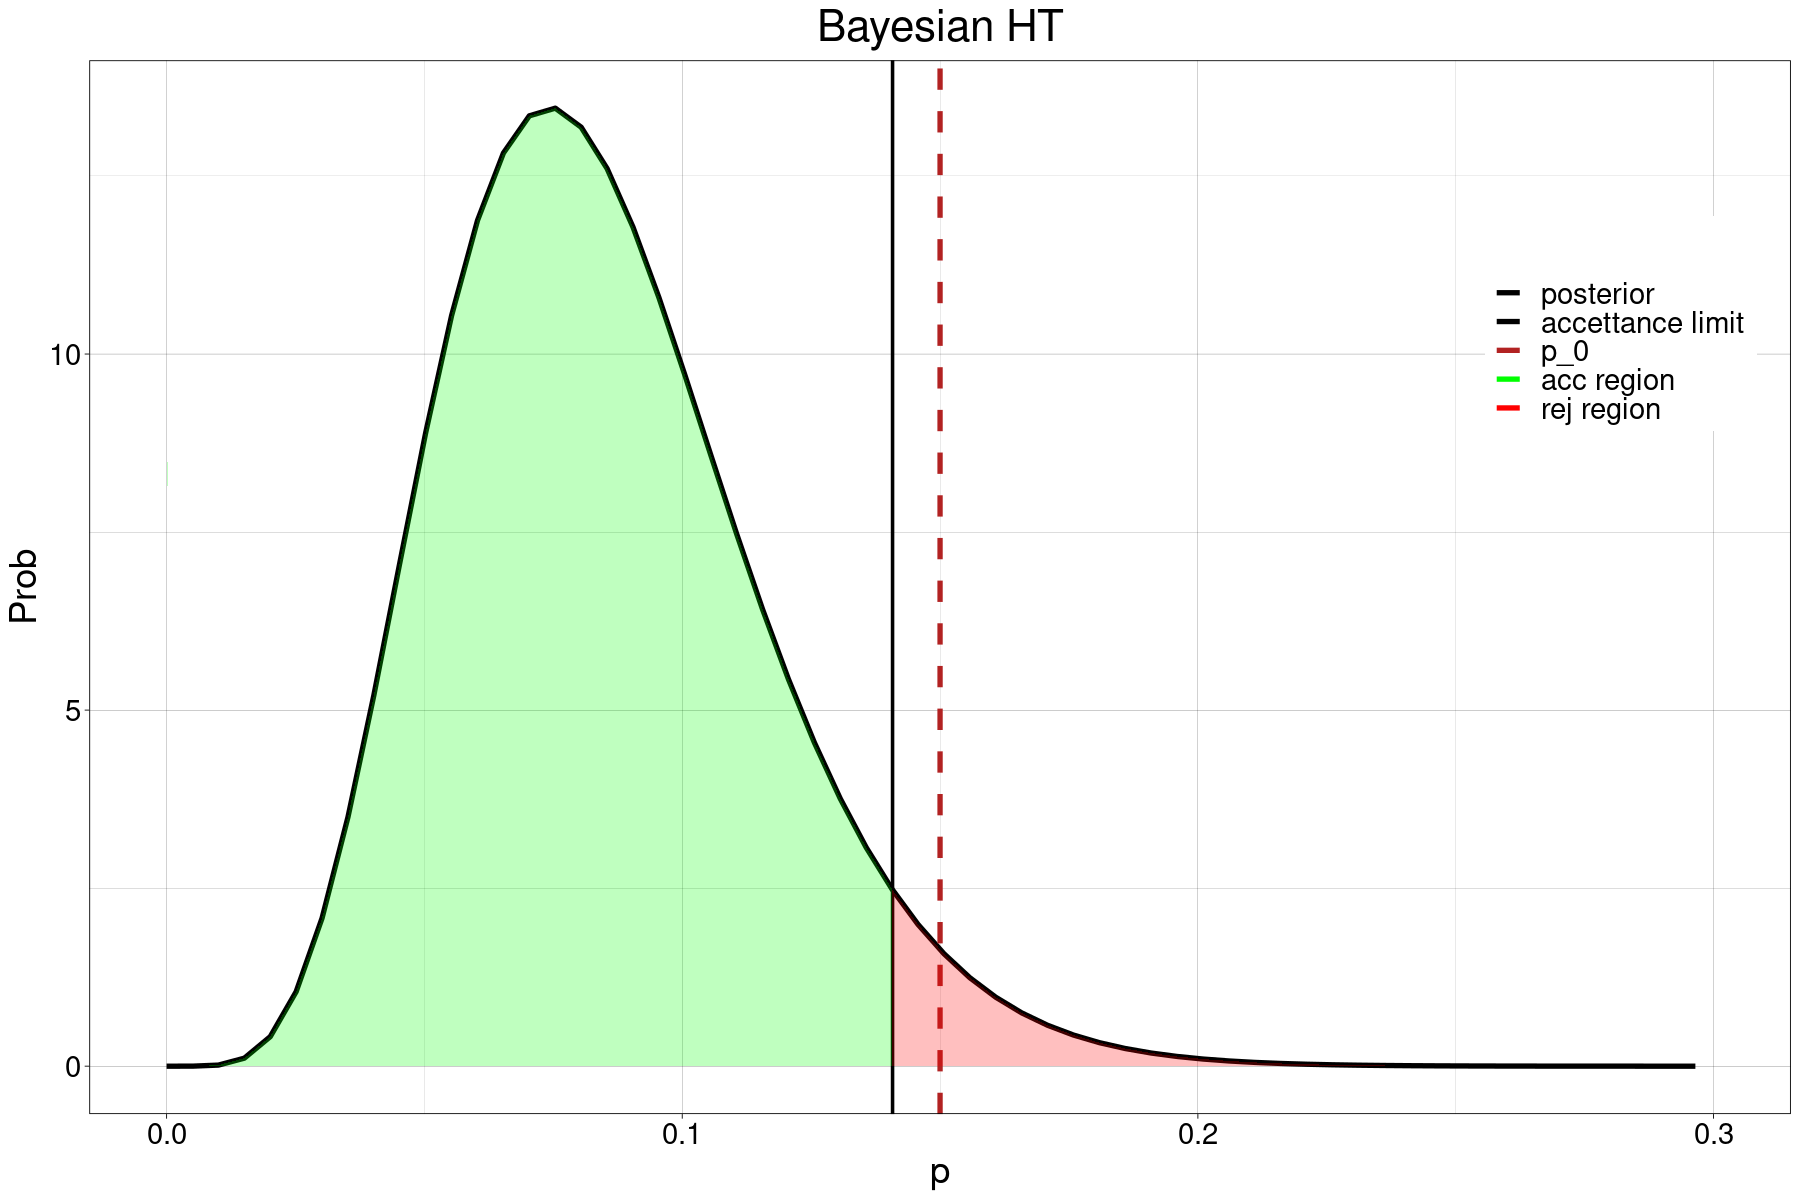

In [37]:
p_acc <- seq(0,  p_alpha,  length.out=150)
p_rej <- seq(p_alpha, 0.3, length.out=150)

plot <- ggplot() +
        geom_line(aes(x=p, y=beta_distr, color="posterior"),lwd=1.5) + 
        geom_vline(xintercept = p_alpha, color="black", lwd=1) +
        geom_vline(xintercept = p_0, linetype="dashed", color="firebrick", lwd=1.5) +
        geom_area(aes(x = ifelse(p<p_alpha, p, 0), y=beta_distr,), fill=adjustcolor("green",alpha.f=0.25))+
        geom_area(aes(x = ifelse(p>p_alpha-0.0005, p, 1), y=beta_distr,), fill=adjustcolor("red",alpha.f=0.25))+
        theme_linedraw() +
        xlim(0,0.3)+
        scale_color_manual(name = "", values = c("posterior" = "black","accettance limit"="black", "p_0" = "firebrick","acc region"="green", "rej region" = "red" ))+
        labs(title=glue("Bayesian HT"), x="p",y="Prob")+
        theme(text = element_text(size=22), plot.title = element_text( hjust = 0.5), legend.position=c(.9,.75))
        
plot

As in this plot, as in the previous one, the Null hypothesis can be rejected at this level of significance. In the second plot the value of $p_{\alpha}$ is $\simeq 14.1$%

### Frequentist

The hypothesis are the same as before. The null distribution of the test statistic is equal to the sampling distribution of the test statistic, given that the null hypothesis is true:
\begin{equation}
P(y|H_0) = \text{Binom}(y|n,p=0.15)
\end{equation}

The acceptance region (and the rejected) are defined as the region for which the CDF is up to $\alpha$. We have to recall that we are dealing with discrete distributions. This implies that there may be not a value of $y \in N$ such as $CDF(y)=\alpha$, so we search the closes value to alpha which divide the two regions

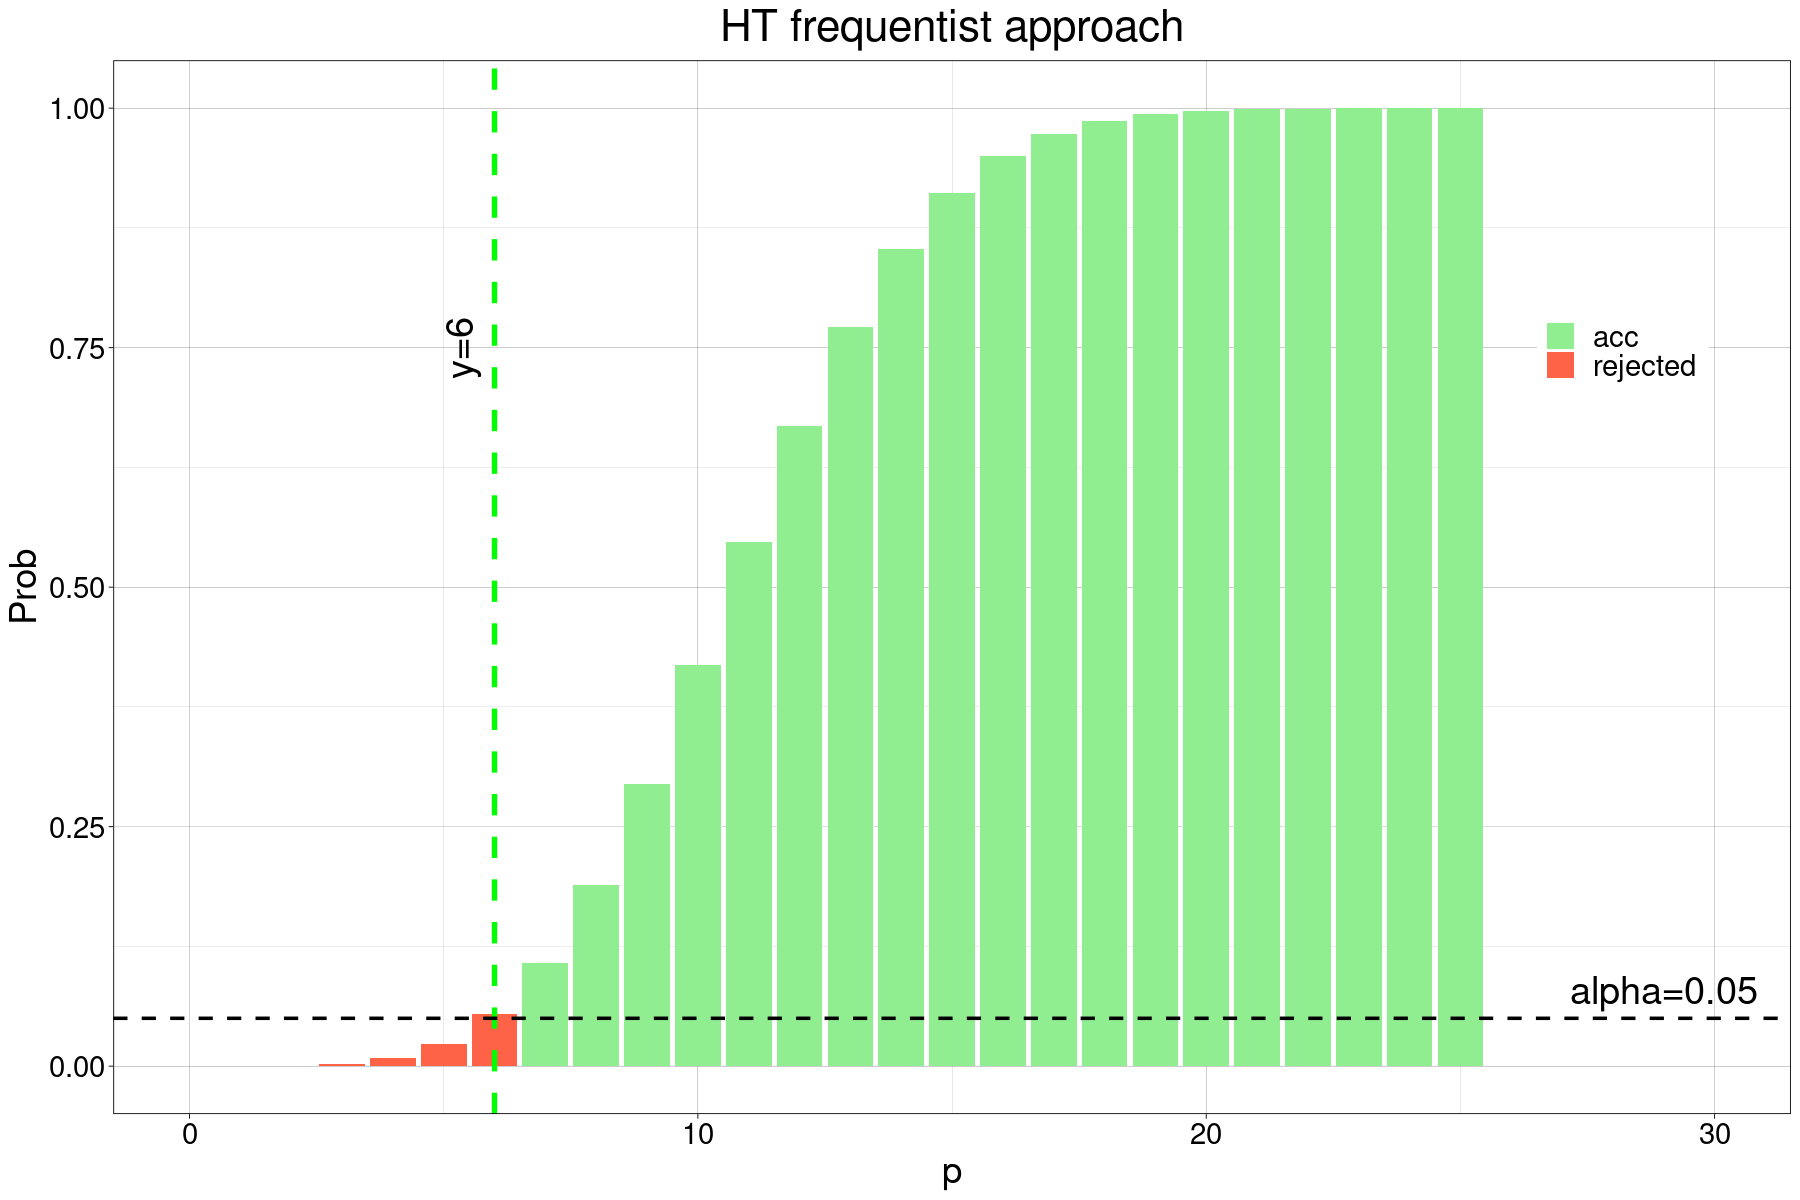

In [40]:
y_i <- 1:25
p_test <- pbinom(y_i, n, p_0)

y_acc  <- y_i[p_test > 1-a]
y_rej  <- y_i[p_test < 1-a]

pp_test <- dbinom(y_i, n, p_0)

col <- c(rep("rejected",6),rep("acc",length(p_test)-6))

df <- data.frame(y_i, p_test, col)

options(repr.plot.width=15, repr.plot.height=10)
barp <- ggplot(df, aes(x=y_i, y=p_test, fill=col)) +
        geom_bar(stat="identity")+
        geom_vline(xintercept = y, linetype="dashed", color="green", lwd=1.5) +
        geom_hline(yintercept = a, linetype="dashed", color="black", lwd=1) +
        theme_linedraw() +
        xlim(0,30)+
        scale_fill_manual(name="",values = c("#90ee90","tomato") )+
        labs(title=glue("HT frequentist approach"), x="p",y="Prob")+
        theme(text = element_text(size=22), plot.title = element_text( hjust = 0.5), 
                legend.position=c(.9,.75))+
        annotate("text", x=5.3, y=0.75, label= "y=6",angle=90, size=8) +
        annotate("text", x=29,  y=0.08,  label= "alpha=0.05", size=8) 
barp

The number of observations $y=6$ (green line) falls at the very end of the rejection region. Also in the frequentist approach I reject the null hypothesis

## Es2

From the theory, we know that a Poassionan proces with uniform prior leads to a Gamma posterior $\Gamma(\alpha, \lambda) $ with the following parameter values: $\alpha = \sum_k y_k + 1$ and $\lambda = n$. While for the Jeffiyes prior $\alpha = \sum_k y_k + 1/2$ and $\lambda = n$\
We recall that a uniform prior is like a gamma distribution Gamma(1,0), while Jeffres' prior is Gamma(1/2,0).



In [41]:
n1 <- c(109,65,22,3,1,0)
n2 <- c(144,91,32,11,2,0)
y_death <- 0:4
deaths1 <- NULL; deaths2 <- NULL # equivalent to using c()

for (i in 1:5) {
    deaths1 <- append(deaths1, values = rep(y_death[i], times = n1[i]))
    deaths2 <- append(deaths2, values = rep(y_death[i], times = n2[i]))
}

alpha_u1 <- sum(deaths1) + 1
alpha_u2 <- sum(deaths2) + 1
lambda1  <- length(deaths1)
lambda2  <- length(deaths2)

n_sample <- 1000
# p <- seq(20,60, length.out=n_sample)
p <- seq(0,2, length.out=n_sample)
post_u1 <- dgamma(p, alpha_u1,lambda1) / (sum(dgamma(p, alpha_u1,lambda1) )/n_sample)
post_u2 <- dgamma(p, alpha_u2,lambda2) / (sum(dgamma(p, alpha_u2,lambda2) )/n_sample)


In [47]:
cat("The value of the posterior parameters:\n")
cat("For the first dataset:\n")
cat("\t alpha=",alpha_u1,",lambda=",lambda1,"\n")
cat("\t-----\n")
cat("For the second dataset:\n")
cat("\t alpha=",alpha_u2,",lambda=",lambda2)

The value of the posterior parameters:
For the first dataset:
	 alpha= 123 ,lambda= 200 
	-----
For the second dataset:
	 alpha= 197 ,lambda= 280

For the mean and std values we follow the formula for the Gamma distribution. To calulate the median we use the definition

In [20]:
mean_u1 <- alpha_u1/lambda1; var_u1 <- alpha_u1/lambda1^2 
mean_u2 <- alpha_u2/lambda2; var_u2 <- alpha_u2/lambda2^2 

median_u1 <- p[length(which( cumsum(post_u1) / n_sample <= 0.5))]
median_u2 <- p[length(which( cumsum(post_u2) / n_sample <= 0.5))]

u1_low  <- qgamma(0.025, alpha_u1, lambda1); u1_high <- qgamma(0.975, alpha_u1, lambda1)
u2_low  <- qgamma(0.025, alpha_u2, lambda2); u2_high <- qgamma(0.975, alpha_u2, lambda2)


In [21]:
cat("Uniform prior, first dataset \n")
cat("\t mean=", mean_u1,"\n")
cat("\t var=", var_u1,"\n")
cat("\t meadian=", median_u1,"\n")
cat("\t 95% credibility interval boundary [", u1_low,"-", u1_high,"]\n")

cat("Uniform prior, second dataset \n")
cat("\t mean=", mean_u2,"\n")
cat("\t var=", var_u2,"\n")
cat("\t meadian=", median_u2,"\n")
cat("\t 95% credibility interval boundary [", u2_low,"-", u2_high,"]\n")


Uniform prior, first dataset 
	 mean= 0.615 
	 var= 0.003075 
	 meadian= 0.6106106 
	 95% credibility interval boundary [ 0.5111251 - 0.7283408 ]
Uniform prior, second dataset 
	 mean= 0.7035714 
	 var= 0.002512755 
	 meadian= 0.7007007 
	 95% credibility interval boundary [ 0.6087487 - 0.805157 ]


Warning message:
“Removed 625 row(s) containing missing values (geom_path).”
Warning message:
“Removed 625 row(s) containing missing values (geom_path).”
Warning message:
“Removed 625 row(s) containing missing values (geom_path).”


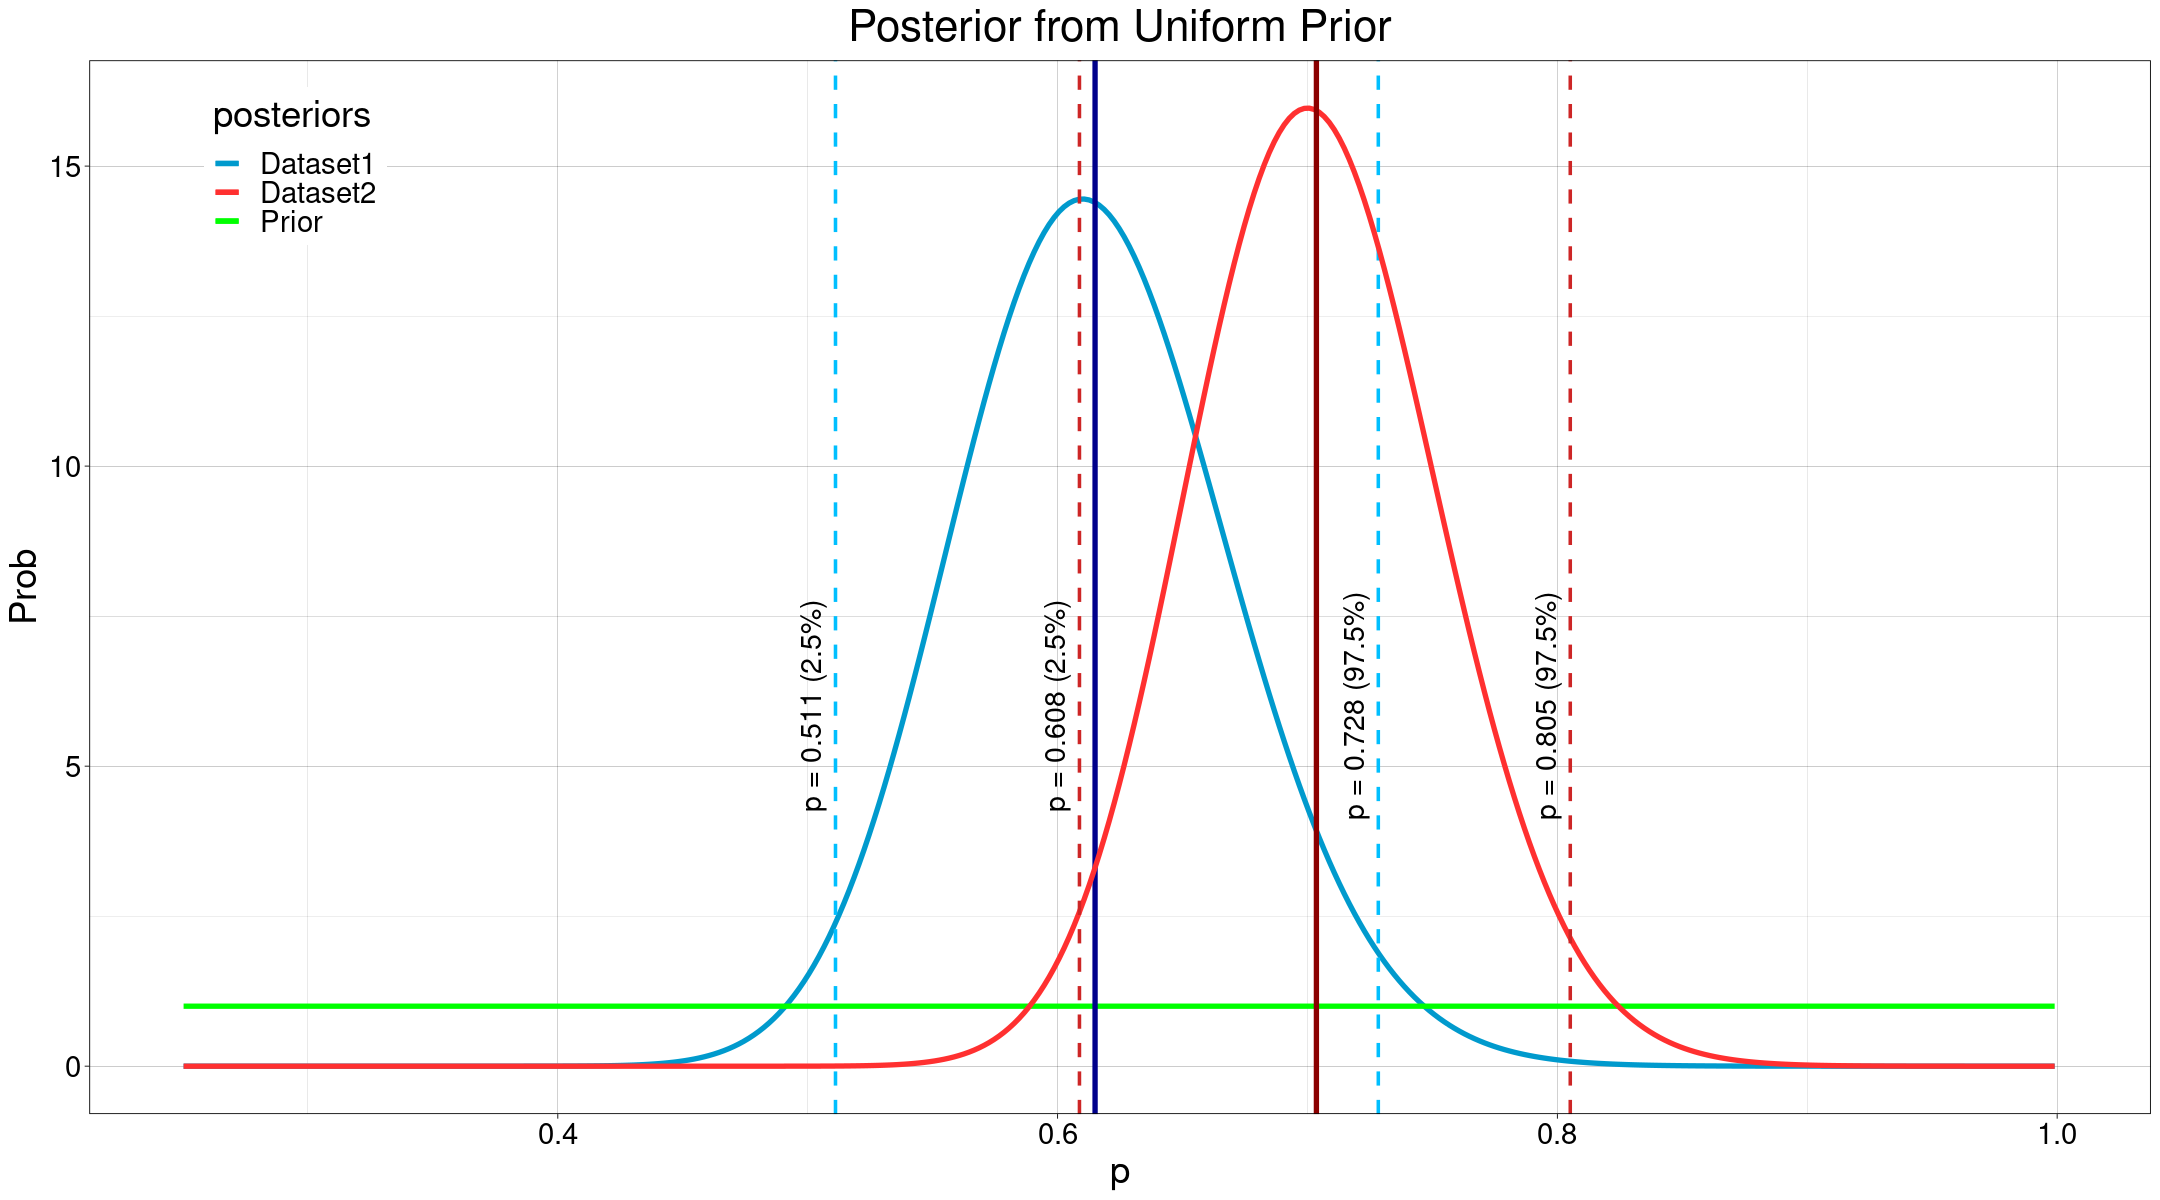

In [22]:
options(repr.plot.width=18, repr.plot.height=10)

plot <- ggplot() +
        geom_line(aes(x=p, y=post_u1, color="Dataset1"),lwd=1.5) + 
        geom_line(aes(x=p, y=rep(1, length(p))), color="green",lwd=1.5) + 
        geom_vline(xintercept = mean_u1, color="darkblue", lwd=1.5) +
        geom_vline(xintercept = u1_low,  linetype="dashed", color="deepskyblue1",lwd=1) +
        geom_vline(xintercept = u1_high, linetype="dashed", color="deepskyblue1", lwd=1) +

        geom_line(aes(x=p, y=post_u2, color="Dataset2"),lwd=1.5) + 
        geom_vline(xintercept = mean_u2, color="darkred", lwd=1.5) +
        geom_vline(xintercept = u2_low,  linetype="dashed", color="firebrick3",lwd=1) +
        geom_vline(xintercept = u2_high, linetype="dashed", color="firebrick3", lwd=1) +
        xlim(0.25,1)+
        

        annotate("text", x=u1_low-0.01, y=6, label= "p = 0.511 (2.5%)",angle=90, size=6) + 
        annotate("text", x=u1_high-0.01, y=6,label= "p = 0.728 (97.5%)",angle=90, size=6) + 
        annotate("text", x=u2_low-0.01, y=6, label= "p = 0.608 (2.5%)",angle=90, size=6) + 
        annotate("text", x=u2_high-0.01, y=6, label= "p = 0.805 (97.5%)",angle=90, size=6) + 
        
        scale_color_manual(name = "posteriors", values = c("Dataset1" = "deepskyblue3", "Dataset2"="firebrick1","Prior"="green"))+
        theme_linedraw() +
        labs(title=glue("Posterior from Uniform Prior"), x="p",y="Prob")+
        theme(text = element_text(size=22), plot.title = element_text( hjust = 0.5), legend.position=c(.1,.90))

plot


In these plots we can see the posteriors from the two different datasets, with its mean and the 95% credibilty interval. 

### Jeffries' Prior

In [49]:
alpha_j1 <- sum(deaths1) + 0.5
alpha_j2 <- sum(deaths2) + 0.5

post_j1 <- dgamma(p, alpha_j1,lambda1) / (sum(dgamma(p, alpha_j1,lambda1) )/n_sample)
post_j2 <- dgamma(p, alpha_j2,lambda2) / (sum(dgamma(p, alpha_j2,lambda2) )/n_sample)

In [50]:
cat("The value of the posterior parameters:\n")
cat("For the first dataset:\n")
cat("\t alpha=",alpha_j1,",lambda=",lambda1,"\n")
cat("\t-----\n")
cat("For the second dataset:\n")
cat("\t alpha=",alpha_j2,",lambda=",lambda2)

The value of the posterior parameters:
For the first dataset:
	 alpha= 122.5 ,lambda= 200 
	-----
For the second dataset:
	 alpha= 196.5 ,lambda= 280

In [24]:
mean_j1 <- alpha_j1/lambda1; var_j1 <- alpha_j1/lambda1^2 
mean_j2 <- alpha_j2/lambda2; var_j2 <- alpha_j2/lambda2^2 

median_j1 <- p[length(which( cumsum(post_j1) / n_sample <= 0.5))]
median_j2 <- p[length(which( cumsum(post_j2) / n_sample <= 0.5))]

j1_low  <- qgamma(0.025, alpha_j1, lambda1); j1_high <- qgamma(0.975, alpha_j1, lambda1)
j2_low  <- qgamma(0.025, alpha_j2, lambda2); j2_high <- qgamma(0.975, alpha_j2, lambda2)


In [25]:
cat("Jeffires' prior, first dataset \n")
cat("\t mean=", mean_j1,"\n")
cat("\t var=", var_j1,"\n")
cat("\t meadian=", median_j1,"\n")
cat("\t 95% credibility interval boundary", j1_low,"-", j1_high,"\n")

cat("Jeffries' prior, second dataset \n")
cat("\t mean=", mean_j2,"\n")
cat("\t var=", var_j2,"\n")
cat("\t meadian=", median_j2,"\n")
cat("\t 95% credibility interval boundary", j2_low,"-", j2_high,"\n")


Jeffires' prior, first dataset 
	 mean= 0.6125 
	 var= 0.0030625 
	 meadian= 0.6086086 
	 95% credibility interval boundary 0.5088464 - 0.7256196 
Jeffries' prior, second dataset 
	 mean= 0.7017857 
	 var= 0.002506378 
	 meadian= 0.6986987 
	 95% credibility interval boundary 0.6070878 - 0.8032465 


Warning message:
“Removed 500 row(s) containing missing values (geom_path).”
Warning message:
“Removed 500 row(s) containing missing values (geom_path).”
Warning message:
“Removed 500 row(s) containing missing values (geom_path).”


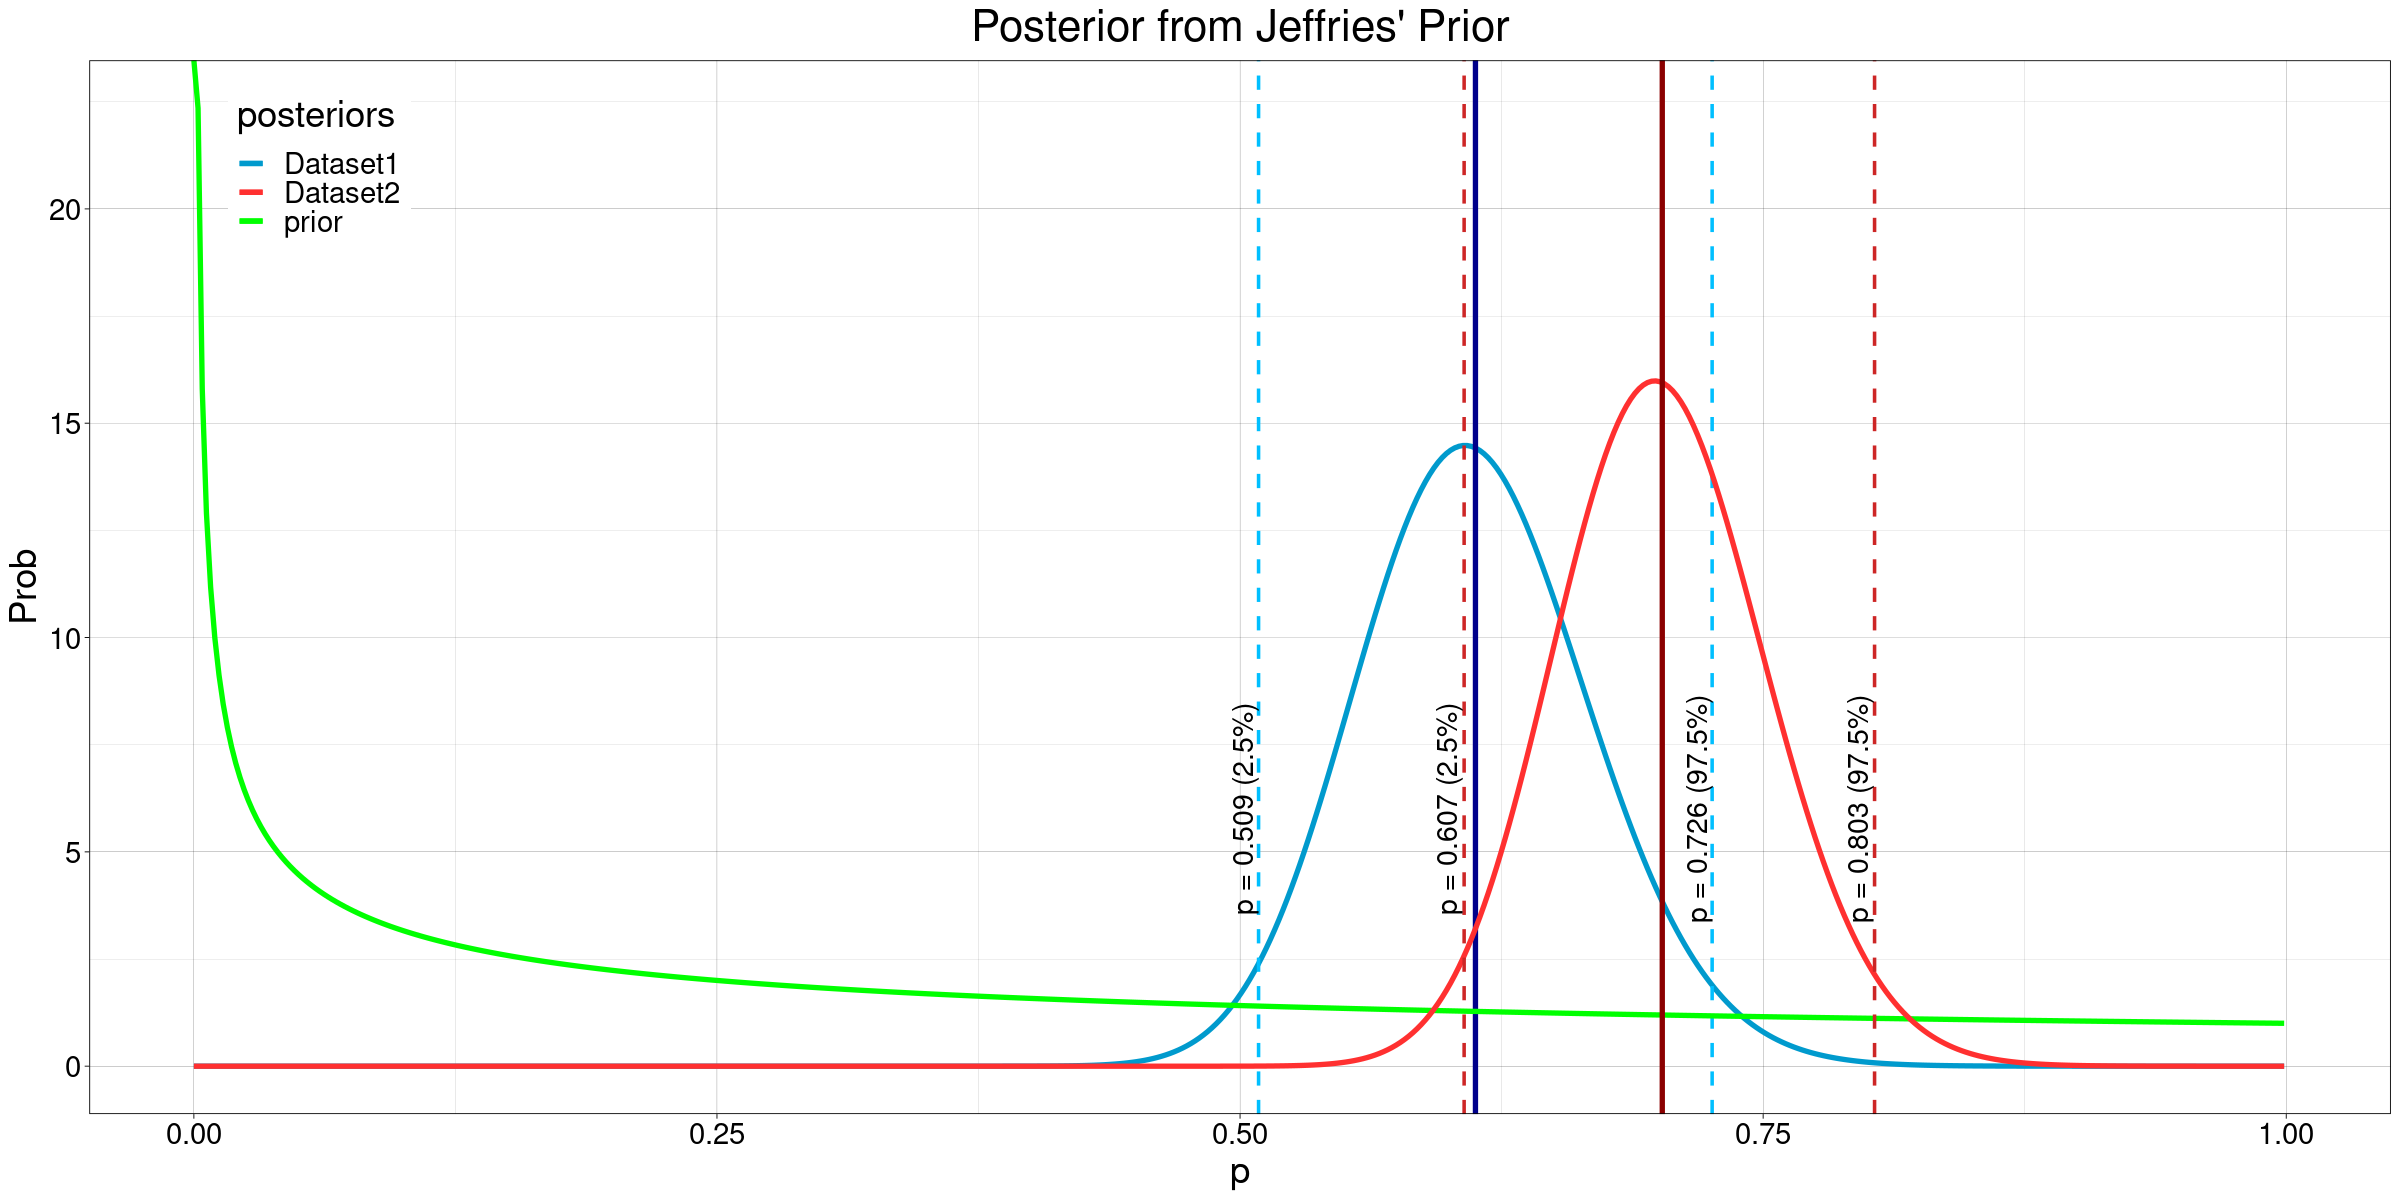

In [26]:
options(repr.plot.width=20, repr.plot.height=10)

plot <- ggplot() +
        geom_line(aes(x=p, y=post_j1, color="Dataset1"),lwd=1.5) + 
        geom_vline(xintercept = mean_j1, color="darkblue", lwd=1.5) +
        geom_vline(xintercept = j1_low,  linetype="dashed", color="deepskyblue1",lwd=1) +
        geom_vline(xintercept = j1_high, linetype="dashed", color="deepskyblue1", lwd=1) +
        geom_line(aes(x=p, y=1/sqrt(p)), color="green",lwd=1.5) + 

        geom_line(aes(x=p, y=post_j2, color="Dataset2"),lwd=1.5) + 
        geom_vline(xintercept = mean_j2, color="darkred", lwd=1.5) +
        geom_vline(xintercept = j2_low,  linetype="dashed", color="firebrick3",lwd=1) +
        geom_vline(xintercept = j2_high, linetype="dashed", color="firebrick3", lwd=1) +
        xlim(0,1)+

        annotate("text", x=u1_low-0.01, y=6, label= "p = 0.509 (2.5%)",angle=90, size=6) + 
        annotate("text", x=u1_high-0.01, y=6,label= "p = 0.726 (97.5%)",angle=90, size=6) + 
        annotate("text", x=u2_low-0.01, y=6, label= "p = 0.607 (2.5%)",angle=90, size=6) + 
        annotate("text", x=u2_high-0.01, y=6, label= "p = 0.803 (97.5%)",angle=90, size=6) + 
        
        scale_color_manual(name = "posteriors", values = c("Dataset1" = "deepskyblue3", "Dataset2"="firebrick1","prior"="green"))+
        theme_linedraw() +
        labs(title=glue("Posterior from Jeffries' Prior"), x="p",y="Prob")+
        theme(text = element_text(size=22), plot.title = element_text( hjust = 0.5), legend.position=c(.1,.90))

plot


## Es3

The process is Binomial similarlyf like in the first exercize. The "success" outcome represents "the precence of a high bacter level". \
In the frequentist approach, in one single experiment, the unbasiased estimator of the failure probability is given by the number of success divided by the total number of trials: $p_{fail} = \frac{fails}{trials}$, as in the first ex.

For the Bayesian approach:\
Assuming a $Beta (1,10)$ prior, as in the first exercize, the posterior is a $Beta(\alpha, \beta)$ too but with particular value for the two parameters.
\begin{equation}
\begin{cases}
\alpha' = \alpha + y \\
\beta' = \beta + n -y
\end{cases}
\end{equation}


In [52]:
n <- 116
y <- 11

p_freq <- y/n

alpha_prior <- 1
beta_prior  <- 10

alpha <- alpha_prior + y
beta  <- beta_prior  + n - y

mu_post  <- alpha / (alpha + beta)
std_post <- sqrt((alpha*beta)/((alpha+beta)^2*(alpha+beta+1)))

n_sample <- 1000
p <- seq(0,1, length.out=n_sample)
prior <- dbeta(p, alpha_prior, beta_prior)
post  <- dbeta(p, alpha, beta)


Warning message:
“Removed 700 row(s) containing missing values (geom_path).”
Warning message:
“Removed 700 row(s) containing missing values (geom_path).”


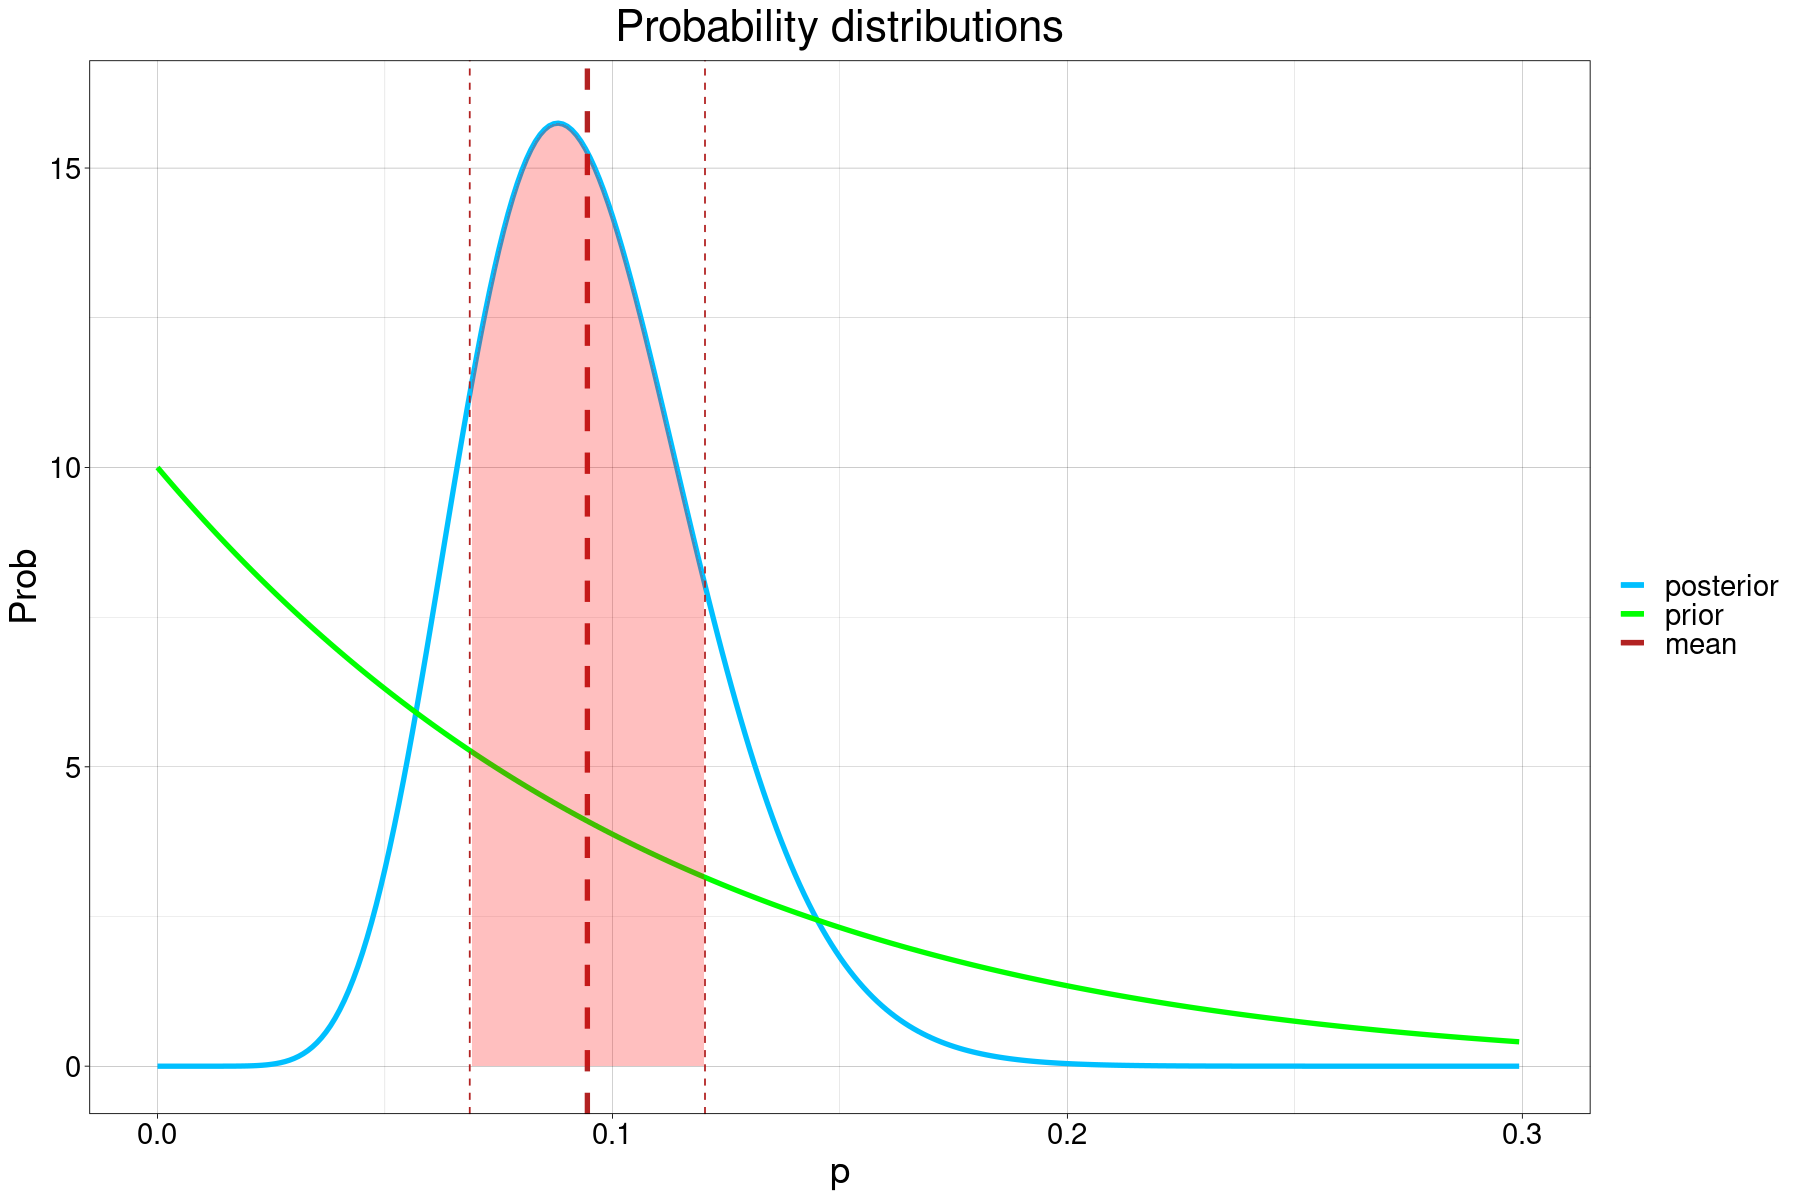

In [53]:
options(repr.plot.width=15, repr.plot.height=10)

plot <- ggplot() +
        geom_line(aes(x=p, y=post, color="posterior"),lwd=1.5) + 
        geom_line(aes(x=p, y=prior, color="prior"),lwd=1.5) + 
        geom_vline(xintercept = mu_post, linetype="dashed", color="firebrick", lwd=1.5) +
        geom_vline(xintercept = (mu_post + std_post), linetype="dashed", color="firebrick") +
        geom_vline(xintercept = (mu_post - std_post), linetype="dashed", color="firebrick") +
        geom_area(aes(x = ifelse(p>(mu_post - std_post) & p<(mu_post + std_post), p, 0), y=post,), fill=adjustcolor("red",alpha.f=0.25))+
        theme_linedraw() +
        xlim(0,0.3)+
        ylim(0,16)+
        scale_color_manual(name = "", values = c("posterior" = "deepskyblue","prior"="green", "mean" = "firebrick" ))+
        labs(title=glue("Probability distributions"), x="p",y="Prob")+
        theme(text = element_text(size=22), plot.title = element_text( hjust = 0.5))
plot

In [54]:
low  <- qbeta(0.025, alpha, beta)
high <- qbeta(0.975, alpha, beta)

#results
cat("The frequentist estimator for p =",round(p_freq,3),"\n")
cat("the estimator in the Bayesian case is",round(mu_post,3),"with a std of",round(std_post,3),"\n")
cat("The credibility interval for the posterior is", round(low,4),"-",round(high,4),"\n")

The frequentist estimator for p = 0.095 
the estimator in the Bayesian case is 0.094 with a std of 0.026 
The credibility interval for the posterior is 0.0502 - 0.1508 


### HT
setting the hypothesis: $H_0 : p=p_0=0.1$ and $H_1 : p \neq p_0$.
This is a two-tailed hypothesis test (while the first exercize was one-tailed).

### Bayesian
To test $H_0$ at significance level $\alpha$, we compute the posterior a $(1-\alpha) \times 100$% credibility interval for p, determined by the upper and lower quantiles. Then we look for the position of $p_0=0.1$ of it lies inside the credibility interval. If so, then the null hypothesis can not be rejected at this level of significance.

Warning message:
“Removed 700 rows containing missing values (position_stack).”
Warning message:
“Removed 700 row(s) containing missing values (geom_path).”


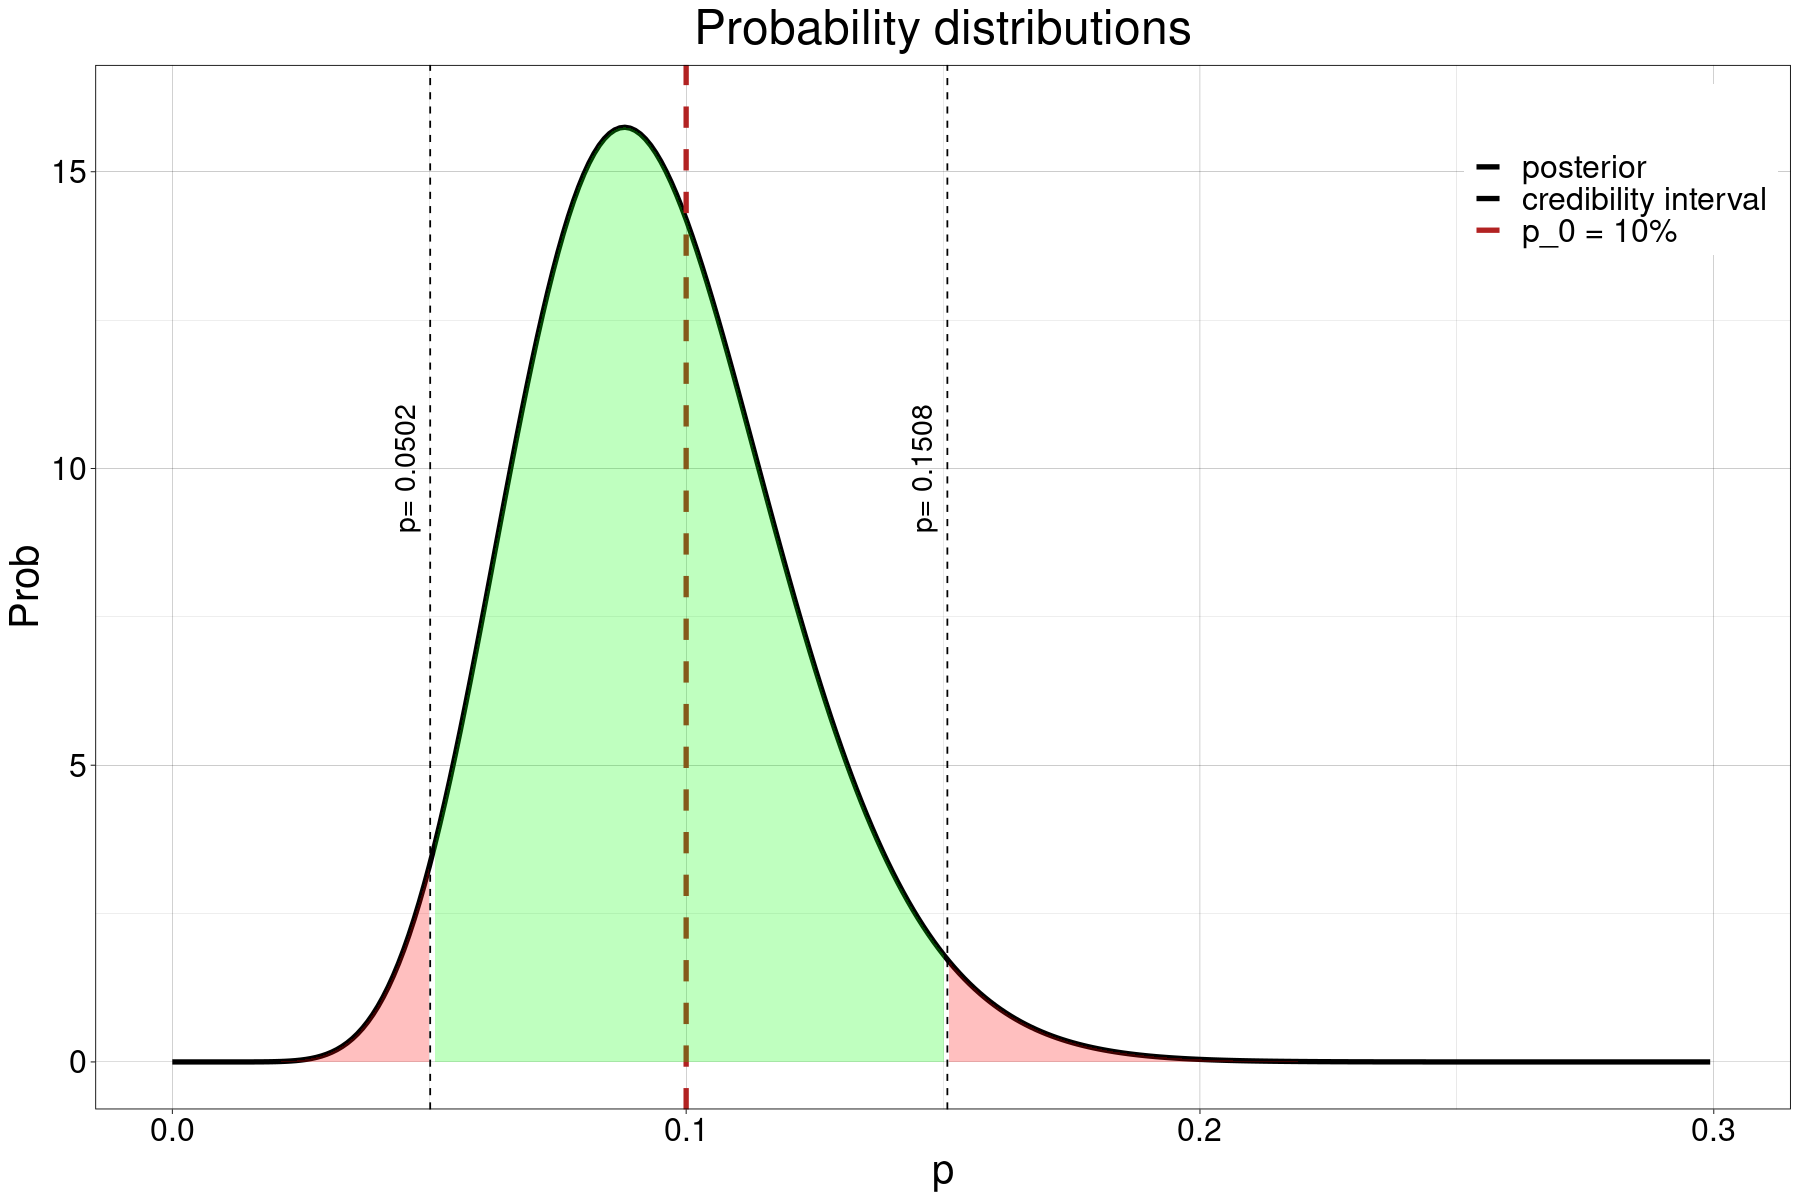

In [55]:
p_h0 <- 0.1
a <- 0.05

plot <- ggplot() +
        geom_line(aes(x=p, y=post, color="posterior"),lwd=1.5) + 
        geom_vline(xintercept = p_h0, linetype="dashed", color="firebrick", lwd=1.5) +
        geom_vline(xintercept = low, linetype="dashed", color="black") +
        geom_vline(xintercept = high, linetype="dashed", color="black") +
        geom_area(aes(x = ifelse(p>low & p< high , p, 0), y=post,), fill=adjustcolor("green",alpha.f=0.25))+
        geom_area(aes(x = ifelse(p<low , p, 0), y=post,), fill=adjustcolor("red",alpha.f=0.25))+
        geom_area(aes(x = ifelse(p>high , p, 0), y=post,), fill=adjustcolor("red",alpha.f=0.25))+
        theme_linedraw() +
        xlim(0,0.3)+
        ylim(0,16)+
       
        annotate("text", x=low-0.005, y=10, label= paste("p=",round(low,4)),angle=90, size=6) + 
        annotate("text", x=high-0.005, y=10, label= paste("p=",round(high,4)),angle=90, size=6) + 
      
        scale_color_manual(name = "", values = c("posterior" = "black","credibility interval"="black", "p_0 = 10%" = "firebrick" ))+
        labs(title=glue("Probability distributions"), x="p",y="Prob")+
        theme(text = element_text(size=24), plot.title = element_text( hjust = 0.5), legend.position=c(.9,.90))
plot


Hence, since $p_0$ falls in the acceptance region we can not reject the null hypothesis at $\alpha$ level of significance.


### Frequentist HT
The null distribuion is the sampling distribution of y: $P(y|n,p) = \text{Binom}(y|n=116,p=0.1)$\
We follow the same steps as in the exercize one.

Warning message:
“Removed 86 rows containing missing values (position_stack).”
Warning message:
“Removed 1 rows containing missing values (geom_bar).”


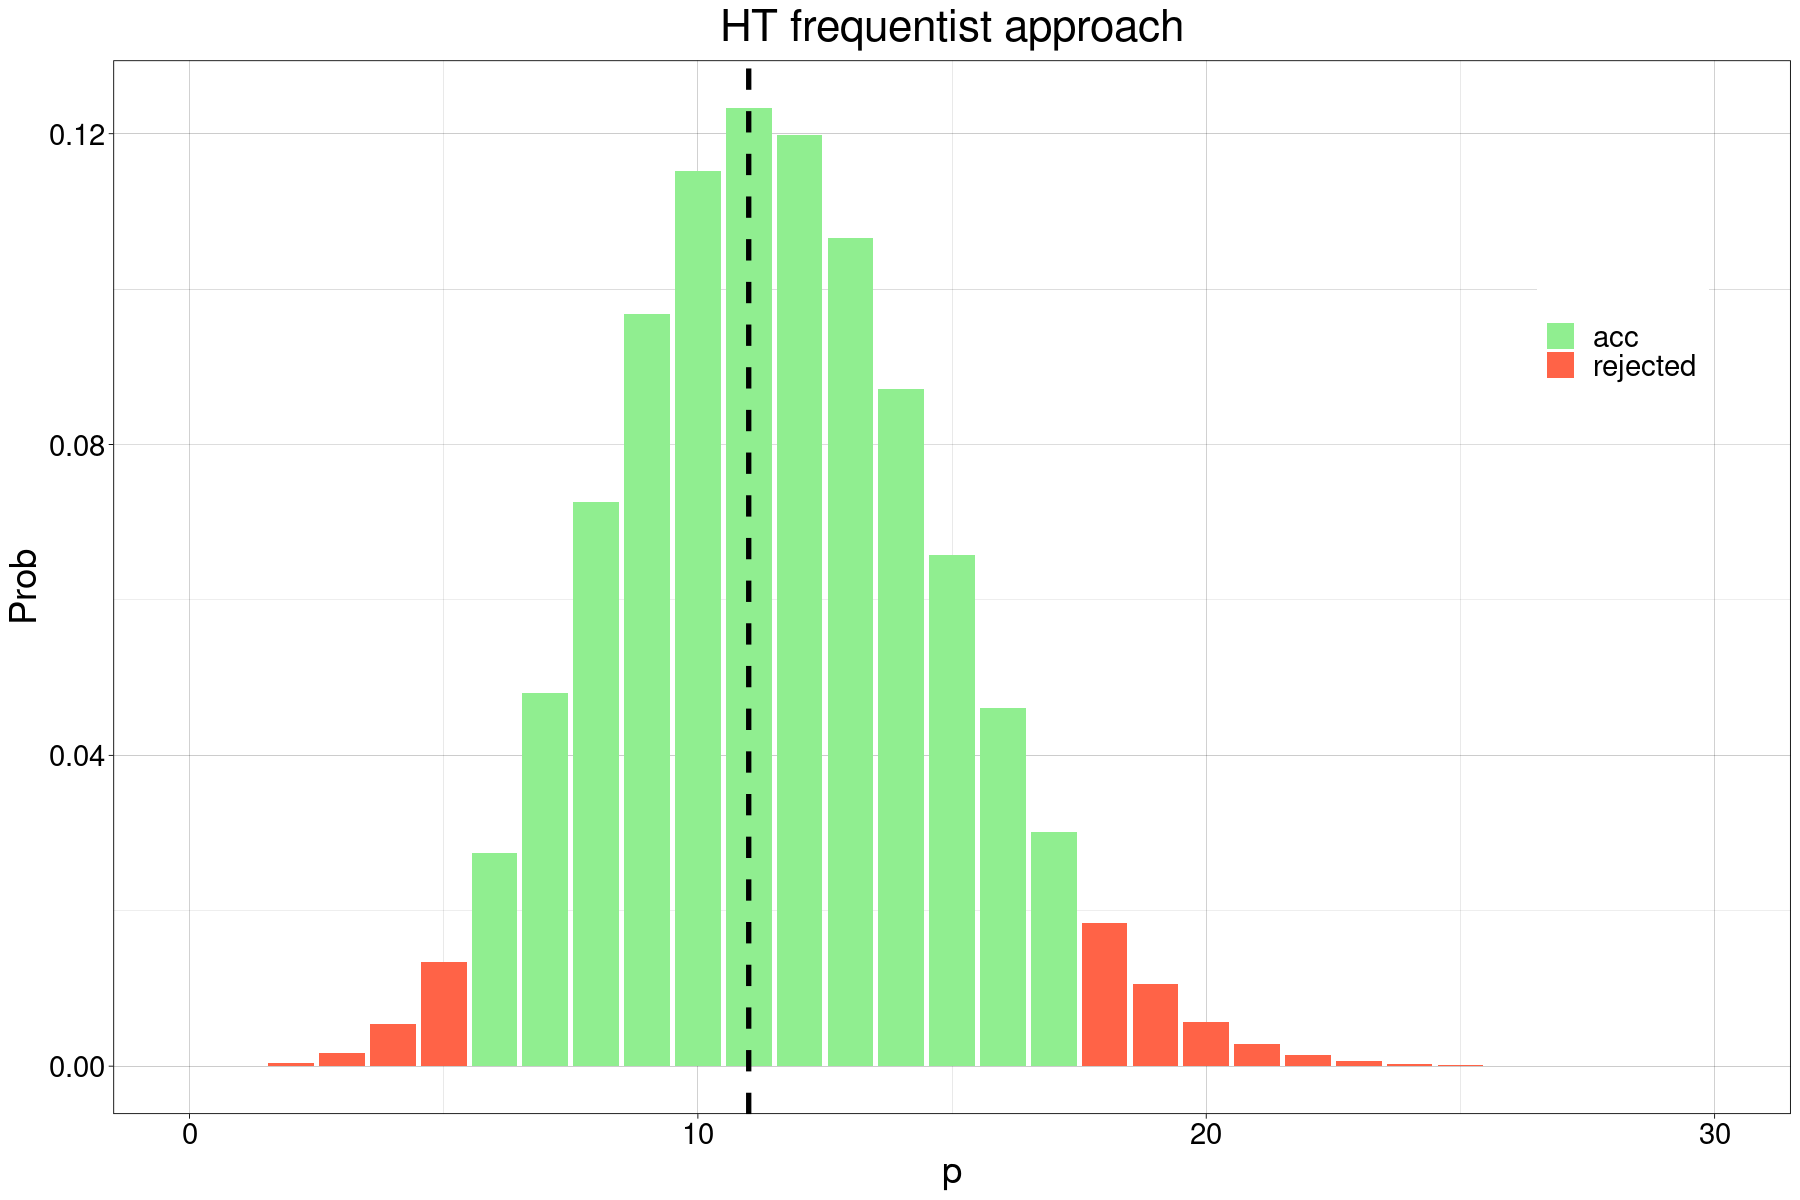

In [56]:
n <- 116
y <- 11
y_i <- 1:n

p_test <- pbinom(y_i, n, 0.1)


y_acc <- y_i[p_test > 0.025 & p_test<0.975]
y_rej_left  <- y_i[p_test < 0.025]
y_rej_right <- y_i[p_test > 0.975]

pp_test <- dbinom(y_i, n, p_h0)
col <- c(rep("rejected",length(y_rej_left)),rep("acc",length(y_acc)),rep("rejected",length(y_rej_right)) )

df <- data.frame(y_i, pp_test,col)

options(repr.plot.width=15, repr.plot.height=10)

barp <- ggplot(df, aes(x=y_i, y=pp_test,fill=col)) +
        geom_bar(stat="identity")+
        geom_vline(xintercept = y, linetype="dashed", color="black", lwd=1.5) +
        theme_linedraw() +
        xlim(0,30)+
        scale_fill_manual(name="",values = c(adjustcolor("#90ee90",alpha.f=2),adjustcolor("tomato",alpha.f=1)) )+
        labs(title=glue("HT frequentist approach"), x="p",y="Prob")+
        theme(text = element_text(size=22), plot.title = element_text( hjust = 0.5), 
                legend.position=c(.9,.75))
barp


Also from the frequentist point of view, the observations found fall into the acceptance region, hence we can not reject the null hypothesis.

### New measurement
We proceed as in the first part of the exercize.\
The prior distributions have parameters $(\alpha _1, \beta _1)= (1,10)$ and $(\alpha _2, \beta _2)= (10,116)$

In [58]:
n <- 165 
y <- 9
p_freq2 <- y/n

alpha_prior1 <- 1
beta_prior1  <- 10
alpha_prior2 <- 12  #the alpha value of the first part of the exercise 
beta_prior2  <- 115

alpha_post1 <- alpha_prior1 + y 
beta_post1  <- beta_prior1 + n - y
alpha_post2 <- alpha_prior2 + y
beta_post2  <- beta_prior2 + n - y

mu_post1  <- alpha_post1 / (alpha_post1 + beta_post1)
std_post1 <- sqrt((alpha_post1*beta_post1)/((alpha_post1+beta_post1)^2*(alpha_post1+beta_post1+1)))
mu_post2  <- alpha_post2 / (alpha_post2 + beta_post2)
std_post2 <- sqrt((alpha_post2*beta_post2)/((alpha_post2+beta_post2)^2*(alpha_post2+beta_post2+1)))


In [59]:
#results
cat("The frequentist estimator for p =",round(p_freq2,4),"\n")

The frequentist estimator for p = 0.0545 


In [63]:
cat("Uniform prior:\n")
cat("alpha posterior", alpha_post1,"\n")
cat("beta posterior", beta_post1,"\n")
cat("beta posterior mean", mu_post1,"\n")
cat("beta posterior std", std_post1,"\n")
cat("-------------\nSecond Prior:\n")
cat("alpha posterior", alpha_post2,"\n")
cat("beta posterior", beta_post2,"\n")
cat("beta posterior mean", mu_post2,"\n")
cat("beta posterior std", std_post2,"\n")


Uniform prior:
alpha posterior 10 
beta posterior 166 
beta posterior mean 0.05681818 
beta posterior std 0.01740022 
-------------
Second Prior:
alpha posterior 21 
beta posterior 271 
beta posterior mean 0.07191781 
beta posterior std 0.01509307 


Warning message:
“Removed 750 row(s) containing missing values (geom_path).”
Warning message:
“Removed 750 row(s) containing missing values (geom_path).”
Warning message:
“Removed 750 row(s) containing missing values (geom_path).”
Warning message:
“Removed 750 row(s) containing missing values (geom_path).”


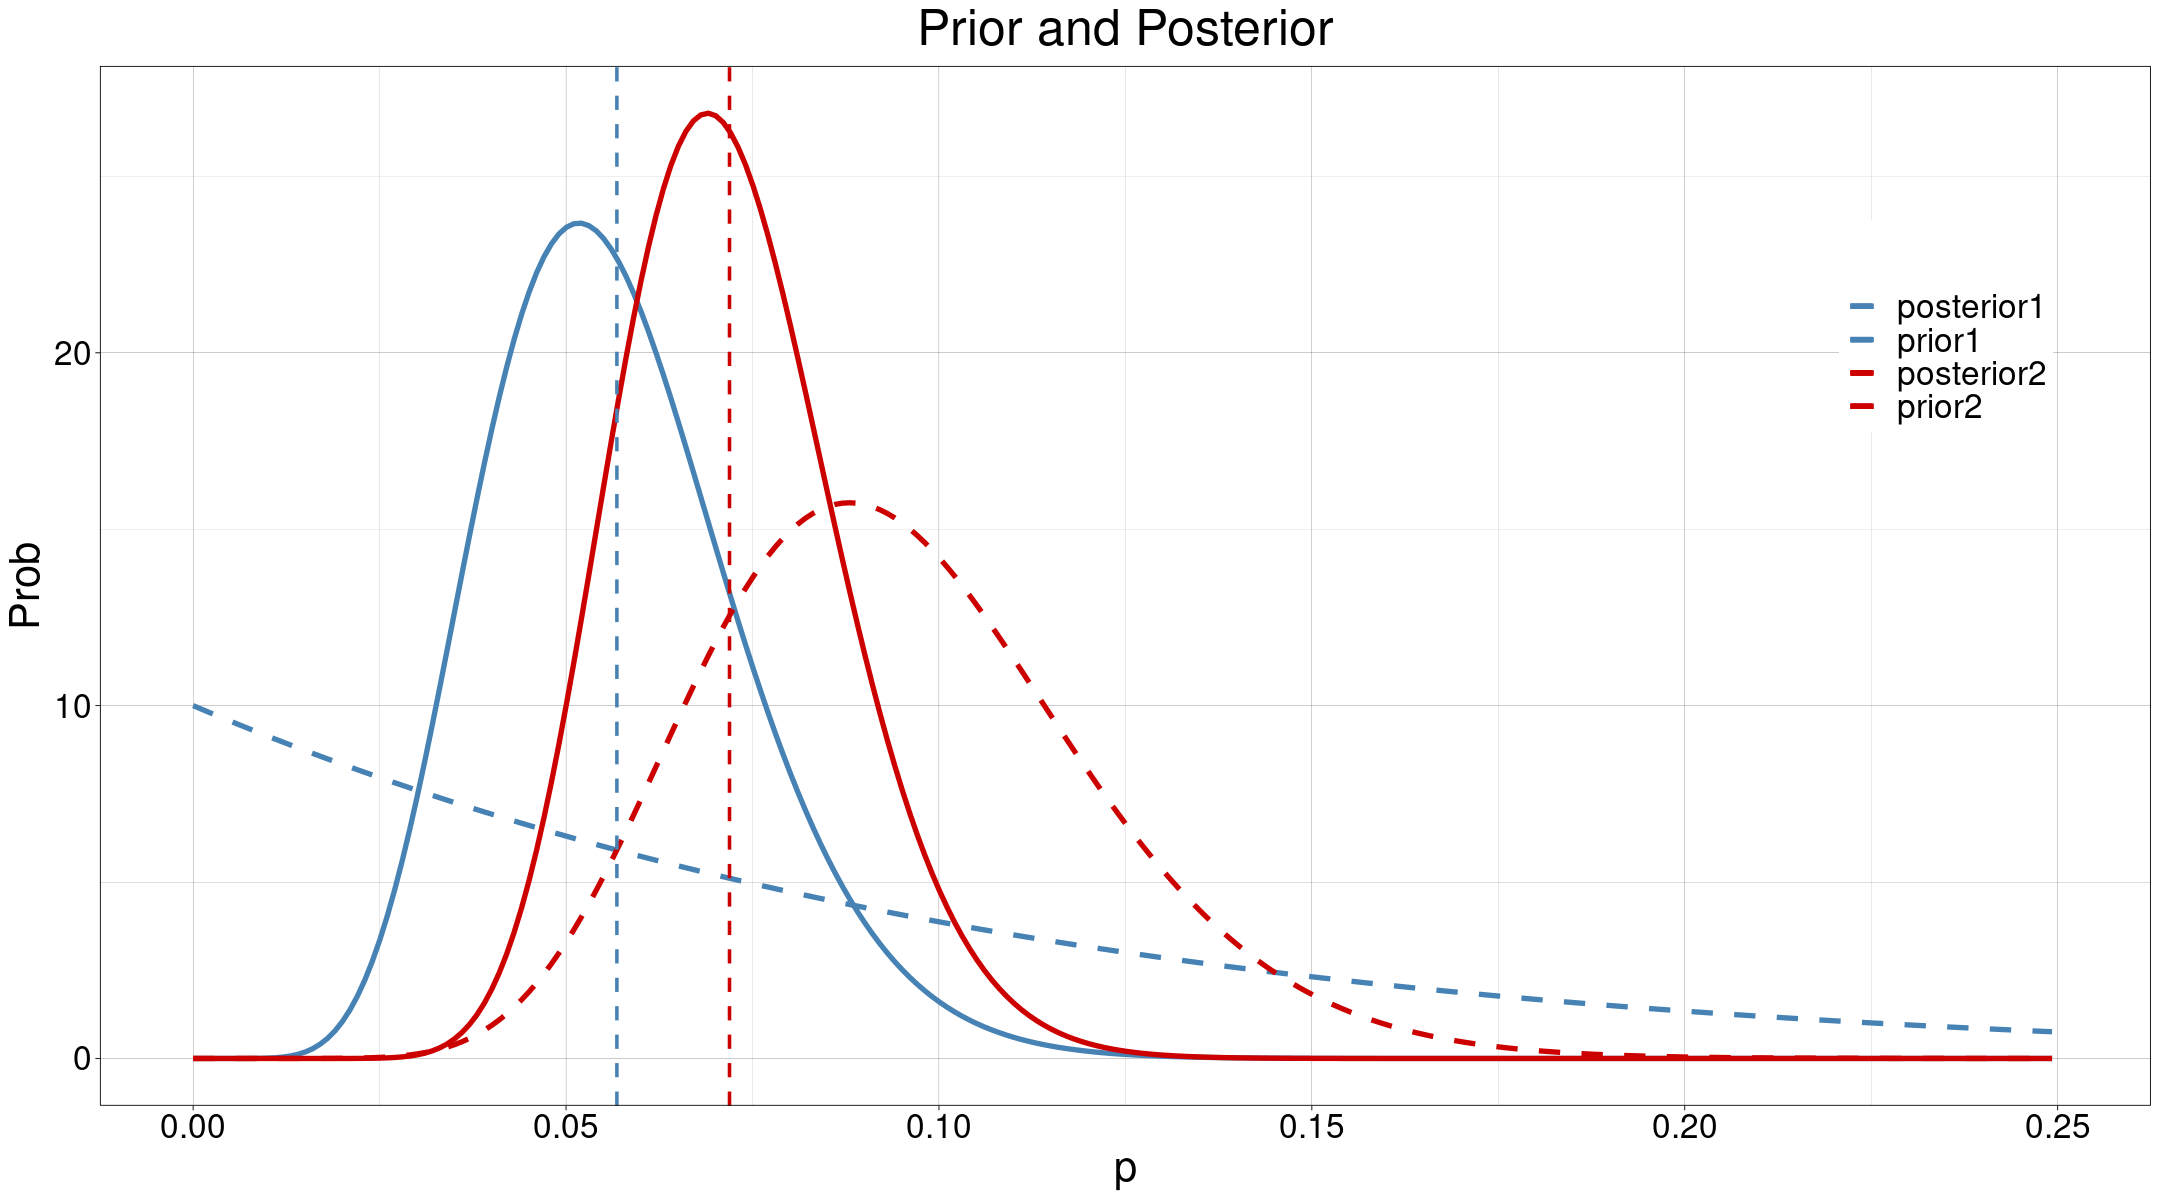

In [66]:
prior1 <- dbeta(p,alpha_prior1,beta_prior1)
prior2 <- dbeta(p,alpha_prior2,beta_prior2)

post1 <- dbeta(p,alpha_post1,beta_post1)
post2 <- dbeta(p,alpha_post2,beta_post2)

options(repr.plot.width=18, repr.plot.height=10)

plot <- ggplot() +
        geom_line(aes(x=p, y=post1, color="posterior1"),lwd=1.5) + 
        geom_line(aes(x=p, y=prior1, color="prior1"),linetype="dashed",lwd=1.5) +
        geom_line(aes(x=p, y=post2, color="posterior2"),lwd=1.5) + 
        geom_line(aes(x=p, y=prior2, color="prior2"),linetype="dashed",lwd=1.5) + 
        geom_vline(xintercept = mu_post1, linetype="dashed", color="steelblue", lwd=1) +
        geom_vline(xintercept = mu_post2, linetype="dashed", color="red3", lwd=1) +
        theme_linedraw() +
        xlim(0,0.25)+
        scale_color_manual(name = "", values = c("posterior1" = "steelblue","prior1" = "steelblue","posterior2" = "red3","prior2" = "red3"))+
        labs(title=glue("Prior and Posterior"), x="p",y="Prob")+
        theme(text = element_text(size=25), plot.title = element_text( hjust = 0.5),legend.position=c(.9,.75))
plot

In [73]:
cat("Uniform prior:\n")
cat("alpha posterior", alpha_post1,"\n")
cat("beta posterior", beta_post1,"\n")
cat("beta posterior mean", mu_post1,"\n")
cat("beta posterior std", std_post1,"\n")
cat("Creddibility interval [", low1,"-",high1,"]\n")
cat("-------------\nSecond Prior:\n")
cat("alpha posterior", alpha_post2,"\n")
cat("beta posterior", beta_post2,"\n")
cat("beta posterior mean", mu_post2,"\n")
cat("beta posterior std", std_post2,"\n")
cat("Creddibility interval [", low2,"-",high2,"]\n")


Uniform prior:
alpha posterior 10 
beta posterior 166 
beta posterior mean 0.05681818 
beta posterior std 0.01740022 
Creddibility interval [ 0.02773918 - 0.09538012 ]
-------------
Second Prior:
alpha posterior 21 
beta posterior 271 
beta posterior mean 0.07191781 
beta posterior std 0.01509307 
Creddibility interval [ 0.04522356 - 0.1041519 ]


Test the hypothesis: $H_0 : p=0.1$ and $H_1 \neq 0.1$

Warning message:
“Removed 932 rows containing missing values (position_stack).”
Warning message:
“Removed 972 rows containing missing values (position_stack).”
Warning message:
“Removed 796 rows containing missing values (position_stack).”
Warning message:
“Removed 700 row(s) containing missing values (geom_path).”


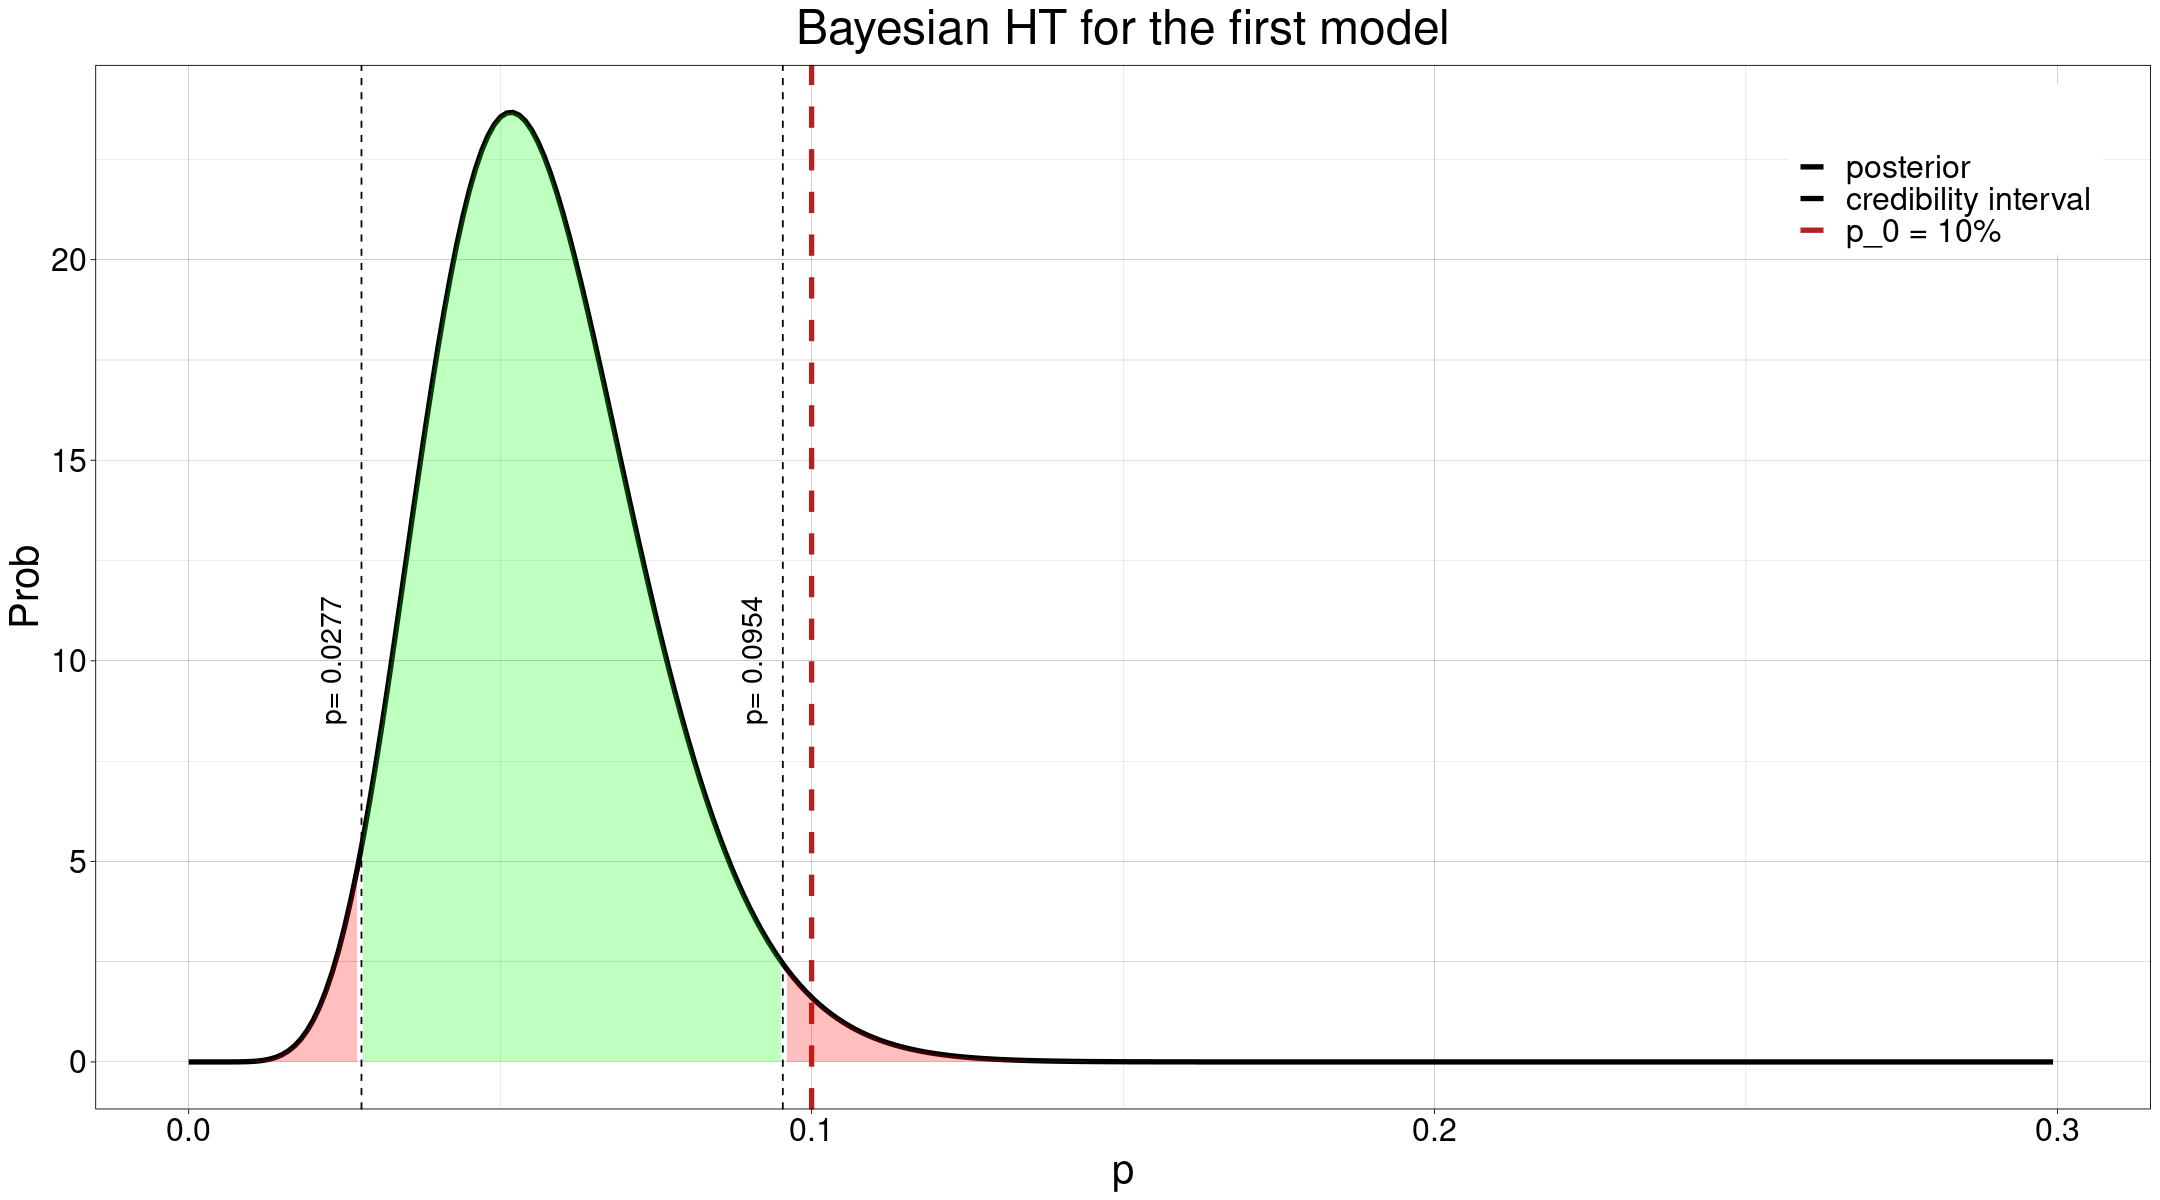

In [74]:
low1  <- qbeta(0.025, alpha_post1, beta_post1)
high1 <- qbeta(0.975, alpha_post1, beta_post1)

plot <- ggplot() +
        geom_line(aes(x=p, y=post1, color="posterior"),lwd=1.5) + 
        geom_vline(xintercept = p_h0, linetype="dashed", color="firebrick", lwd=1.5) +
        geom_vline(xintercept = low1, linetype="dashed", color="black") +
        geom_vline(xintercept = high1, linetype="dashed", color="black") +
        geom_area(aes(x = ifelse(p>low1 & p< high1 , p, 1), y=post1,), fill=adjustcolor("green",alpha.f=0.25))+
        geom_area(aes(x = ifelse(p<low1 , p, 1), y=post1,), fill=adjustcolor("red",alpha.f=0.25))+
        geom_area(aes(x = ifelse(p>high1 , p, 1), y=post1,), fill=adjustcolor("red",alpha.f=0.25))+
        theme_linedraw() +
        xlim(0,0.3)+
       
        annotate("text", x=low1-0.005, y=10, label= paste("p=",round(low1,4)),angle=90, size=6) + 
        annotate("text", x=high1-0.005, y=10, label= paste("p=",round(high1,4)),angle=90, size=6) + 
      
        scale_color_manual(name = "", values = c("posterior" = "black","credibility interval"="black", "p_0 = 10%" = "firebrick" ))+
        labs(title=glue("Bayesian HT for the first model"), x="p",y="Prob")+
        theme(text = element_text(size=24), plot.title = element_text( hjust = 0.5), legend.position=c(.9,.90))
plot



According to the new measurement and assuming the first posterior, the null hypotheses can be rejected at the $\alpha$ level of significance, as the plot above shows

Warning message:
“Removed 941 rows containing missing values (position_stack).”
Warning message:
“Removed 954 rows containing missing values (position_stack).”
Warning message:
“Removed 805 rows containing missing values (position_stack).”
Warning message:
“Removed 700 row(s) containing missing values (geom_path).”


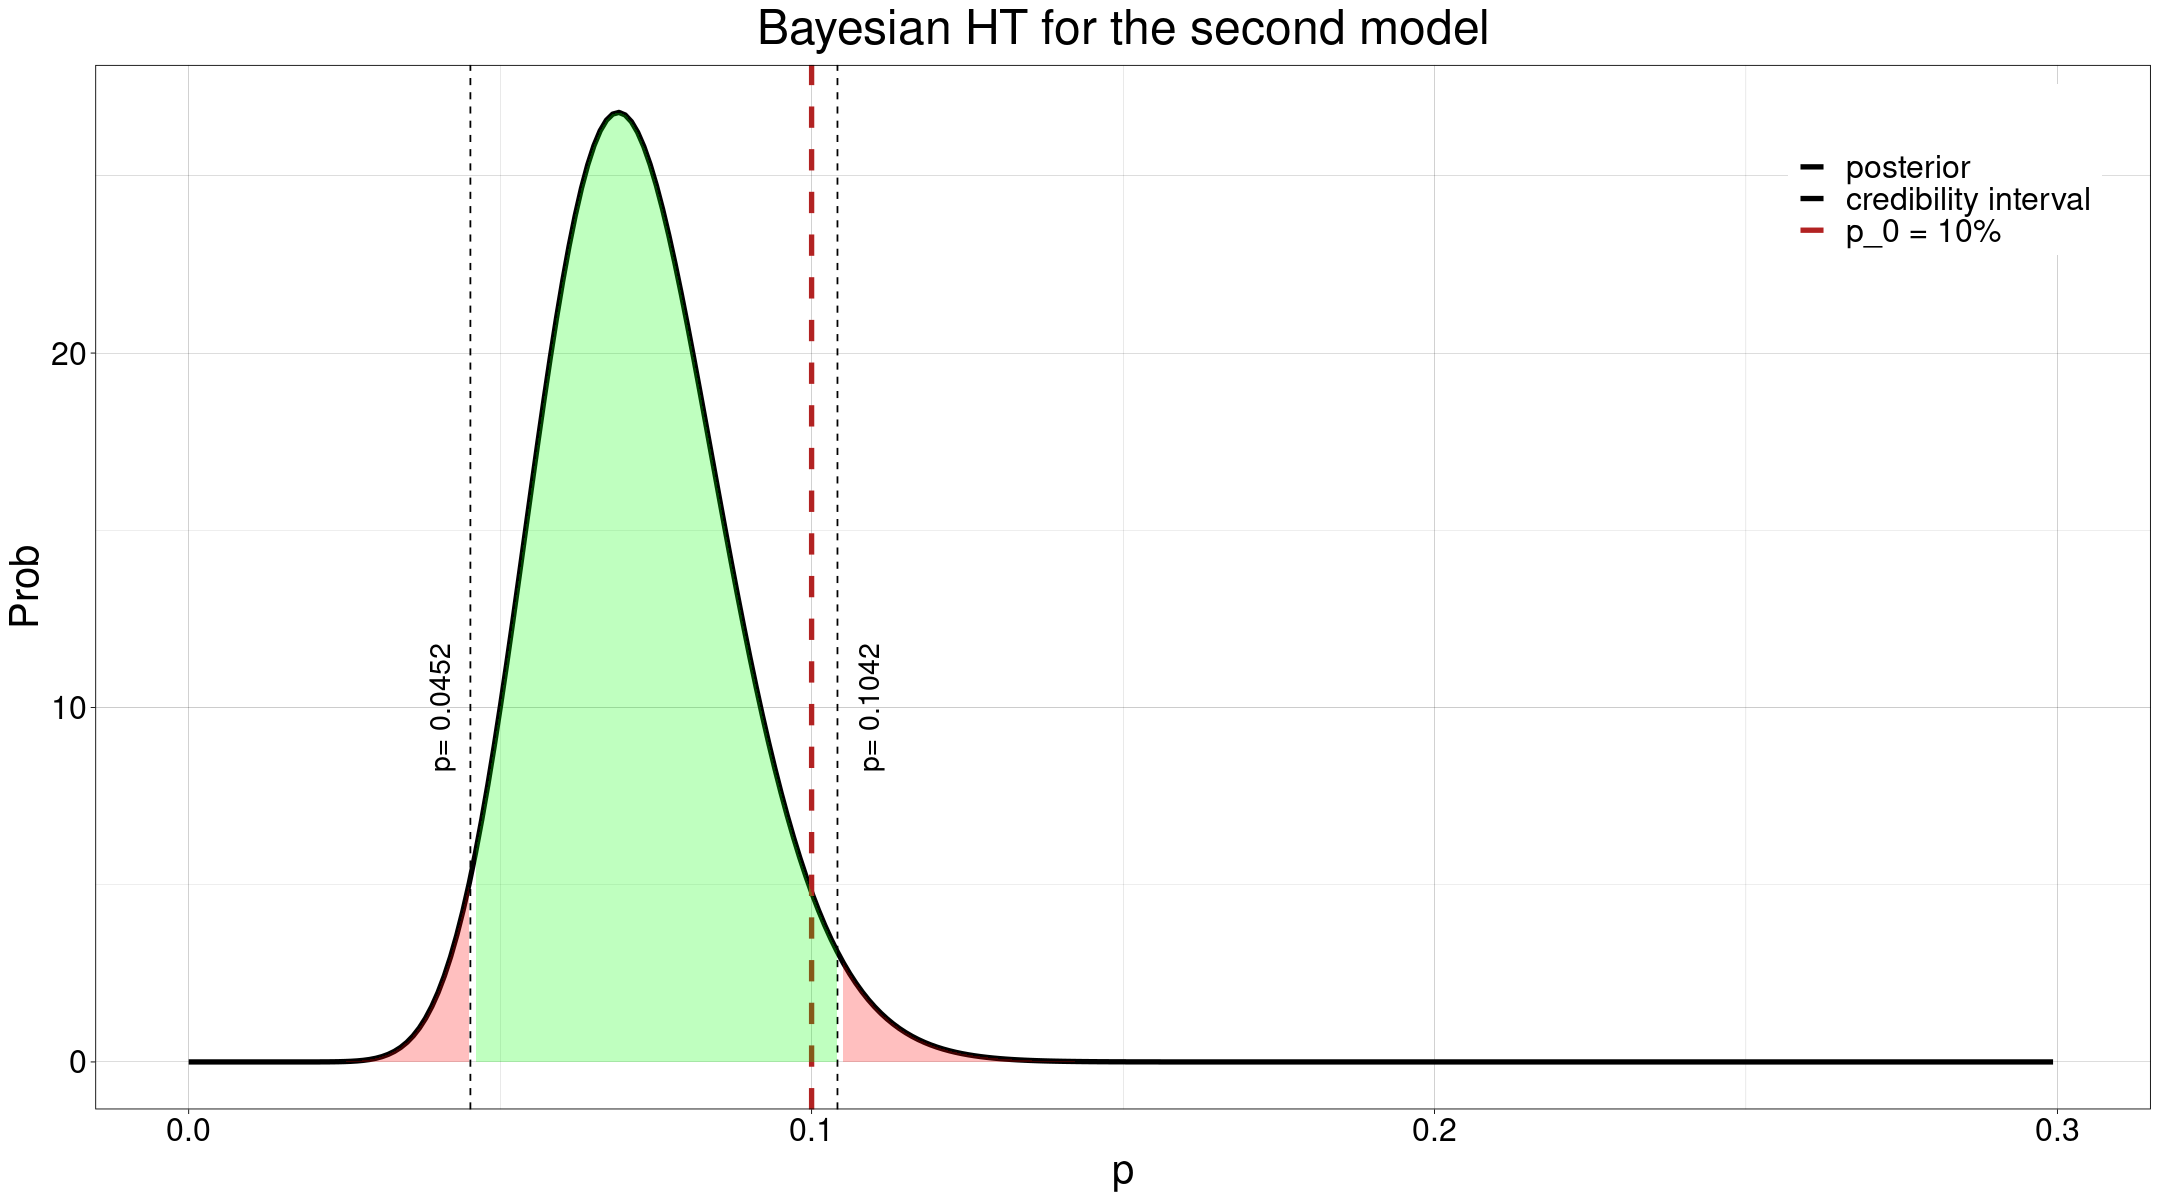

In [75]:
low2  <- qbeta(0.025, alpha_post2, beta_post2)
high2 <- qbeta(0.975, alpha_post2, beta_post2)


plot <- ggplot() +
        geom_line(aes(x=p, y=post2, color="posterior"),lwd=1.5) + 
        geom_vline(xintercept = p_h0, linetype="dashed", color="firebrick", lwd=1.5) +
        geom_vline(xintercept = low2, linetype="dashed", color="black") +
        geom_vline(xintercept = high2, linetype="dashed", color="black") +
        geom_area(aes(x = ifelse(p>low2 & p< high2 , p, 1), y=post2,), fill=adjustcolor("green",alpha.f=0.25))+
        geom_area(aes(x = ifelse(p<low2 , p, 1), y=post2,), fill=adjustcolor("red",alpha.f=0.25))+
        geom_area(aes(x = ifelse(p>high2 , p, 1), y=post2,), fill=adjustcolor("red",alpha.f=0.25))+
        theme_linedraw() +
        xlim(0,0.3)+
       
        annotate("text", x=low2-0.005, y=10, label= paste("p=",round(low2,4)),angle=90, size=6) + 
        annotate("text", x=high2+0.005, y=10, label= paste("p=",round(high2,4)),angle=90, size=6) + 
            
        scale_color_manual(name = "", values = c("posterior" = "black","credibility interval"="black", "p_0 = 10%" = "firebrick" ))+
        labs(title=glue("Bayesian HT for the second model"), x="p",y="Prob")+
        theme(text = element_text(size=24), plot.title = element_text( hjust = 0.5), legend.position=c(.9,.90))
plot



On the other hand, for the other posterior (more informative, if we believe the previous experiment on bacters has been done correctly), after the new measurement it is no longer possible to reject the null hypothesis with this level of significance.

### Frequentist

Warning message:
“Removed 135 rows containing missing values (position_stack).”
Warning message:
“Removed 1 rows containing missing values (geom_bar).”


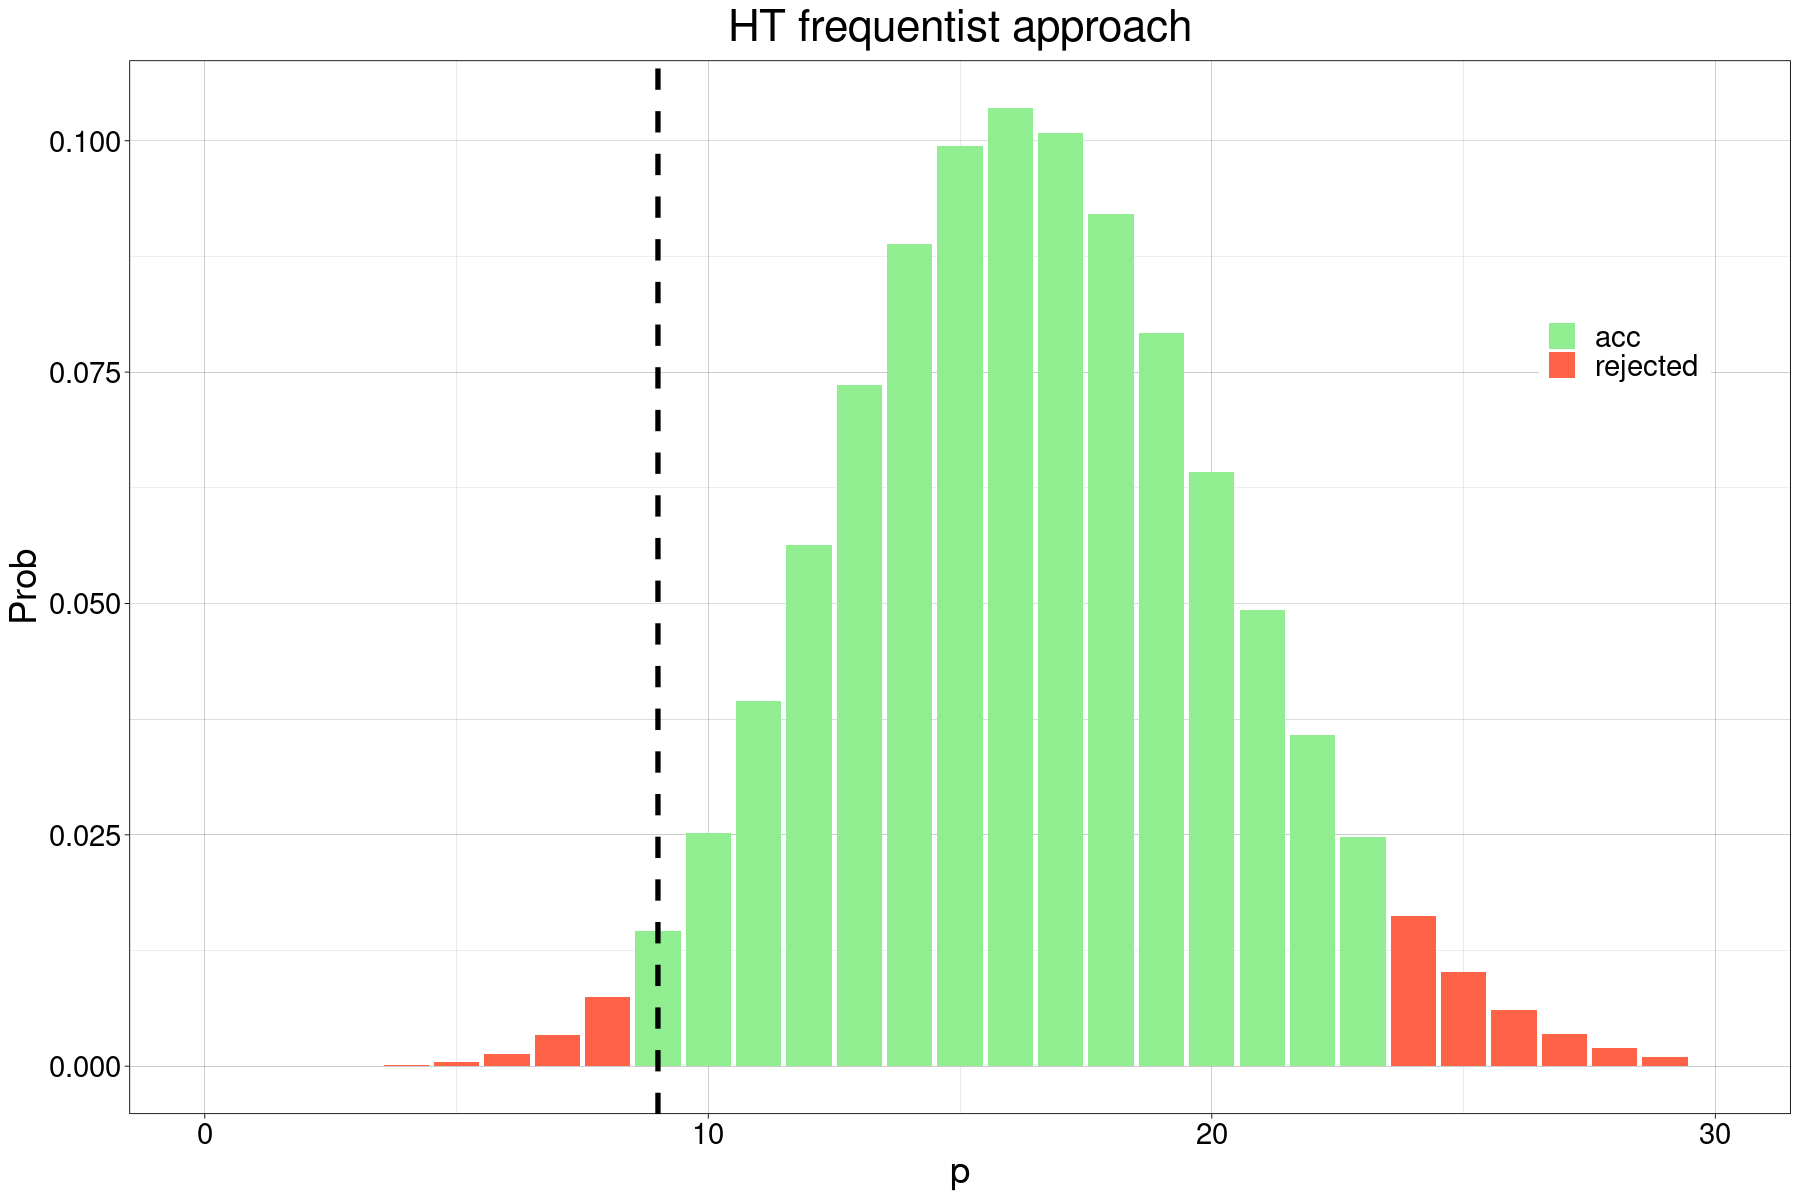

In [81]:
n <- 165
y <- 9
y_i <- 1:n

p_test <- pbinom(y_i, n, 0.1)

y_acc <- y_i[p_test > 0.025 & p_test < 0.975]
y_rej_left  <- y_i[p_test <= 0.025]
y_rej_right <- y_i[p_test >= 0.975]

pp_test <- dbinom(y_i, n, p_h0)
col <- c(rep("rejected",length(y_rej_left)),rep("acc",length(y_acc)),rep("rejected",length(y_rej_right)) )

df <- data.frame(y_i, pp_test,col)

options(repr.plot.width=15, repr.plot.height=10)

barp <- ggplot(df, aes(x=y_i, y=pp_test,fill=col)) +
        geom_bar(stat="identity")+
        geom_vline(xintercept = y, linetype="dashed", color="black", lwd=1.5) +
        theme_linedraw() +
        xlim(0,30)+
        scale_fill_manual(name="",values = c(adjustcolor("#90ee90",alpha.f=2),adjustcolor("tomato",alpha.f=1)) )+
        labs(title=glue("HT frequentist approach"), x="p",y="Prob")+
        theme(text = element_text(size=22), plot.title = element_text( hjust = 0.5), 
                legend.position=c(.9,.75))
barp


Finally, in the frequentist approach the test result states that the null hypothesis can't be rejected ad level of significance.

### Es4

In [6]:
library(rjags)

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



For the following exercizes I create the bug files named bug1/2/3 with respect to the exercize. All of them are organized in the same way: first we recall the data of the respective exercise and calculate the statistical parameters in the "classical" way. Then we call the MCMC to evaluate the posterior and its parameters and we compare the results of the same parameter. Finally we plot the results of the MCMC: plot chain, autocorrelation, density plot.

In [114]:
n   <- 75
y   <- 6

freq_prob <- y/n

mu  <- 0.15
std <- 0.14
alpha <- - mu * (std^2 + mu^2 - mu) / std^2
beta  <- (std^2 + mu^2 - mu)*(mu - 1) / std^2

#posterior is a Beta distribution but with the following alpha and beta values
alpha_post <- alpha + y
beta_post  <- beta + n - y

n_sample <- 200
p     <- seq(0,1, length.out=n_sample)
beta_distr <- dbeta(p, alpha_post, beta_post) #/ (sum(dbeta(p, alpha_post, beta_post)) / n_sample )

mu_post  <- alpha_post / (alpha_post + beta_post)
std_post <- sqrt((alpha_post*beta_post)/((alpha_post+beta_post)^2*(alpha_post+beta_post+1)))

In [115]:
data1 <- NULL
data1$alpha <- alpha
data1$beta  <- beta

data1$X <- y
data1$n <- n

model <- "bug1.bug"
jm <- jags.model(model,data1)
update(jm, 1000)
chain <- coda.samples(jm, c("p"), n.iter=10000)
print(summary(chain))


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1
   Unobserved stochastic nodes: 1
   Total graph size: 5

Initializing model


Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.0847836      0.0306847      0.0003068      0.0004036 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.03492 0.06240 0.08184 0.10345 0.15318 



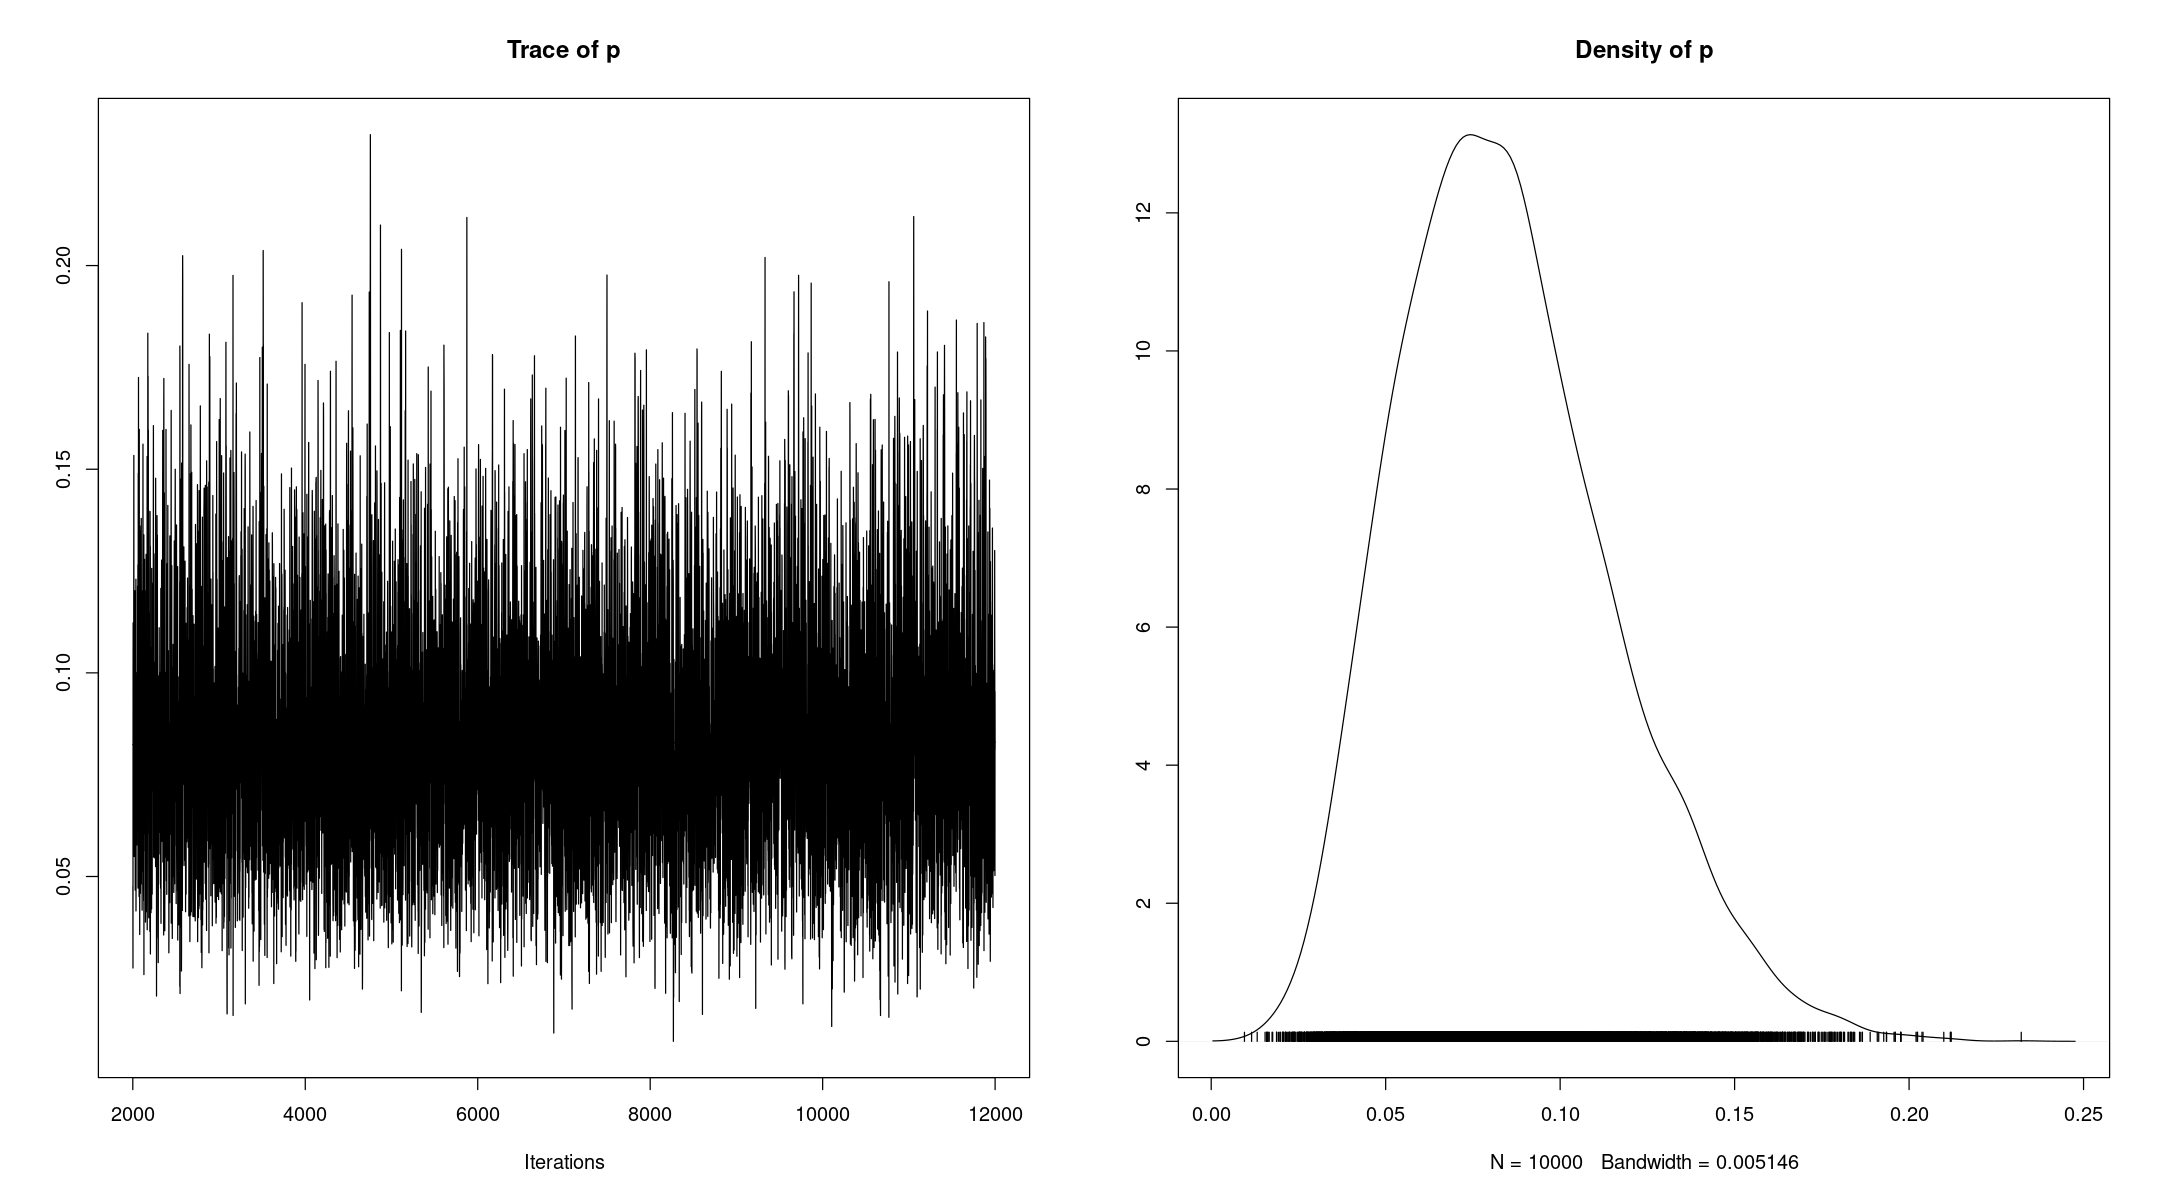

In [116]:
options(repr.plot.width=18, repr.plot.height=10)
plot(chain)

In [118]:
mean_post <- unname(summary(chain)$statistics["Mean"])
std_jpost <- unname(summary(chain)$statistics["SD"])
CI_jpost <- unname(summary(chain)$quantiles[c("2.5%","97.5%")])
CI_post  <- c(qbeta(0.025, alpha_post, beta_post), qbeta(0.975, alpha_post, beta_post))

cat("mean computed by JAGS", mean_post,"\n")
cat("mean computed analitically", mu_post,"\n","-----\n")
cat("std computed by JAGS", std_jpost,"\n")
cat("std computed analitically", std_post,"\n","-----\n")
cat("95% credibility interval computed by JAGS", CI_jpost,"\n")
cat("95% credibility interval computed analitically", CI_post,"\n")

mean computed by JAGS 0.08478356 
mean computed analitically 0.08478674 
 -----
std computed by JAGS 0.03068465 
std computed analitically 0.03085551 
 -----
95% credibility interval computed by JAGS 0.03492042 0.1531752 
95% credibility interval computed analitically 0.03472224 0.1542349 


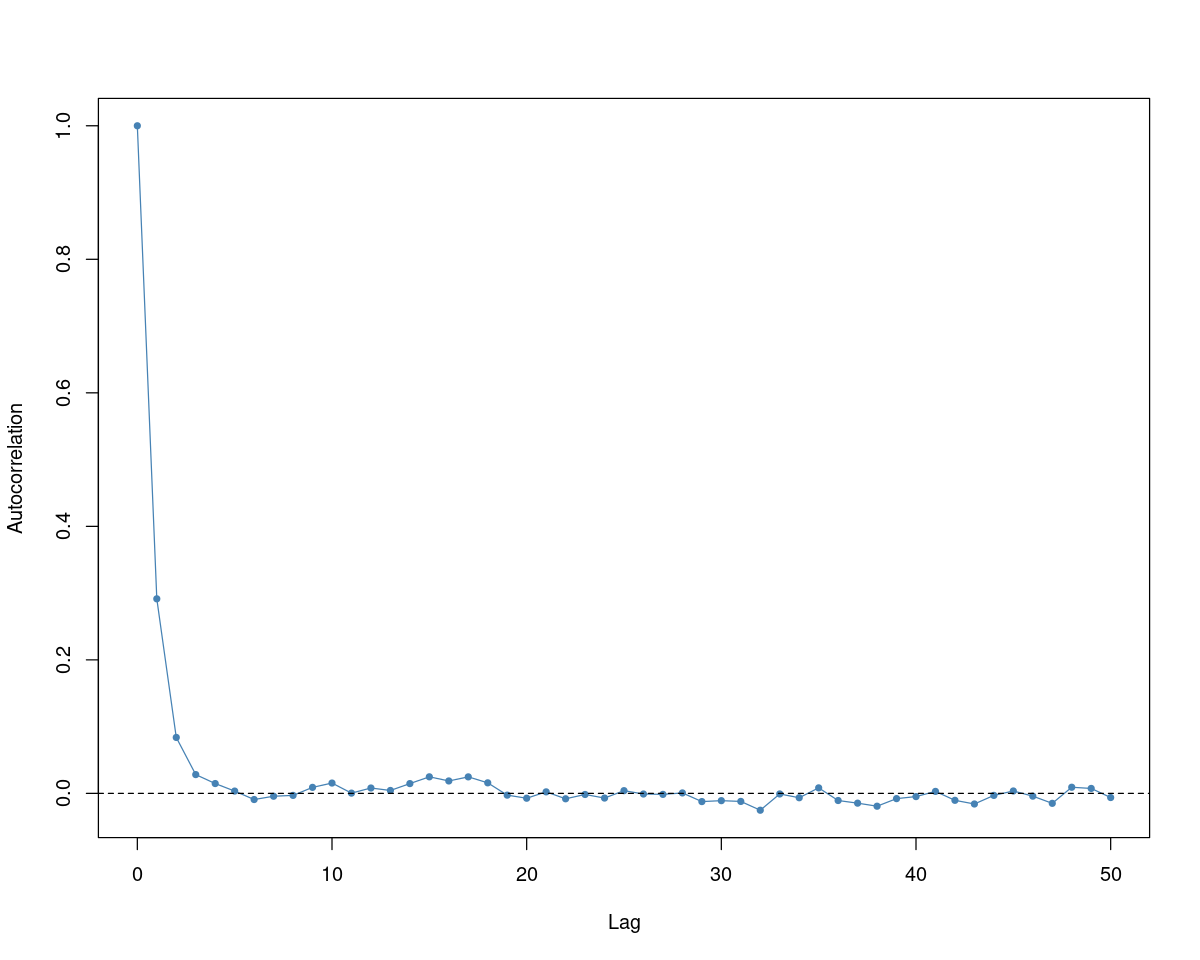

In [69]:
# plot autocorrelation
options(repr.plot.width=10, repr.plot.height=8)

l = c(0:50)
plot(x=l, y=unname(autocorr(chain, lags=l))[[1]], type = 'o', pch = 20, col = "steelblue", cex = 1, lwd = 1,
     main = "", xlab = "Lag", ylab = "Autocorrelation")
abline(h=0, lty="dashed")

Warning message:
“Removed 281 rows containing missing values (position_stack).”


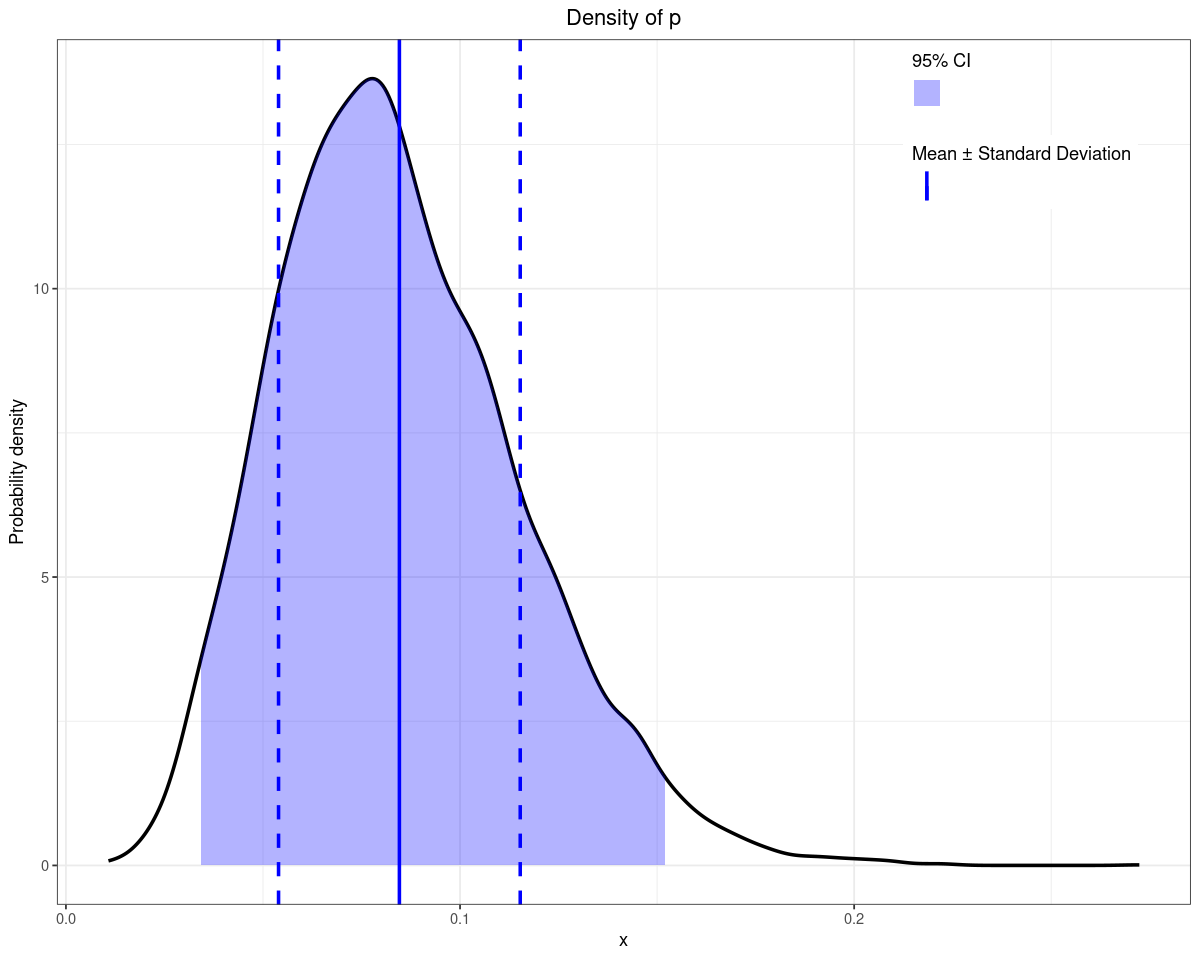

In [89]:
density_df <- ggplot_build(ggplot() + geom_density(data=as_tibble(as.mcmc(chain)), mapping=aes(x=p)))$data[[1]][c("x","y")]

plot <- ggplot() +
        geom_line(mapping=aes(x=x, y=y), data=density_df, size=1) +
        geom_vline(mapping=aes(xintercept=mean_post, color=""), size=1) +
        geom_vline(mapping=aes(xintercept=c(mean_post+std_jpost,mean_post-std_jpost), color=""), linetype="dashed", size=1) +
        geom_area(data=density_df,
                  aes(x=ifelse(x>=CI_jpost[1] & x<=CI_jpost[2], x, NA), fill="", y=y),
                  alpha=0.3) +
        labs(title="Density of p") +
        scale_y_continuous(name="Probability density") +
        scale_fill_manual(values="blue", name="95% CI") +
        scale_colour_manual(values=rep("blue",2), name="Mean ± Standard Deviation") +
        theme_bw() +
        theme(plot.title=element_text(hjust=0.5),legend.position=c(.85,.90))
plot

### Es5

We first reload the parameter of the exercize 2 and calculate again the statistical parameters. We divide the exercize into 4 parts, divided with respect to the prior (uniform or Jeffryes) and to the dataset

### Analisis with Jeffryes prior

In [191]:
n1 <- c(109,65,22,3,1,0)
n2 <- c(144,91,32,11,2,0)
y_death <- 0:4
deaths1 <- NULL; deaths2 <- NULL 

for (i in 1:5) {
    deaths1 <- append(deaths1, values = rep(y_death[i], times = n1[i]))
    deaths2 <- append(deaths2, values = rep(y_death[i], times = n2[i]))
}

alpha_u1 <- sum(deaths1) + 1
alpha_u2 <- sum(deaths2) + 1
lambda1  <- length(deaths1)
lambda2  <- length(deaths2)

mean_u1 <- alpha_u1/lambda1; var_u1 <- alpha_u1/lambda1^2 
u1_low  <- qgamma(0.025, alpha_u1, lambda1); u1_high <- qgamma(0.975, alpha_u1, lambda1)


In [192]:
data2a <- NULL
data2a$alpha  <- 1
data2a$lambda <- 0.000001

data2a$X <- deaths1

model <- "bug2.bug"
jm <- jags.model(model,data2a)
update(jm, 1000)
chain_u1 <- coda.samples(jm, c("p","y"), n.iter=10000)
print(summary(chain_u1))


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 1
   Total graph size: 203

Initializing model



Warning message in FUN(X[[i]], ...):
“Failed to set trace monitor for y
Variable y not found
”



Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.6156611      0.0553753      0.0005538      0.0005538 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
0.5119 0.5772 0.6137 0.6527 0.7284 



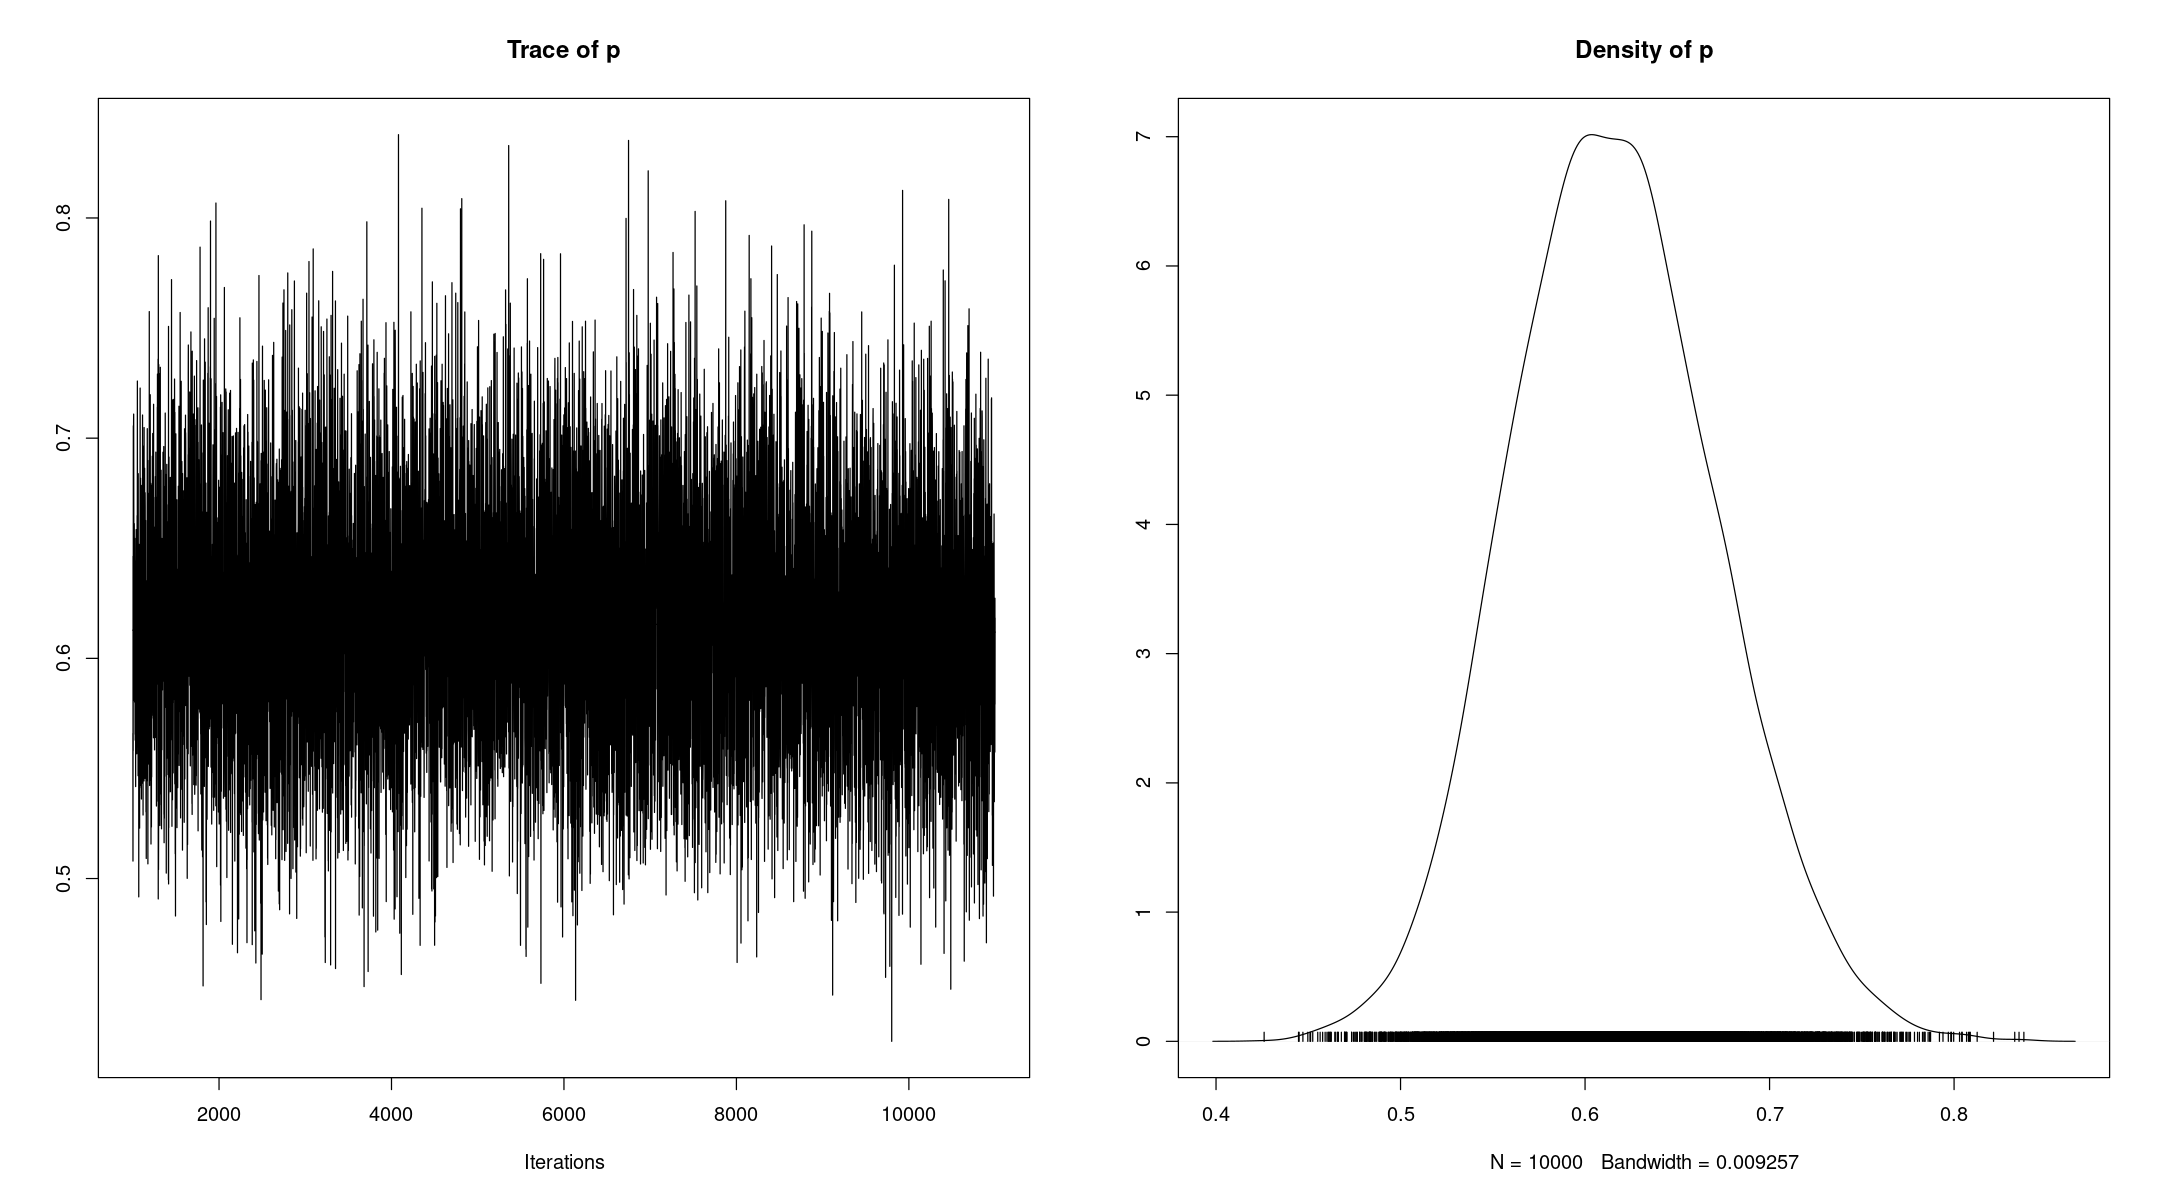

In [193]:
options(repr.plot.width=18, repr.plot.height=10)
plot(chain_u)

In [194]:
mean_post1 <- unname(summary(chain_u2)$statistics["Mean"])
std_jpost1 <- unname(summary(chain_u2)$statistics["SD"])
CI_jpost1 <- unname(summary(chain_u2)$quantiles[c("2.5%","97.5%")])

cat("mean computed by JAGS", mean_post1,"\n")
cat("mean computed analitically", mean_u1,"\n","-----\n")
cat("std computed by JAGS", std_jpost1,"\n")
cat("std computed analitically", sqrt(var_u1),"\n","-----\n")
cat("95% credibility interval computed by JAGS", CI_jpost1,"\n")
cat("95% credibility interval computed analitically", c(u1_low,u1_high),"\n")

mean computed by JAGS 0.6144158 
mean computed analitically 0.615 
 -----
std computed by JAGS 0.05612363 
std computed analitically 0.05545268 
 -----
95% credibility interval computed by JAGS 0.5087904 0.7276779 
95% credibility interval computed analitically 0.5111251 0.7283408 


In [195]:
data2b <- NULL
data2b$alpha  <- 1
data2b$lambda <- 0.000001

data2b$X <- deaths2
data2b$n <- n

model <- "bug2.bug"
jm <- jags.model(model,data2b)
update(jm, 1000)
chain_u2 <- coda.samples(jm, c("p"), n.iter=10000)
print(summary(chain_u2))


Warning message in jags.model(model, data2b):
“Unused variable "n" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 280
   Unobserved stochastic nodes: 1
   Total graph size: 283

Initializing model


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.7027235      0.0505063      0.0005051      0.0005051 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
0.6067 0.6682 0.7011 0.7355 0.8049 



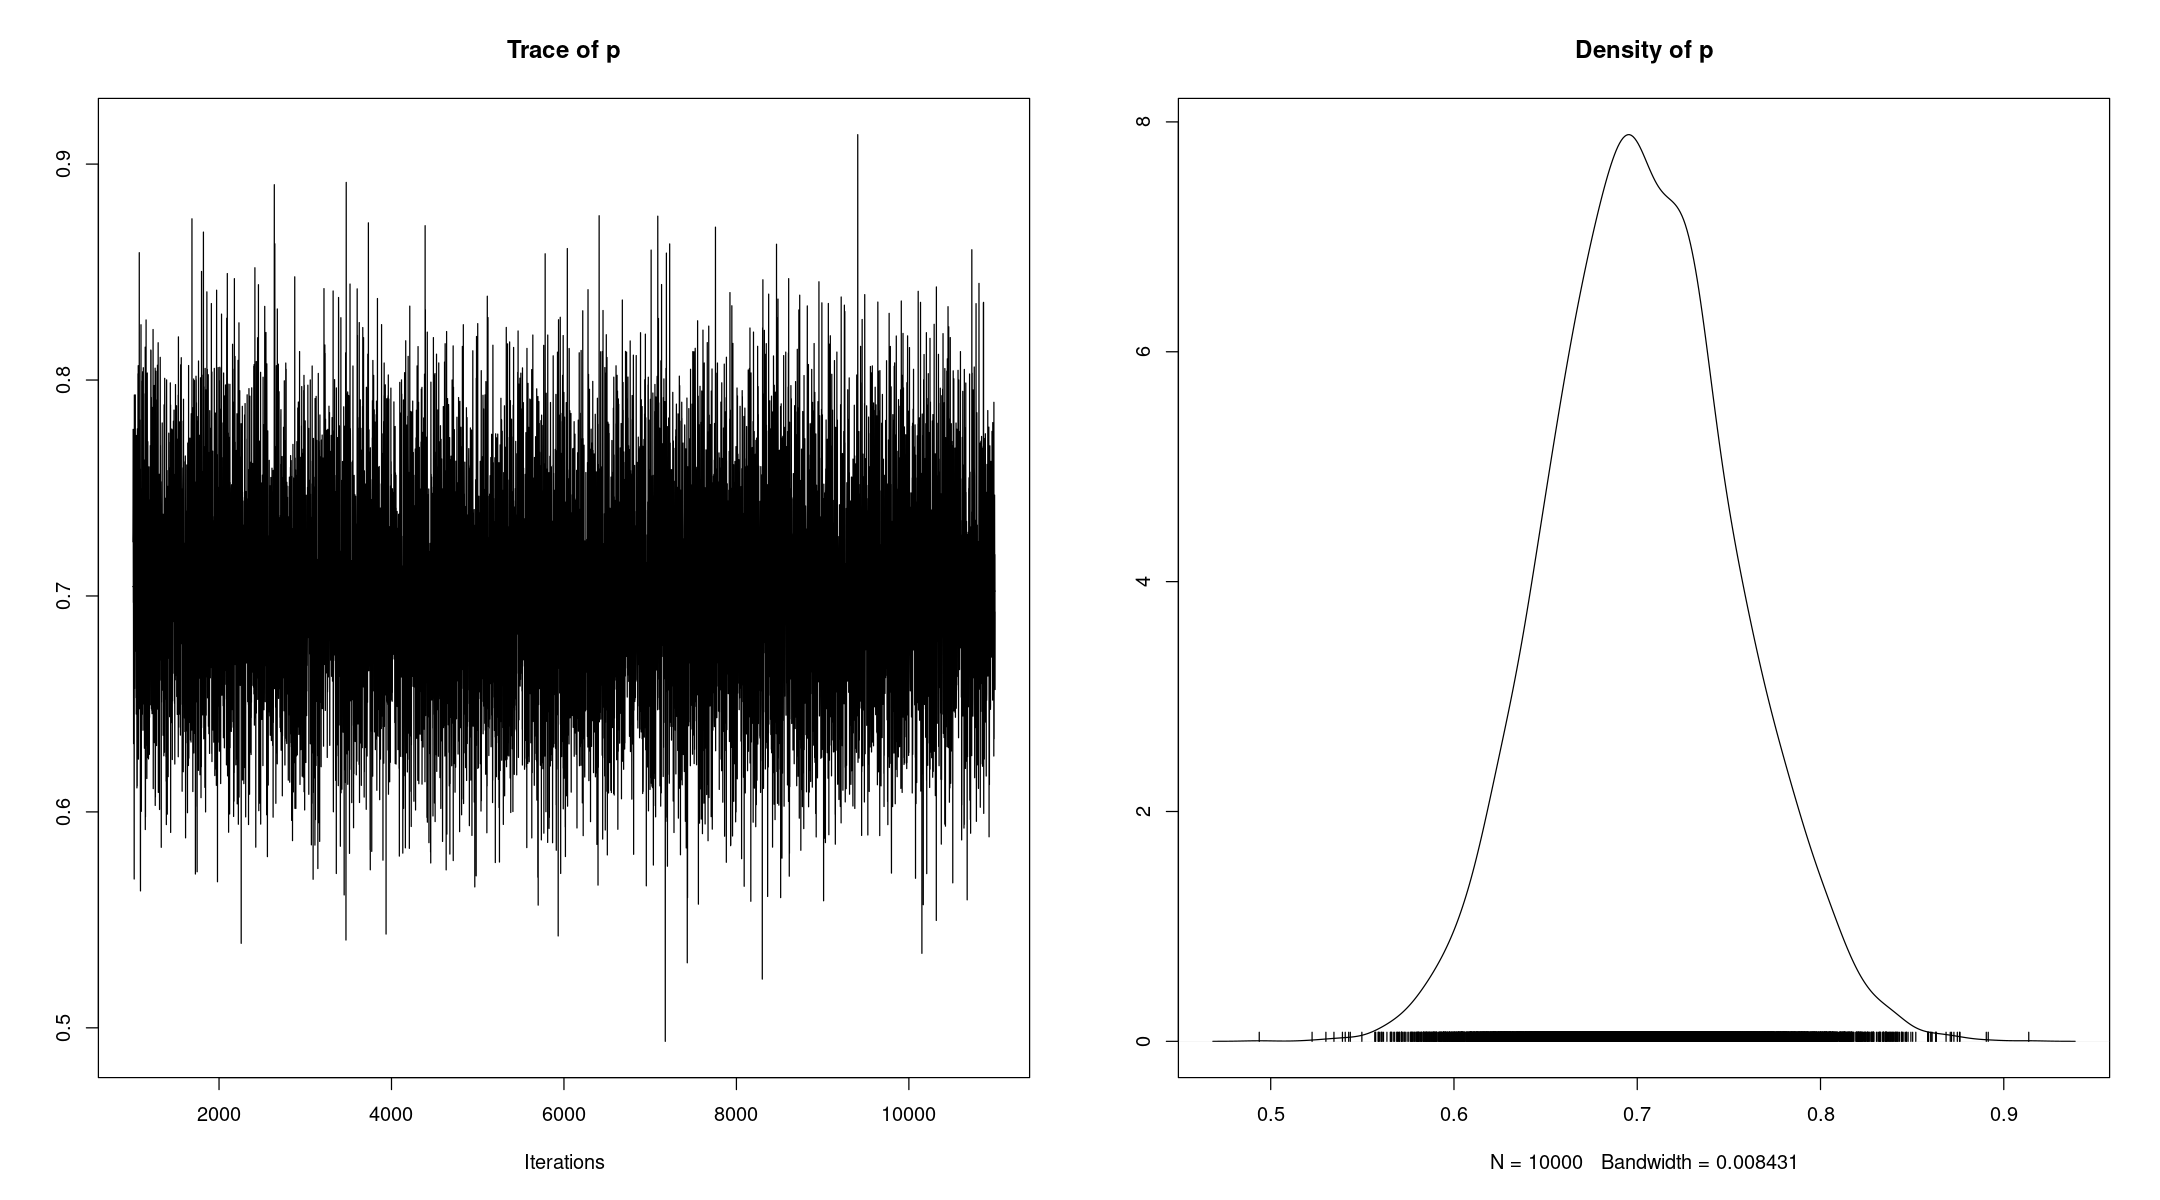

In [196]:
options(repr.plot.width=18, repr.plot.height=10)
plot(chain_u2)

In [197]:
mean_u2 <- alpha_u2/lambda2; var_u2 <- alpha_u2/lambda2^2 
u2_low  <- qgamma(0.025, alpha_u2, lambda2); u2_high <- qgamma(0.975, alpha_u2, lambda2)

mean_post2 <- unname(summary(chain_u2)$statistics["Mean"])
std_jpost2 <- unname(summary(chain_u2)$statistics["SD"])
CI_jpost2  <- unname(summary(chain_u2)$quantiles[c("2.5%","97.5%")])

cat("mean computed by JAGS", mean_post2,"\n")
cat("mean computed analitically", mean_u2,"\n","-----\n")
cat("std computed by JAGS", std_jpost2,"\n")
cat("std computed analitically", sqrt(var_u2),"\n","-----\n")
cat("95% credibility interval computed by JAGS", CI_jpost2,"\n")
cat("95% credibility interval computed analitically", c(u2_low,u2_high),"\n")

mean computed by JAGS 0.7027235 
mean computed analitically 0.7035714 
 -----
std computed by JAGS 0.0505063 
std computed analitically 0.05012739 
 -----
95% credibility interval computed by JAGS 0.6066547 0.8049042 
95% credibility interval computed analitically 0.6087487 0.805157 


Warning message:
“Removed 237 rows containing missing values (position_stack).”


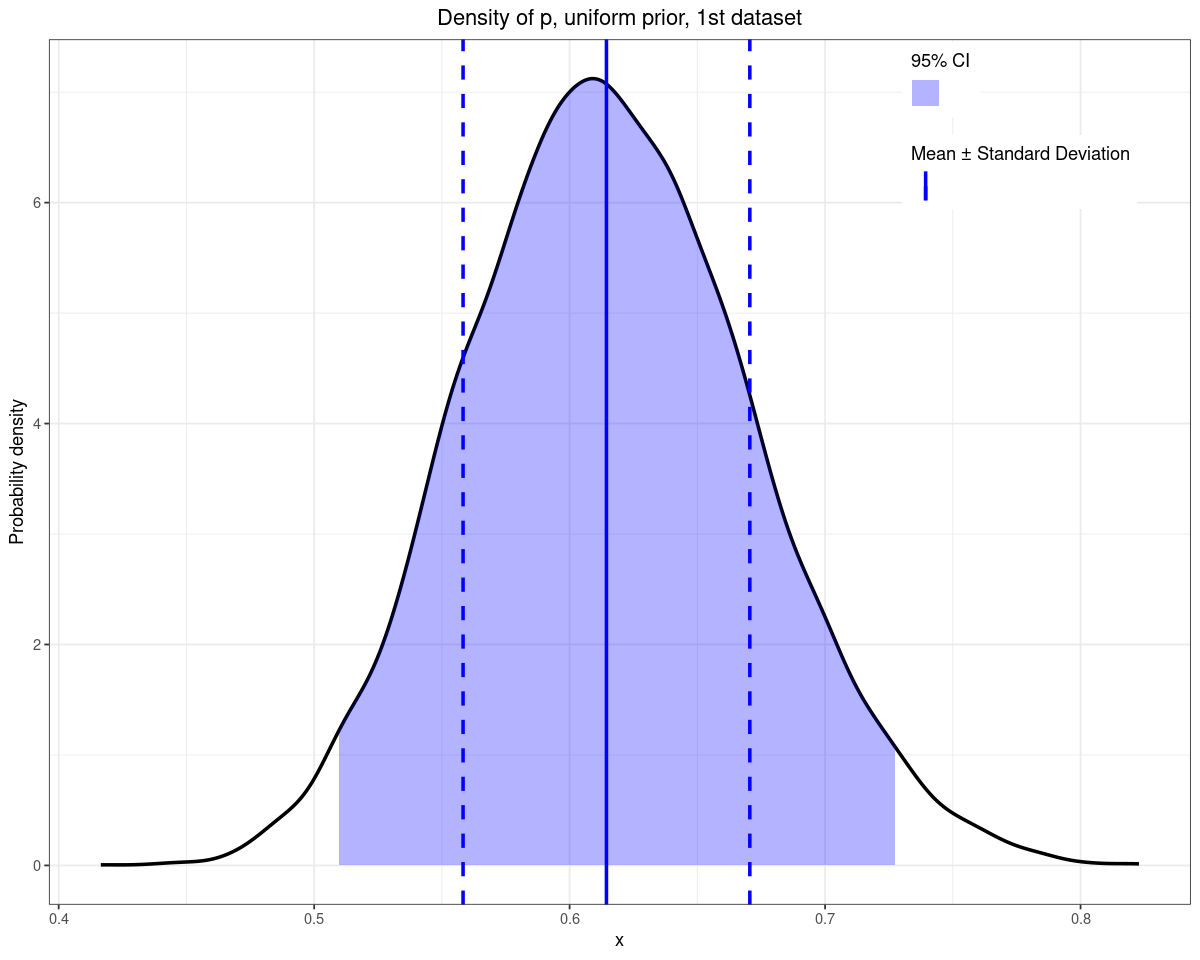

In [198]:
density_df_u1 <- ggplot_build(ggplot() + geom_density(data=as_tibble(as.mcmc(chain_u1)), mapping=aes(x=p)))$data[[1]][c("x","y")]
density_df_u2 <- ggplot_build(ggplot() + geom_density(data=as_tibble(as.mcmc(chain_u2)), mapping=aes(x=p)))$data[[1]][c("x","y")]

options(repr.plot.width=10, repr.plot.height=8)

plot <- ggplot() +
        geom_line(mapping=aes(x=x, y=y), data=density_df_u1, size=1) +
        geom_vline(mapping=aes(xintercept=mean_post1, color=""), size=1) +
        geom_vline(mapping=aes(xintercept=c(mean_post1+std_jpost1,mean_post1-std_jpost1), color=""), linetype="dashed", size=1) +
        geom_area(data=density_df_u1,
                  aes(x=ifelse(x>=CI_jpost1[1] & x<=CI_jpost1[2], x, NA), fill="", y=y),
                  alpha=0.3) +

        labs(title="Density of p, uniform prior, 1st dataset") +
        scale_y_continuous(name="Probability density") +
        scale_fill_manual(values="blue", name="95% CI") +
        scale_colour_manual(values=rep("blue",2), name="Mean ± Standard Deviation") +
        theme_bw() +
        theme(plot.title=element_text(hjust=0.5),legend.position=c(.85,.90))
plot


Warning message:
“Removed 271 rows containing missing values (position_stack).”


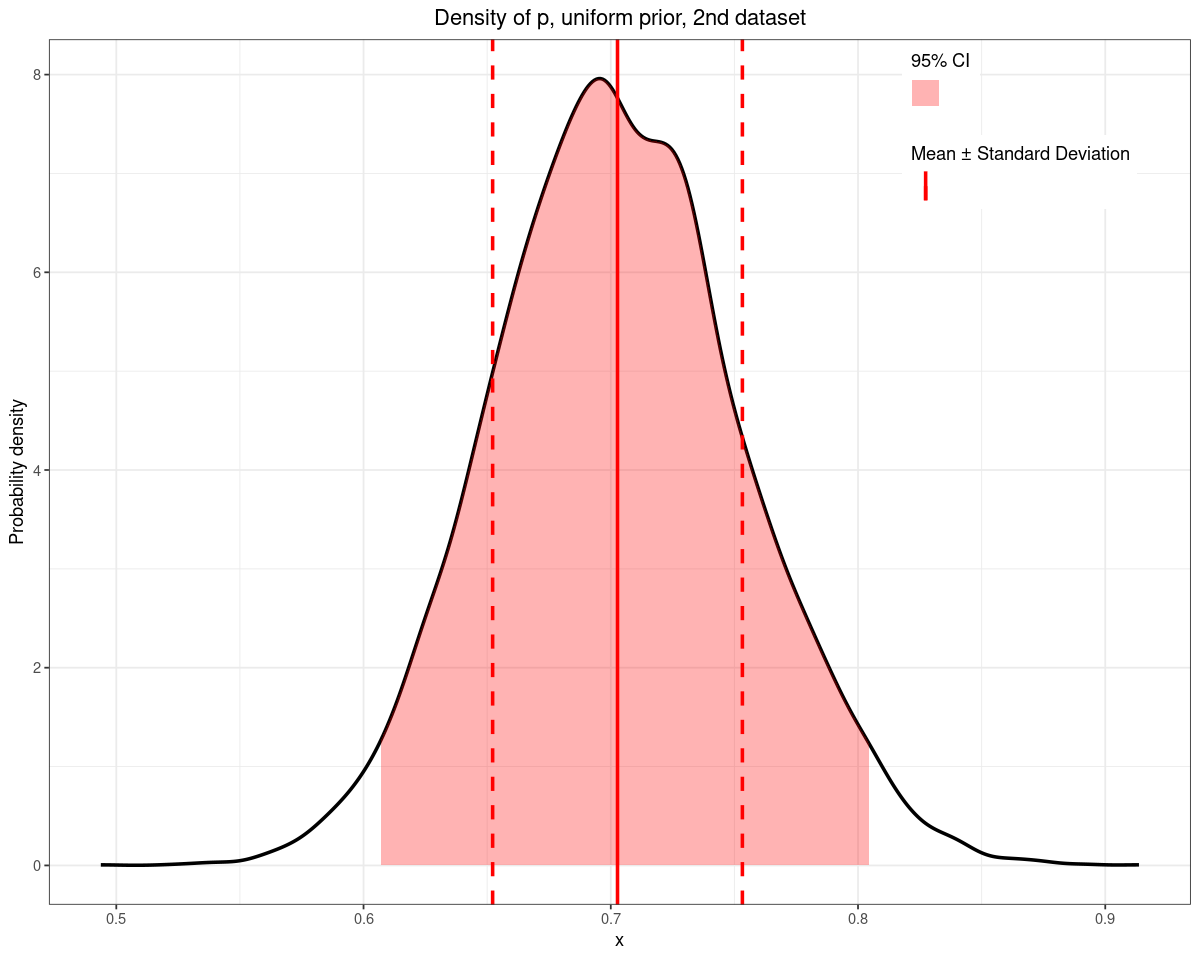

In [199]:
plot <- ggplot() +
        geom_line(mapping=aes(x=x, y=y), data=density_df_u2, size=1) +
        geom_vline(mapping=aes(xintercept=mean_post2, color=""), size=1) +
        geom_vline(mapping=aes(xintercept=c(mean_post2+std_jpost2,mean_post2-std_jpost2), color=""), linetype="dashed", size=1) +
        geom_area(data=density_df_u2,
                  aes(x=ifelse(x>=CI_jpost2[1] & x<=CI_jpost2[2], x, NA), fill="", y=y),
                  alpha=0.3) +
        labs(title="Density of p, uniform prior, 2nd dataset") +
        scale_y_continuous(name="Probability density") +
        scale_fill_manual(values="red", name="95% CI") +
        scale_colour_manual(values=rep("red",2), name="Mean ± Standard Deviation") +
        theme_bw() +
        theme(plot.title=element_text(hjust=0.5),legend.position=c(.85,.90))
plot        


### Analisis with Jeffryes prior

first dataset

In [201]:
alpha_j1 <- sum(deaths1) + 0.5
alpha_j2 <- sum(deaths2) + 0.5

mean_j1 <- alpha_j1/lambda1; var_j1 <- alpha_j1/lambda1^2 
mean_j2 <- alpha_j2/lambda2; var_j2 <- alpha_j2/lambda2^2 

j1_low  <- qgamma(0.025, alpha_j1, lambda1); j1_high <- qgamma(0.975, alpha_j1, lambda1)
j2_low  <- qgamma(0.025, alpha_j2, lambda2); j2_high <- qgamma(0.975, alpha_j2, lambda2)


In [202]:
data2c <- NULL
data2c$alpha  <- 0.5
data2c$lambda <- 0.000001

data2c$X <- deaths1
data2c$n <- n

model <- "bug2.bug"
jm <- jags.model(model,data2c)
update(jm, 1000)
chain_j1 <- coda.samples(jm, c("p"), n.iter=10000)
print(summary(chain_j1))


Warning message in jags.model(model, data2c):
“Unused variable "n" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 1
   Total graph size: 203

Initializing model


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.6131437      0.0553063      0.0005531      0.0005531 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
0.5091 0.5744 0.6118 0.6506 0.7248 



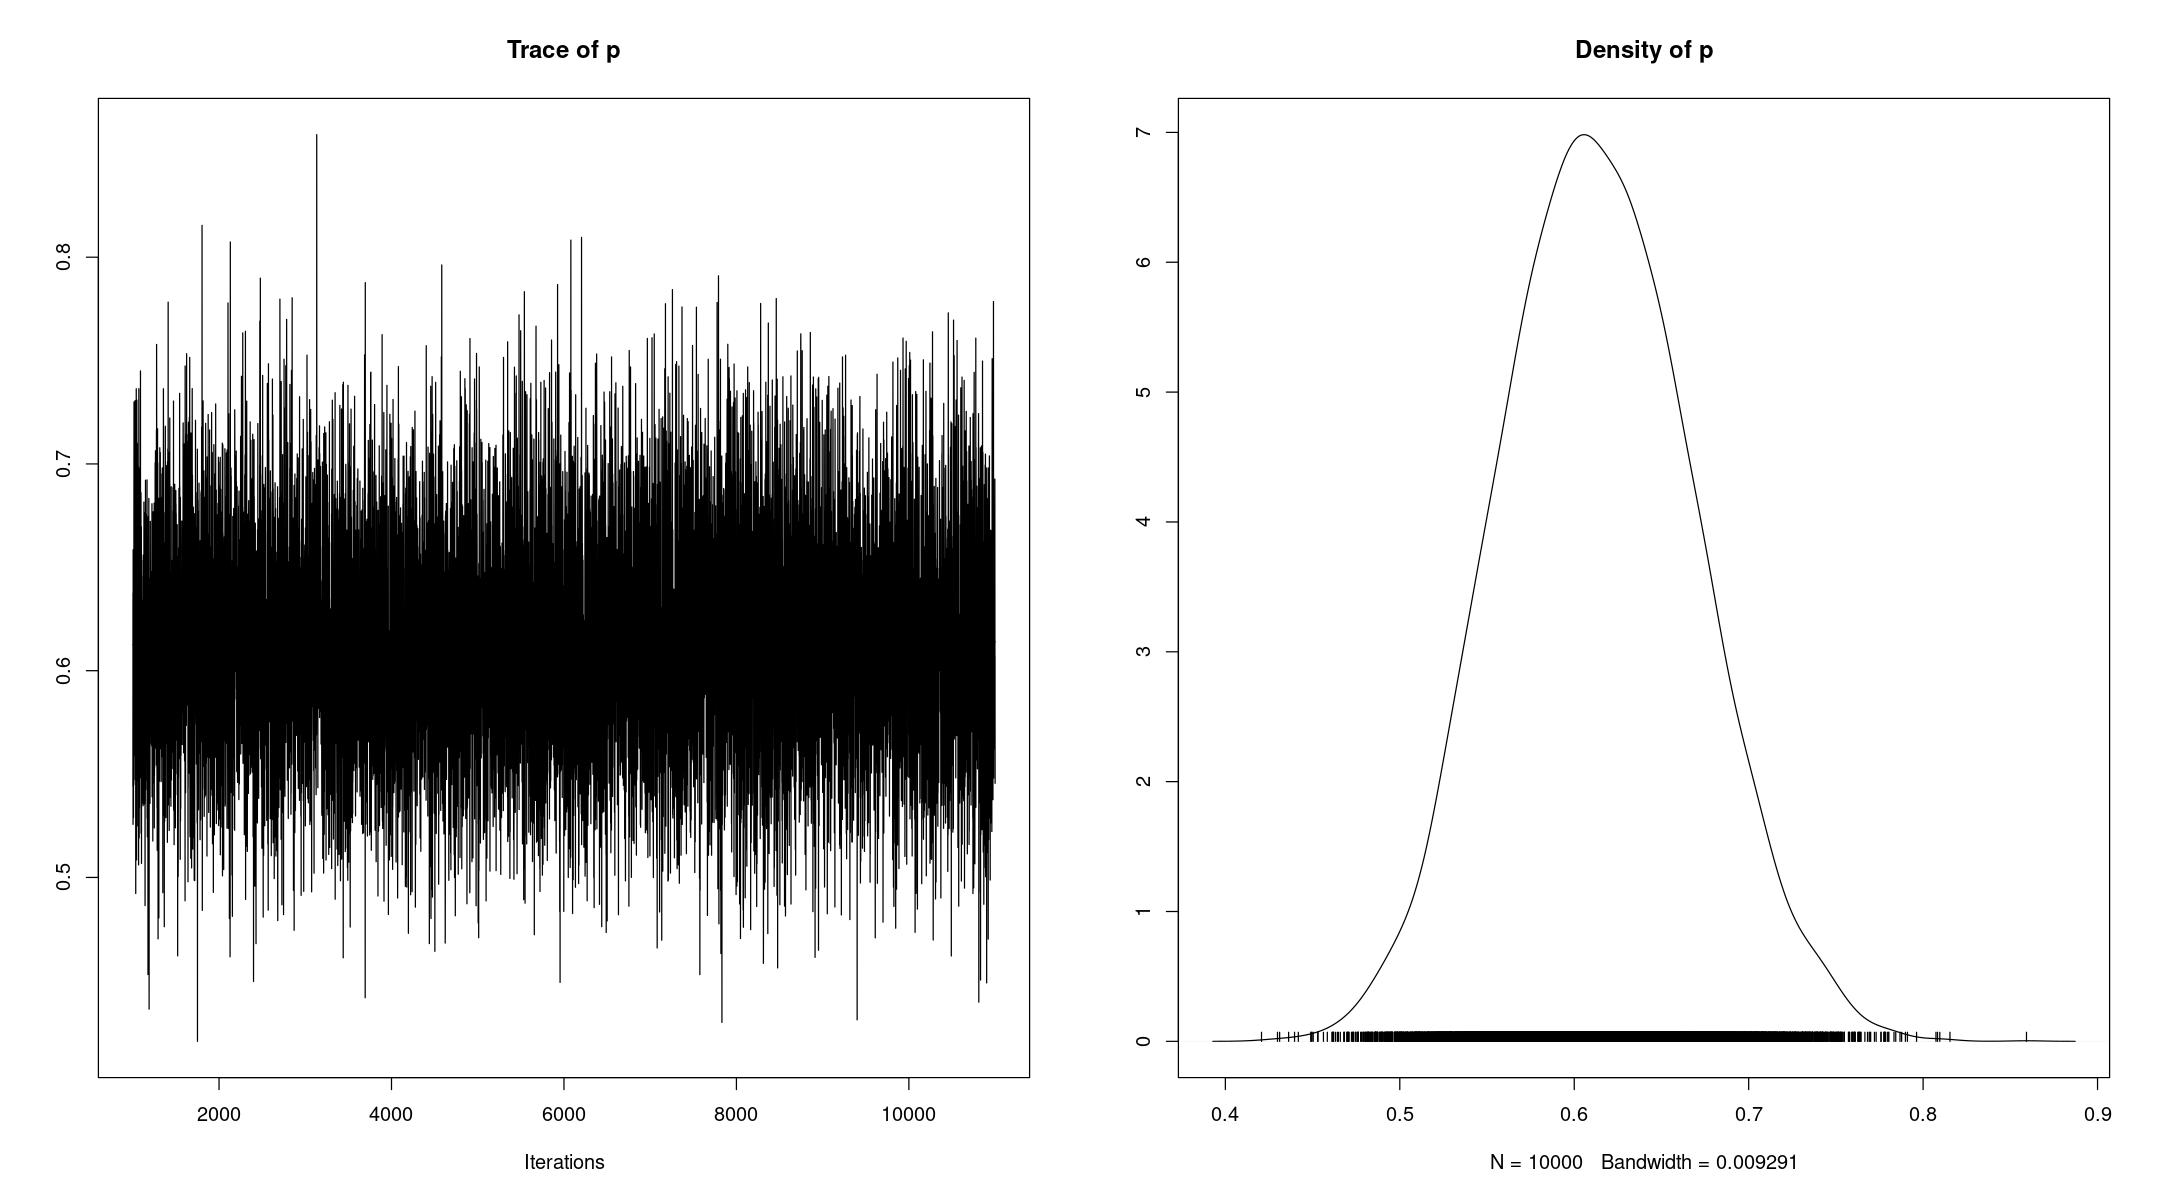

In [203]:
options(repr.plot.width=18, repr.plot.height=10)
plot(chain_j1)

In [204]:
mean_post1 <- unname(summary(chain_j1)$statistics["Mean"])
std_jpost1 <- unname(summary(chain_j1)$statistics["SD"])
CI_jpost1  <- unname(summary(chain_j1)$quantiles[c("2.5%","97.5%")])

cat("mean computed by JAGS", mean_post1,"\n")
cat("mean computed analitically", mean_j1,"\n","-----\n")
cat("std computed by JAGS", std_jpost1,"\n")
cat("std computed analitically", sqrt(var_j1),"\n","-----\n")
cat("95% credibility interval computed by JAGS", CI_jpost1,"\n")
cat("95% credibility interval computed analitically", c(j1_low,j1_high),"\n")

mean computed by JAGS 0.6131437 
mean computed analitically 0.6125 
 -----
std computed by JAGS 0.05530635 
std computed analitically 0.05533986 
 -----
95% credibility interval computed by JAGS 0.5091156 0.724844 
95% credibility interval computed analitically 0.5088464 0.7256196 


second dataset

In [205]:
data2d <- NULL
data2d$alpha  <- 0.5
data2d$lambda <- 0.000001

data2d$X <- deaths2
data2d$n <- n

model <- "bug2.bug"
jm <- jags.model(model,data2d)
update(jm, 1000)
chain_j2 <- coda.samples(jm, c("p"), n.iter=10000)
print(summary(chain_j2))


Warning message in jags.model(model, data2d):
“Unused variable "n" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 280
   Unobserved stochastic nodes: 1
   Total graph size: 283

Initializing model


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.7020372      0.0498706      0.0004987      0.0005150 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
0.6063 0.6678 0.7013 0.7351 0.8014 



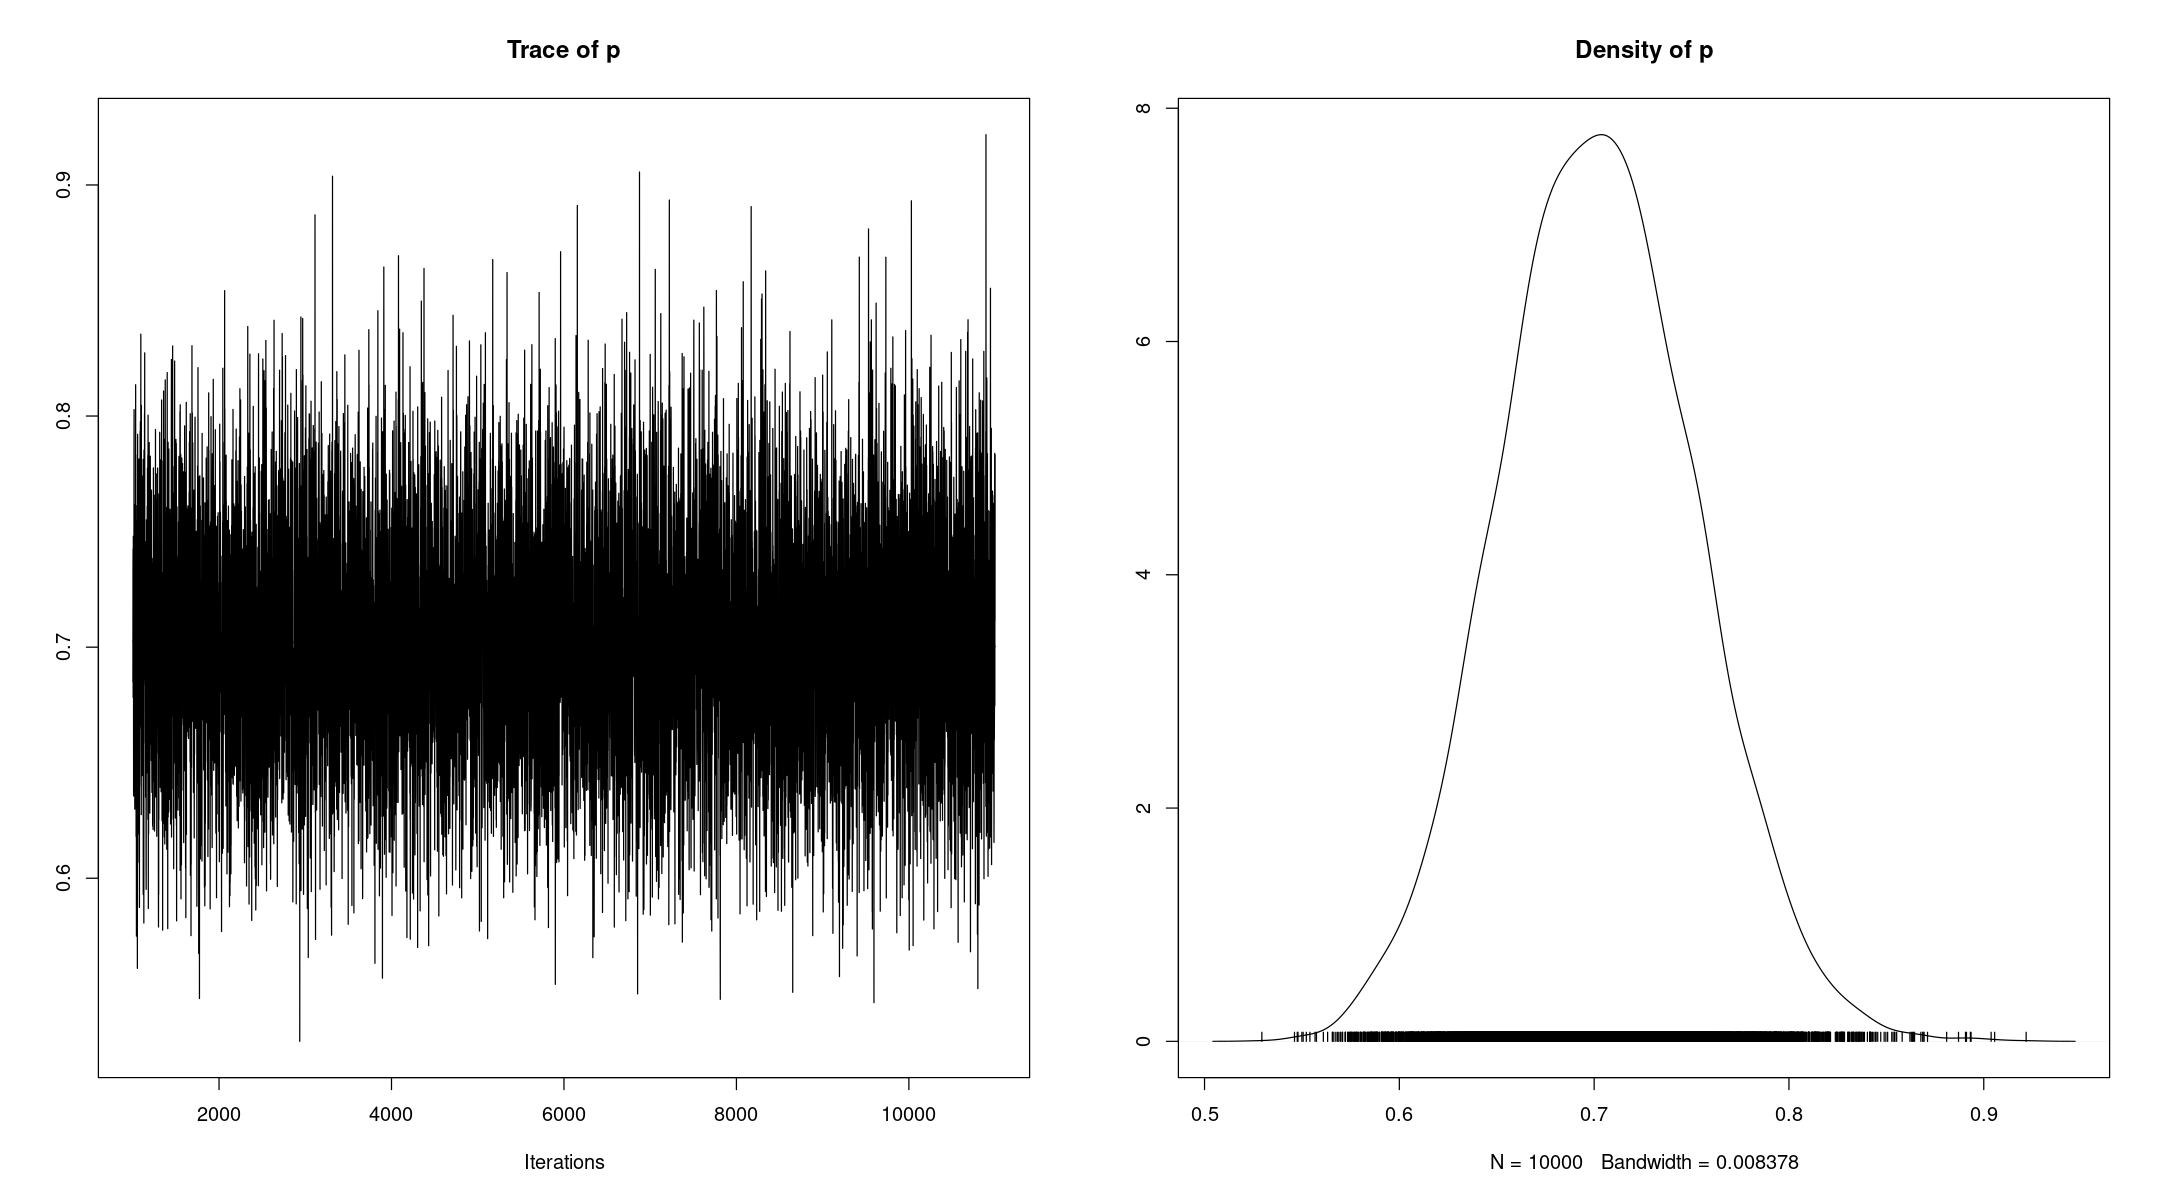

In [209]:
options(repr.plot.width=18, repr.plot.height=10)
plot(chain_j2)

In [210]:
mean_post2 <- unname(summary(chain_j2)$statistics["Mean"])
std_jpost2 <- unname(summary(chain_j2)$statistics["SD"])
CI_jpost2  <- unname(summary(chain_j2)$quantiles[c("2.5%","97.5%")])

cat("mean computed by JAGS", mean_post2,"\n")
cat("mean computed analitically", mean_j2,"\n","-----\n")
cat("std computed by JAGS", std_jpost2,"\n")
cat("std computed analitically", sqrt(var_j2),"\n","-----\n")
cat("95% credibility interval computed by JAGS", CI_jpost2,"\n")
cat("95% credibility interval computed analitically", c(j2_low,j2_high),"\n")

mean computed by JAGS 0.7020372 
mean computed analitically 0.7017857 
 -----
std computed by JAGS 0.0498706 
std computed analitically 0.05006373 
 -----
95% credibility interval computed by JAGS 0.6063131 0.8013815 
95% credibility interval computed analitically 0.6070878 0.8032465 


Warning message:
“Removed 260 rows containing missing values (position_stack).”


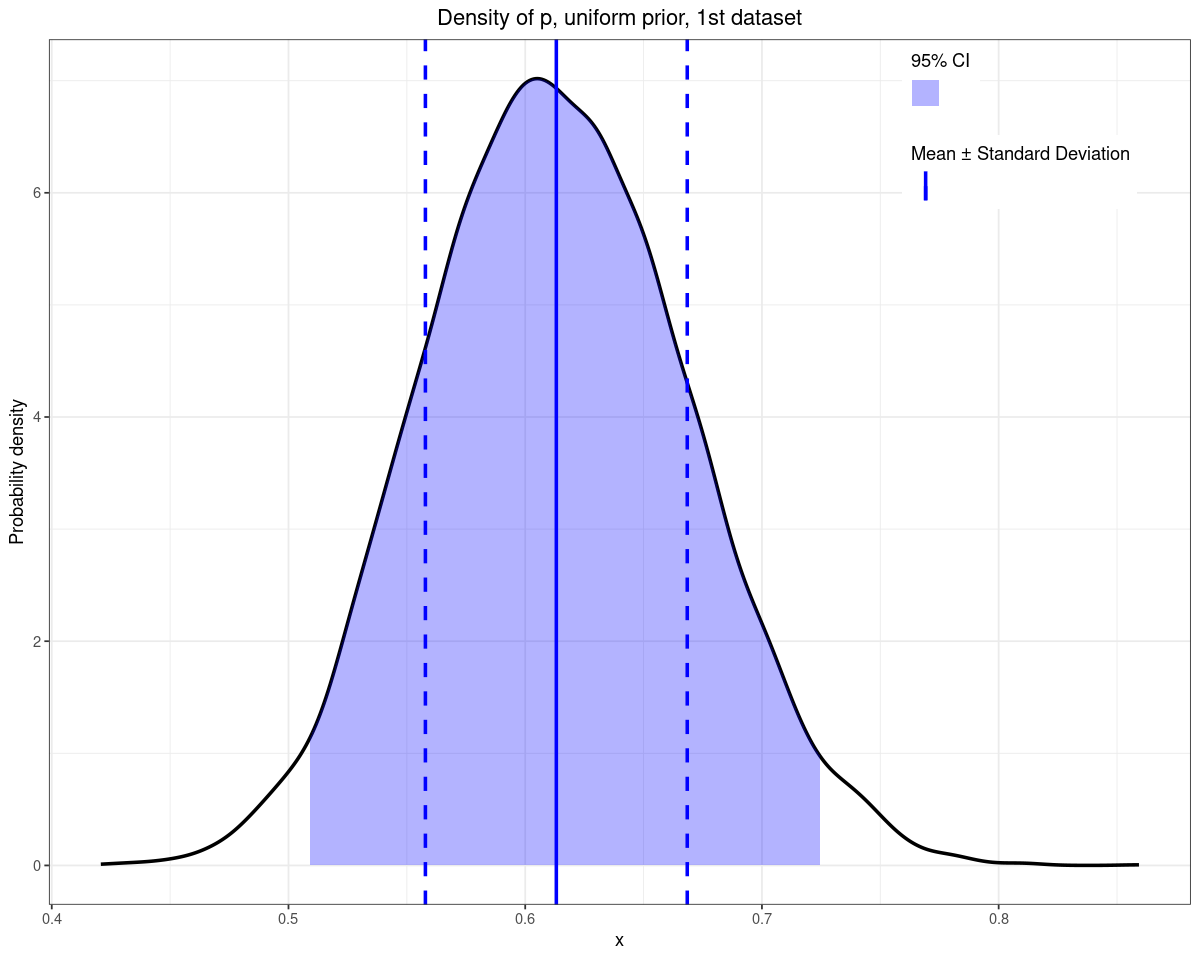

In [215]:
density_df_j1 <- ggplot_build(ggplot() + geom_density(data=as_tibble(as.mcmc(chain_j1)), mapping=aes(x=p)))$data[[1]][c("x","y")]
density_df_j2 <- ggplot_build(ggplot() + geom_density(data=as_tibble(as.mcmc(chain_j2)), mapping=aes(x=p)))$data[[1]][c("x","y")]

options(repr.plot.width=10, repr.plot.height=8)

plot <- ggplot() +
        geom_line(mapping=aes(x=x, y=y), data=density_df_j1, size=1) +
        geom_vline(mapping=aes(xintercept=mean_post1, color=""), size=1) +
        geom_vline(mapping=aes(xintercept=c(mean_post1+std_jpost1,mean_post1-std_jpost1), color=""), linetype="dashed", size=1) +
        geom_area(data=density_df_j1,
                  aes(x=ifelse(x>=CI_jpost1[1] & x<=CI_jpost1[2], x, NA), fill="", y=y),
                  alpha=0.3) +

        labs(title="Density of p, uniform prior, 1st dataset") +
        scale_y_continuous(name="Probability density") +
        scale_fill_manual(values="blue", name="95% CI") +
        scale_colour_manual(values=rep("blue",2), name="Mean ± Standard Deviation") +
        theme_bw() +
        theme(plot.title=element_text(hjust=0.5),legend.position=c(.85,.90))
plot


Warning message:
“Removed 258 rows containing missing values (position_stack).”


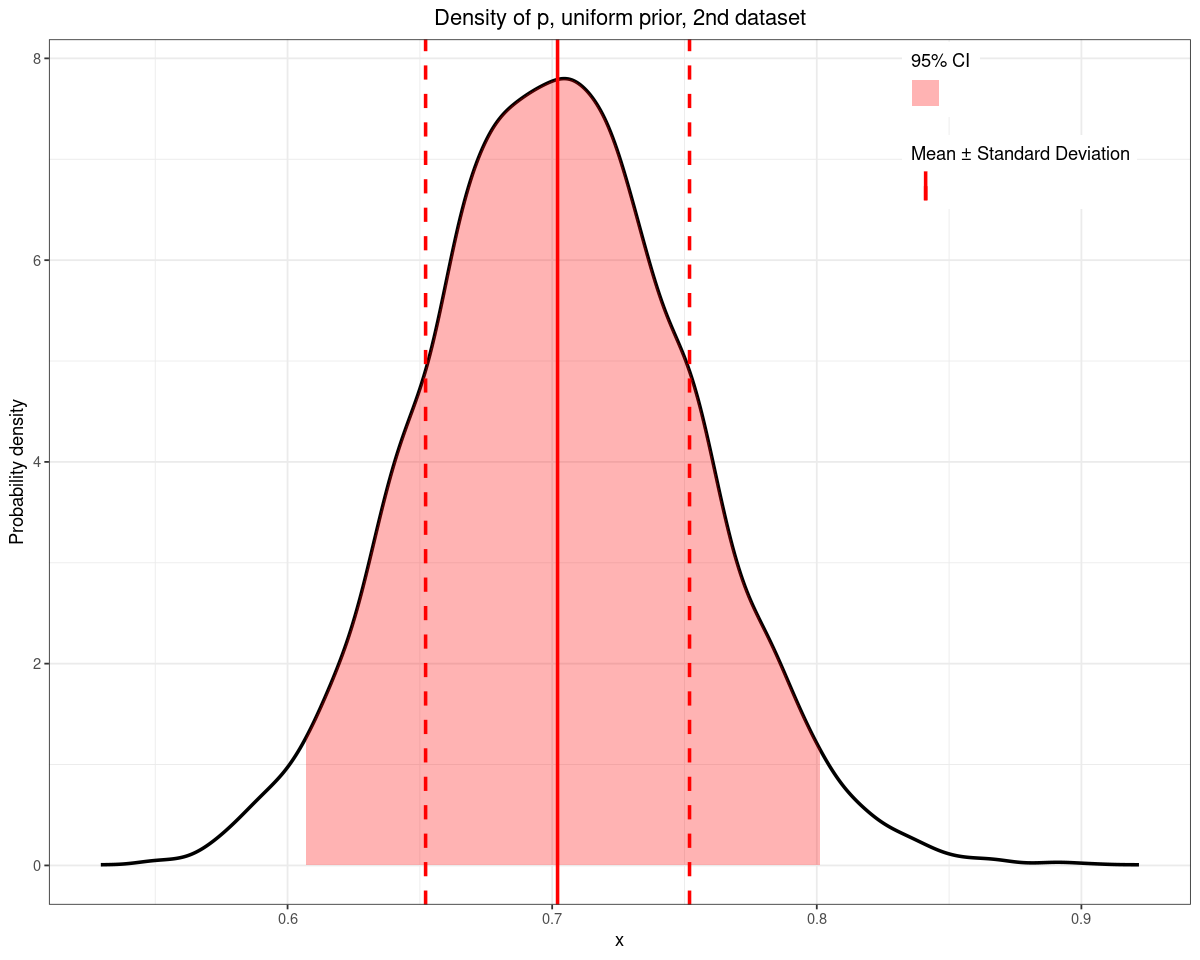

In [216]:
plot <- ggplot() +
        geom_line(mapping=aes(x=x, y=y), data=density_df_j2, size=1) +
        geom_vline(mapping=aes(xintercept=mean_post2, color=""), size=1) +
        geom_vline(mapping=aes(xintercept=c(mean_post2+std_jpost2,mean_post2-std_jpost2), color=""), linetype="dashed", size=1) +
        geom_area(data=density_df_j2,
                  aes(x=ifelse(x>=CI_jpost2[1] & x<=CI_jpost2[2], x, NA), fill="", y=y),
                  alpha=0.3) +
        labs(title="Density of p, uniform prior, 2nd dataset") +
        scale_y_continuous(name="Probability density") +
        scale_fill_manual(values="red", name="95% CI") +
        scale_colour_manual(values=rep("red",2), name="Mean ± Standard Deviation") +
        theme_bw() +
        theme(plot.title=element_text(hjust=0.5),legend.position=c(.85,.90))
plot        


### Es6

In [219]:
n <- 116
y <- 11

p_freq <- y/n

alpha_prior <- 1
beta_prior  <- 10

alpha <- alpha_prior + y
beta  <- beta_prior  + n - y

mu_post  <- alpha / (alpha + beta)
std_post <- sqrt((alpha*beta)/((alpha+beta)^2*(alpha+beta+1)))

low  <- qbeta(0.025, alpha, beta)
high <- qbeta(0.975, alpha, beta)

In [220]:
data3 <- NULL
data3$alpha <- alpha_prior
data3$beta  <- beta_prior

data3$X <- y
data3$n <- n

model <- "bug3.bug"
jm <- jags.model(model,data3)
update(jm, 1000)
chain <- coda.samples(jm, c("p"), n.iter=10000)
print(summary(chain))


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1
   Unobserved stochastic nodes: 1
   Total graph size: 5

Initializing model


Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.0941378      0.0254547      0.0002545      0.0003273 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.05046 0.07608 0.09219 0.11010 0.14957 



In [221]:
mean_post <- unname(summary(chain)$statistics["Mean"])
std_jpost <- unname(summary(chain)$statistics["SD"])
CI_jpost  <- unname(summary(chain)$quantiles[c("2.5%","97.5%")])

cat("mean computed by JAGS", mean_post,"\n")
cat("mean computed analitically", mu_post,"\n","-----\n")
cat("std computed by JAGS", std_jpost,"\n")
cat("std computed analitically", std_post,"\n","-----\n")
cat("95% credibility interval computed by JAGS", CI_jpost,"\n")
cat("95% credibility interval computed analitically", c(low,high),"\n")

mean computed by JAGS 0.09413781 
mean computed analitically 0.09448819 
 -----
std computed by JAGS 0.0254547 
std computed analitically 0.02585418 
 -----
95% credibility interval computed by JAGS 0.05045746 0.1495724 
95% credibility interval computed analitically 0.05018522 0.1508379 


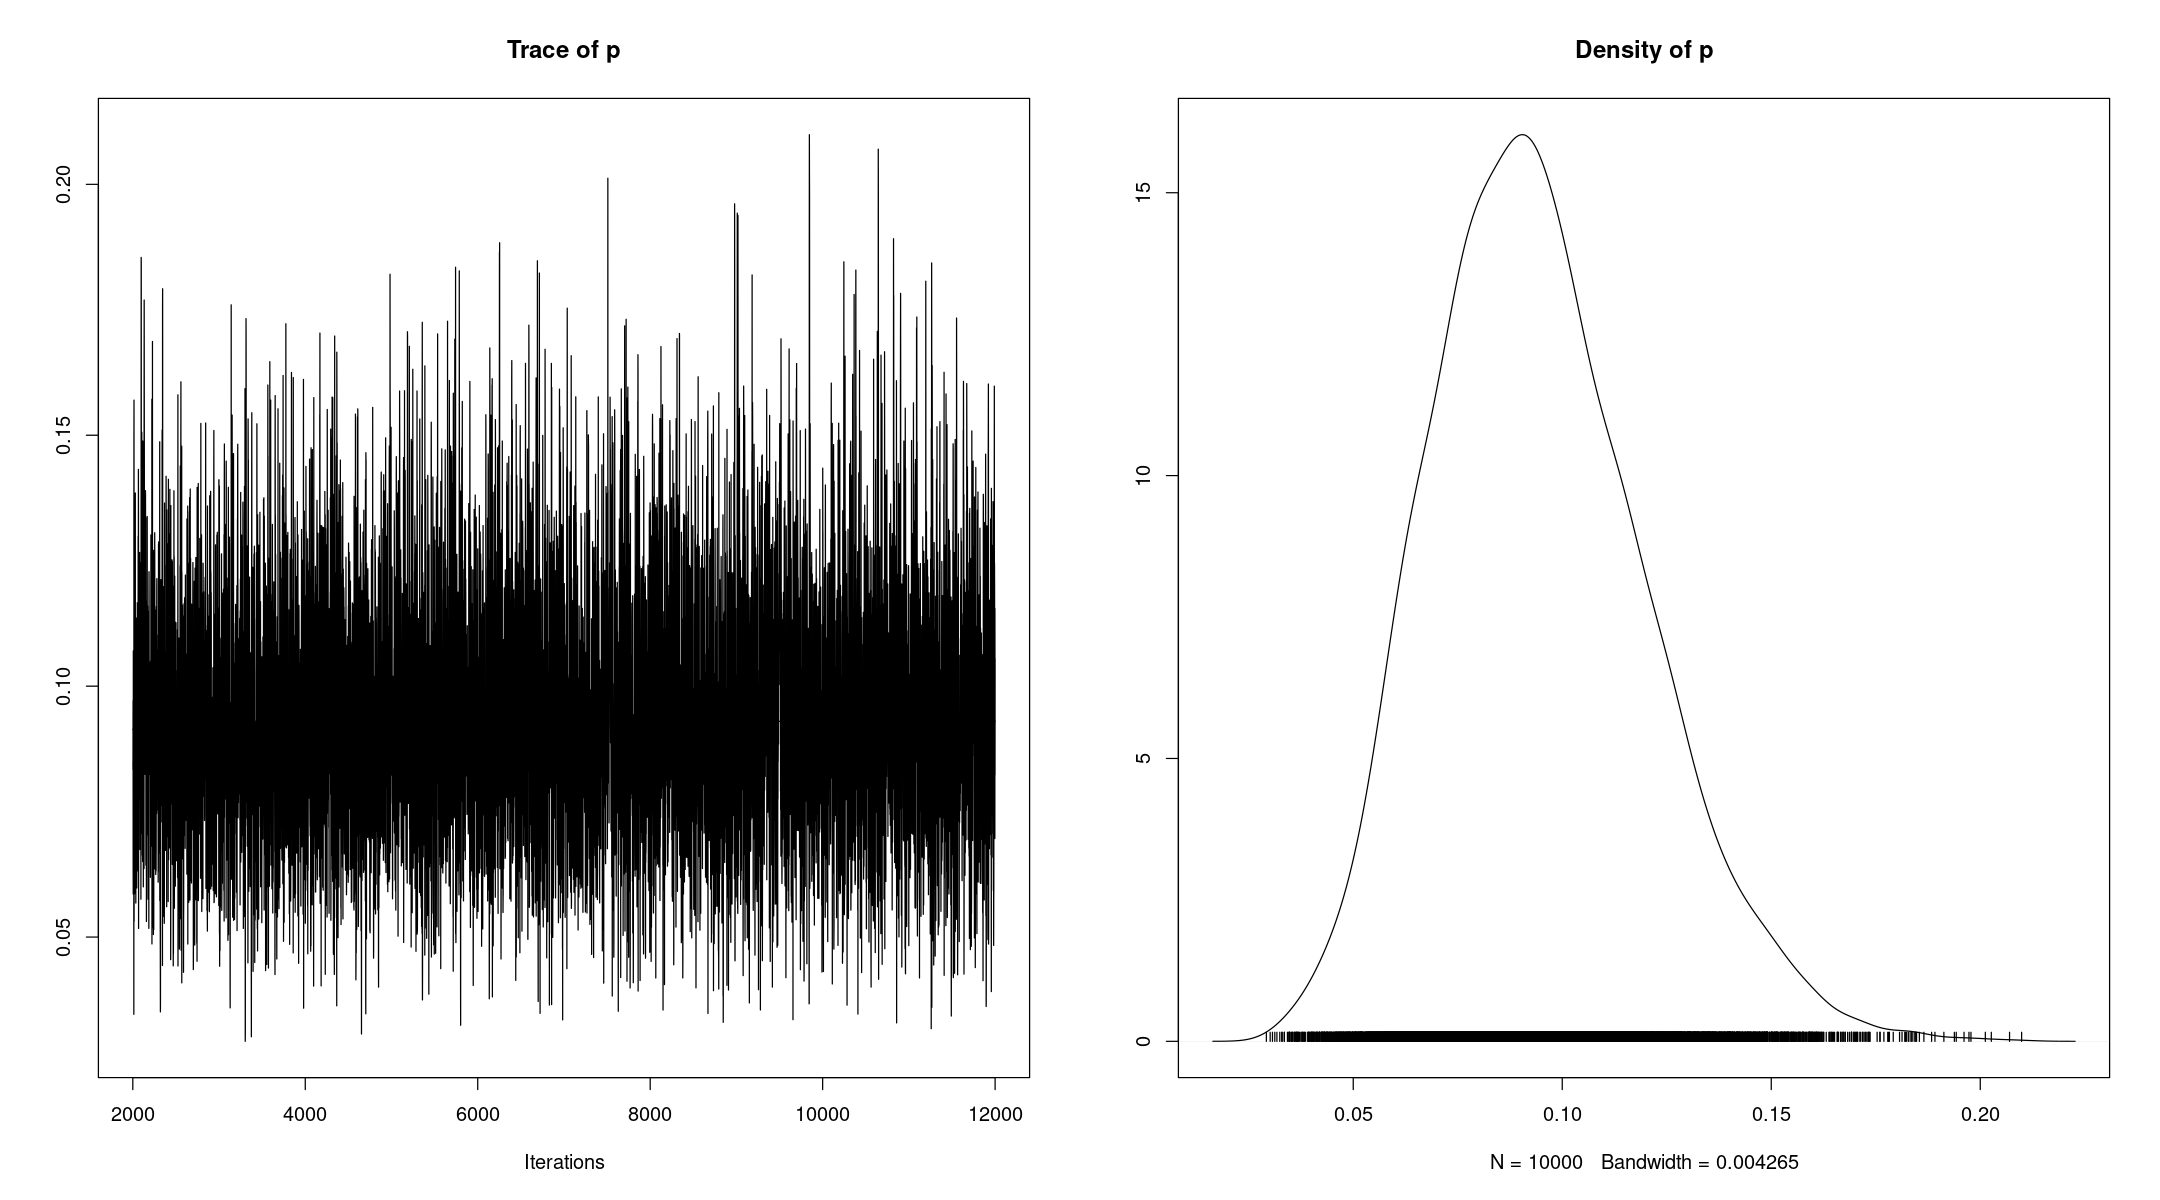

In [222]:
options(repr.plot.width=18, repr.plot.height=10)
plot(chain)

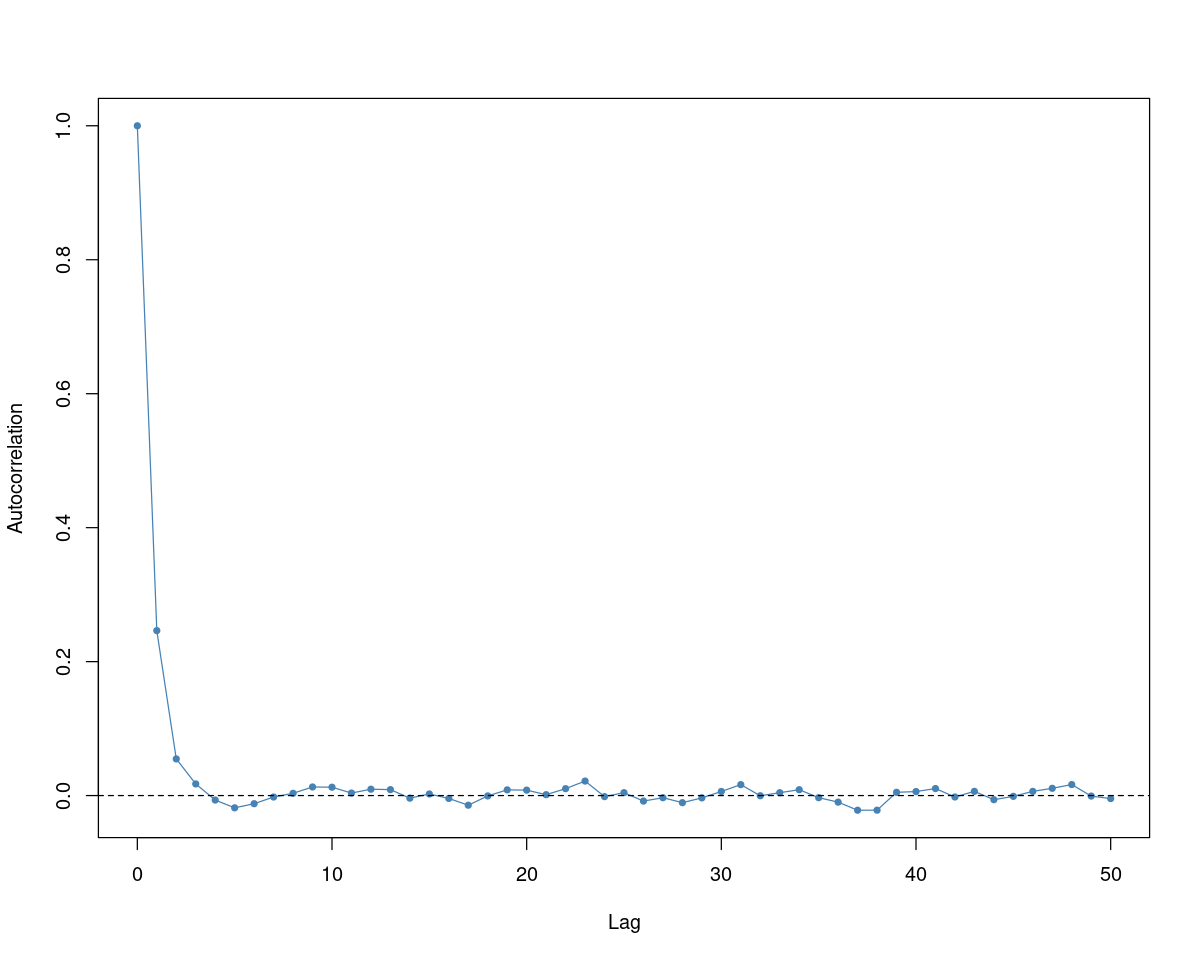

In [224]:
# plot autocorrelation
options(repr.plot.width=10, repr.plot.height=8)

l = c(0:50)
plot(x=l, y=unname(autocorr(chain, lags=l))[[1]], type = 'o', pch = 20, col = "steelblue", cex = 1, lwd = 1,
     main = "", xlab = "Lag", ylab = "Autocorrelation")
abline(h=0, lty="dashed")

Warning message:
“Removed 232 rows containing missing values (position_stack).”


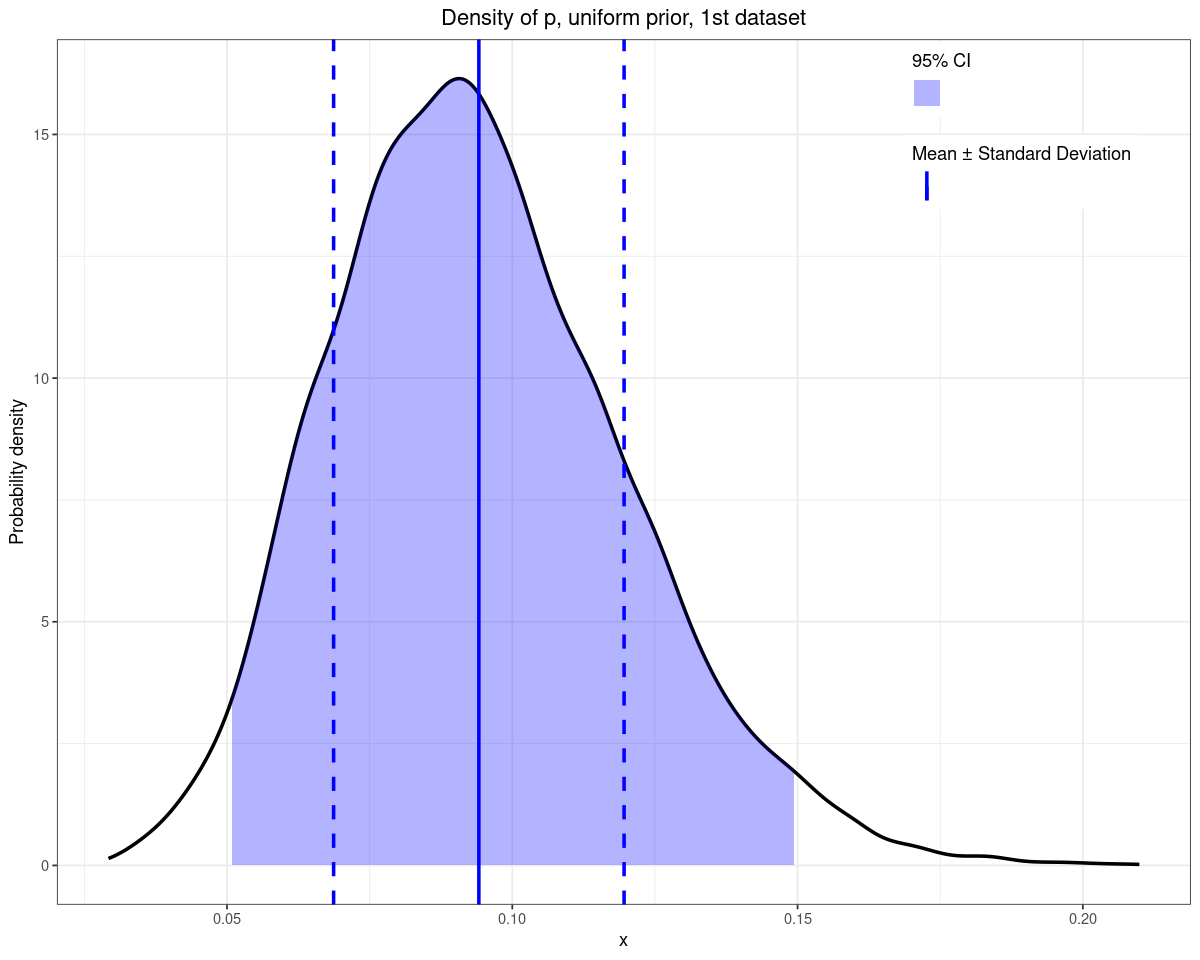

In [223]:
density_df <- ggplot_build(ggplot() + geom_density(data=as_tibble(as.mcmc(chain)), mapping=aes(x=p)))$data[[1]][c("x","y")]

options(repr.plot.width=10, repr.plot.height=8)

plot <- ggplot() +
        geom_line(mapping=aes(x=x, y=y), data=density_df, size=1) +
        geom_vline(mapping=aes(xintercept=mean_post, color=""), size=1) +
        geom_vline(mapping=aes(xintercept=c(mean_post+std_jpost,mean_post-std_jpost), color=""), linetype="dashed", size=1) +
        geom_area(data=density_df,
                  aes(x=ifelse(x>=CI_jpost[1] & x<=CI_jpost[2], x, NA), fill="", y=y),
                  alpha=0.3) +

        labs(title="Density of p, uniform prior, 1st dataset") +
        scale_y_continuous(name="Probability density") +
        scale_fill_manual(values="blue", name="95% CI") +
        scale_colour_manual(values=rep("blue",2), name="Mean ± Standard Deviation") +
        theme_bw() +
        theme(plot.title=element_text(hjust=0.5),legend.position=c(.85,.90))
plot


### Every simulation result is very similar to the analitical one, "similary" with respect to the std.